In [1]:
from utils.BackTest import Engine, Strategy
import pandas as pd
import xgboost as xgb
import numpy as np
from torch.utils.data import Dataset,DataLoader
from tqdm import tqdm
import optuna
import optuna.visualization as vis
import os
import matplotlib.pyplot as plt

c:\Users\leoqi\miniforge3\envs\Finance\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
temp1 = pd.read_csv(r'../data/processed/features_trading_strategy.csv')

In [3]:
temp1[temp1.duplicated()]

,datetime,OPEN,HIGH,LOW,CLOSE,TOTAL_TRADES,TOTAL_TRADES_BUY,TOTAL_TRADES_SELL,VOLUME,VOLUME_BUY,...,%D,Stochastic_Signal,OBV,OBV_EMA20,OBV_Signal,H-L,H-PC,L-PC,TR,ATR


In [4]:
temp1['datetime'] = pd.to_datetime(temp1['datetime']).dt.tz_localize(None)

In [5]:
temp2 = pd.read_csv(r'../data/processed/merged_df_04_April.csv')

In [6]:
temp2[temp2.duplicated()]

,datetime,EMA_8,EMA_13,EMA_21,EMA_Signal,EMA_short,EMA_long,MACD,Signal_Line,MACD_Hist,...,OBV_EMA20,OBV_Signal,ATR,reddit_smoothed_sentiment_weibull_week,return,hourly_volatility,TOTAL_TRADES,VOLUME,news_smoothed_sentiment_weibull_week,tele_smoothed_sentiment_weibull_week


In [7]:
temp3 = temp2[['datetime','reddit_smoothed_sentiment_weibull_week','news_smoothed_sentiment_weibull_week','tele_smoothed_sentiment_weibull_week']].copy()

In [8]:
temp3['datetime'] = pd.to_datetime(temp3['datetime']).dt.tz_localize(None)

In [9]:
temp3

,datetime,reddit_smoothed_sentiment_weibull_week,news_smoothed_sentiment_weibull_week,tele_smoothed_sentiment_weibull_week
0,2024-01-27 13:00:00,0.000000,-857.923901,6.155144
1,2024-01-27 14:00:00,0.027001,-867.694664,6.210698
2,2024-01-27 15:00:00,0.164191,-875.992357,6.257500
3,2024-01-27 16:00:00,0.300527,-882.407146,6.288940
4,2024-01-27 17:00:00,0.435303,-886.430380,6.354606
...,...,...,...,...
10356,2025-04-03 01:00:00,-5.839800,-782.334588,6.330760
10357,2025-04-03 02:00:00,-5.926306,-834.047701,6.225174
10358,2025-04-03 03:00:00,-5.998155,-891.726405,6.110698
10359,2025-04-03 04:00:00,-6.055226,-953.916263,5.988066


In [10]:
signs = np.sign(temp3[['reddit_smoothed_sentiment_weibull_week','news_smoothed_sentiment_weibull_week','tele_smoothed_sentiment_weibull_week']])

sentiment_cols = ['reddit_smoothed_sentiment_weibull_week',
                  'news_smoothed_sentiment_weibull_week',
                  'tele_smoothed_sentiment_weibull_week']

# Get the absolute values and shift them to ensure minimum is 1
shifted_abs_values =temp3[sentiment_cols].abs() + (1 -temp3[sentiment_cols].abs().min())

log_transformed = np.log(shifted_abs_values)
log_signed = log_transformed * signs

temp3[['reddit_sentiment_log','news_sentiment_log','tele_sentiment_log']] = log_signed

In [11]:
temp3[['reddit_Signal','news_Signal','tele_Signal']] = np.sign(temp3[['reddit_sentiment_log','news_sentiment_log','tele_sentiment_log']])

In [12]:
temp3

,datetime,reddit_smoothed_sentiment_weibull_week,news_smoothed_sentiment_weibull_week,tele_smoothed_sentiment_weibull_week,reddit_sentiment_log,news_sentiment_log,tele_sentiment_log,reddit_Signal,news_Signal,tele_Signal
0,2024-01-27 13:00:00,0.000000,-857.923901,6.155144,0.000000,-6.755482,1.967774,0.0,-1.0,1.0
1,2024-01-27 14:00:00,0.027001,-867.694664,6.210698,0.026643,-6.766796,1.975509,1.0,-1.0,1.0
2,2024-01-27 15:00:00,0.164191,-875.992357,6.257500,0.152026,-6.776304,1.981979,1.0,-1.0,1.0
3,2024-01-27 16:00:00,0.300527,-882.407146,6.288940,0.262769,-6.783594,1.986302,1.0,-1.0,1.0
4,2024-01-27 17:00:00,0.435303,-886.430380,6.354606,0.361376,-6.788139,1.995271,1.0,-1.0,1.0
...,...,...,...,...,...,...,...,...,...,...
10356,2025-04-03 01:00:00,-5.839800,-782.334588,6.330760,-1.922758,-6.663343,1.992023,-1.0,-1.0,1.0
10357,2025-04-03 02:00:00,-5.926306,-834.047701,6.225174,-1.935327,-6.727285,1.977515,-1.0,-1.0,1.0
10358,2025-04-03 03:00:00,-5.998155,-891.726405,6.110698,-1.945647,-6.794090,1.961543,-1.0,-1.0,1.0
10359,2025-04-03 04:00:00,-6.055226,-953.916263,5.988066,-1.953769,-6.861446,1.944145,-1.0,-1.0,1.0


In [13]:
df = temp3.merge(temp1, on='datetime', how='inner')
df

,datetime,reddit_smoothed_sentiment_weibull_week,news_smoothed_sentiment_weibull_week,tele_smoothed_sentiment_weibull_week,reddit_sentiment_log,news_sentiment_log,tele_sentiment_log,reddit_Signal,news_Signal,tele_Signal,...,%D,Stochastic_Signal,OBV,OBV_EMA20,OBV_Signal,H-L,H-PC,L-PC,TR,ATR
0,2024-01-27 13:00:00,0.000000,-857.923901,6.155144,0.000000,-6.755482,1.967774,0.0,-1.0,1.0,...,71.453152,0,-419.38468,-65.712408,0,81.34,56.55,24.79,81.34,175.710000
1,2024-01-27 14:00:00,0.027001,-867.694664,6.210698,0.026643,-6.766796,1.975509,1.0,-1.0,1.0,...,75.565353,0,493.43458,-12.460314,1,87.38,75.95,11.43,87.38,140.500000
2,2024-01-27 15:00:00,0.164191,-875.992357,6.257500,0.152026,-6.776304,1.981979,1.0,-1.0,1.0,...,81.265642,0,581.25856,44.084341,0,161.27,128.87,32.40,161.27,109.318333
3,2024-01-27 16:00:00,0.300527,-882.407146,6.288940,0.262769,-6.783594,1.986302,1.0,-1.0,1.0,...,87.299043,0,-609.18361,-18.131655,-1,104.52,81.74,22.78,104.52,101.921667
4,2024-01-27 17:00:00,0.435303,-886.430380,6.354606,0.361376,-6.788139,1.995271,1.0,-1.0,1.0,...,88.481853,-1,-448.23397,-59.093780,0,71.27,35.16,36.11,71.27,99.801667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10356,2025-04-03 01:00:00,-5.839800,-782.334588,6.330760,-1.922758,-6.663343,1.992023,-1.0,-1.0,1.0,...,14.337490,0,1735.38082,-276.396269,0,898.03,770.47,127.56,898.03,1608.958333
10357,2025-04-03 02:00:00,-5.926306,-834.047701,6.225174,-1.935327,-6.727285,1.977515,-1.0,-1.0,1.0,...,23.509838,0,1422.27146,-114.618390,0,615.92,133.29,482.63,615.92,1166.343333
10358,2025-04-03 03:00:00,-5.998155,-891.726405,6.110698,-1.945647,-6.794090,1.961543,-1.0,-1.0,1.0,...,25.388831,0,-638.13813,-164.477413,-1,442.93,24.57,418.36,442.93,984.171667
10359,2025-04-03 04:00:00,-6.055226,-953.916263,5.988066,-1.953769,-6.861446,1.944145,-1.0,-1.0,1.0,...,23.902608,0,630.55266,-88.760263,1,472.80,251.88,220.92,472.80,700.640000


In [14]:
df['typical_price'] = (df['HIGH'] + df['LOW'] + df['CLOSE']) / 3

df['DATE'] = df['datetime'].dt.date  
df['VWAP'] = df.groupby('DATE').apply(
    lambda g: (g['typical_price'] * g['VOLUME']).cumsum() / g['VOLUME'].cumsum()
).reset_index(level=0, drop=True)

C:\Users\leoqi\AppData\Local\Temp\ipykernel_29180\2626485675.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['VWAP'] = df.groupby('DATE').apply(


In [15]:
def determine_signal(df):
    """
    Determine the trading signal based on the strategy's criteria.
    """
    if df['CLOSE'] > df['VWAP']:
        return 1
    elif df['CLOSE'] < df['VWAP']:
        return -1
    else:
        return 0

In [16]:
df['VWAP_Signal'] = df.apply(determine_signal, axis=1)

df['VWAP_Signal'] = df['VWAP_Signal'].fillna(0)

In [17]:
df_filtered = df.rename(columns={'OPEN':'Open',
                                 'CLOSE':'Close',
                                 'HIGH':'High',
                                 'LOW':'Low'})

In [18]:
base_price_data = ['datetime','Close','Open','High','Low','VOLUME']

technical_indicators = [
    # Trend Indicators
    'EMA_8', 'EMA_13', 'EMA_21', 'EMA_Signal', 'EMA_short', 'EMA_long',
    'SMA20', 'SMA_50', 'SMA_200', 'GoldenCross_Signal',

    # Momentum Indicators
    'MACD', 'Signal_Line', 'MACD_Signal', 'MACD_Hist',
    'RSI_14', 'BB_RSI_Signal', 'RSI_Signal',
    '%K', '%D', 'Stochastic_Signal',

    # Volatility Indicators
    'STD20', 'Upper_BB', 'Lower_BB', 'ATR', 'TR',

    # Volume-Based Indicators
    'OBV', 'OBV_EMA20', 'OBV_Signal', 'VWAP_Signal'
]

sentiment_indicators = [
    'reddit_sentiment_log',
    'tele_sentiment_log',
    'news_sentiment_log',
]

# Create a new DataFrame with the selected columns
selected_columns = base_price_data + technical_indicators + sentiment_indicators
df_selected = df_filtered[selected_columns]

In [19]:
working_frame = df_selected.copy().set_index(pd.to_datetime(df_selected['datetime'])).drop(columns=['datetime'])
working_frame

,Close,Open,High,Low,VOLUME,EMA_8,EMA_13,EMA_21,EMA_Signal,EMA_short,...,Lower_BB,ATR,TR,OBV,OBV_EMA20,OBV_Signal,VWAP_Signal,reddit_sentiment_log,tele_sentiment_log,news_sentiment_log
datetime,,,,,,,,,,,,,,,,,,,,,
2024-01-27 13:00:00,41742.44,41750.00,41806.55,41725.21,419.38468,41729.550796,41714.525206,41617.761701,1,41720.541302,...,41524.488454,175.710000,81.34,-419.38468,-65.712408,0,-1,0.000000,1.967774,-6.755482
2024-01-27 14:00:00,41766.00,41742.44,41818.39,41731.01,493.43458,41737.650619,41721.878748,41631.237910,1,41727.534948,...,41541.267296,140.500000,87.38,493.43458,-12.460314,1,1,0.026643,1.975509,-6.766796
2024-01-27 15:00:00,41814.00,41766.00,41894.87,41733.60,581.25856,41754.617148,41735.038927,41647.852645,1,41740.837263,...,41561.147977,109.318333,161.27,581.25856,44.084341,0,1,0.152026,1.981979,-6.776304
2024-01-27 16:00:00,41810.18,41814.00,41895.74,41791.22,609.18361,41766.964449,41745.773366,41662.609678,1,41751.505377,...,41571.210298,101.921667,104.52,-609.18361,-18.131655,-1,1,0.262769,1.986302,-6.783594
2024-01-27 17:00:00,41779.28,41810.18,41845.34,41774.07,448.23397,41769.701238,41750.560028,41673.216071,1,41755.778396,...,41588.600128,99.801667,71.27,-448.23397,-59.093780,0,-1,0.361376,1.995271,-6.788139
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-03 01:00:00,83761.62,83227.55,83998.02,83099.99,1735.38082,84162.340510,84536.321847,84721.927318,-1,84484.991365,...,82359.399318,1608.958333,898.03,1735.38082,-276.396269,0,1,-1.922758,1.992023,-6.663343
2025-04-03 02:00:00,83768.01,83761.62,83894.91,83278.99,1422.27146,84074.711507,84426.563012,84635.207562,-1,84374.686539,...,82311.617892,1166.343333,615.92,1422.27146,-114.618390,0,1,-1.935327,1.977515,-6.727285
2025-04-03 03:00:00,83483.97,83768.01,83792.58,83349.65,638.13813,83943.435617,84291.906867,84530.549602,-1,84237.653226,...,82190.303036,984.171667,442.93,-638.13813,-164.477413,-1,1,-1.945647,1.961543,-6.794090


In [20]:
loaded_model = xgb.XGBRegressor()
loaded_model.load_model('xgboost_model.json')

In [21]:
loaded_final_model = xgb.XGBRegressor()
loaded_final_model.load_model('xgboost_model_final.json')

In [22]:
# labels = pd.read_parquet(f'../data/processed/labels_btc.parquet')
# inputs = np.load(f'../data/processed/inputs_btc.npy')

In [23]:
class XGBoostStrategy(Strategy):
    def __init__(self,model,bet_size = 0.1,initial_data=None):
        super().__init__()
        self.model = model 
        self.initial_data = initial_data
        self.bet_size = bet_size  # 10% of cash

    def on_bar(self):

        temp_df = pd.concat([self.initial_data, self.data])

        features = self.sequencing_data(temp_df, window_size=6)

        # ###TESTING INPUTS###
        # print("Current index:", self.current_idx)

        # idx = labels[labels['inference_date'] == self.current_idx].index
        # arr = inputs[idx]
        # are_close = np.allclose(arr, features, atol=1e-5)

        # print("Arrays are close:", are_close)

        # if self.current_idx == pd.to_datetime('2025-02-28 00:00:00'):
        #     print(features)

        predictions = self.model.predict(features)
        signal = self.determine_signal(predictions)
        if signal == 1:
            self.buy(
                "btc",
               size = round(self.bet_size * (self.cash) / self.close(), 8)
            )
        elif signal == -1:
            self.sell(
                "btc",
                size = round( self.bet_size * (self.cash) / self.close(), 8)
            )
        else:
            pass

    def determine_signal(self, predictions):
        """Determine buy/sell/hold signal based on predictions."""
        future_forecasts = predictions.flatten().tolist()  # Convert to list if needed
        close = self.close()

        above_close = sum(forecast > close for forecast in future_forecasts)
        below_close = sum(forecast < close for forecast in future_forecasts)

        if above_close >= 3:
            return 1  # Buy
        elif below_close >= 3:
            return -1  # Sell
        else:
           return 0  # Hold
        
    def sequencing_data(self, df, window_size=6):
        start_time = self.current_idx - pd.Timedelta(hours=window_size)
        past_data = df.loc[start_time:self.current_idx]

        # Collect past feature lists
        past_features = [
            past_data['Close'].tolist(),
            past_data['High'].tolist(),
            past_data['Low'].tolist(),
            past_data['VOLUME'].tolist()
        ]

        # Technical Indicators
        indicators = [
            'EMA_8', 'EMA_13', 'EMA_21', 'EMA_Signal', 'EMA_short', 'EMA_long',
            'SMA20', 'SMA_50', 'SMA_200', 'GoldenCross_Signal',
            'MACD', 'Signal_Line', 'MACD_Signal', 'MACD_Hist',
            'RSI_14', 'BB_RSI_Signal', 'RSI_Signal',
            '%K', '%D', 'Stochastic_Signal',
            'STD20', 'Upper_BB', 'Lower_BB', 'ATR', 'TR',
            'OBV', 'OBV_EMA20', 'OBV_Signal', 'VWAP_Signal'
        ]
        
        for indicator in indicators:
            past_features.append(past_data[indicator].tolist())

        # Sentiment indicators
        sentiments = ['reddit_sentiment_log', 'tele_sentiment_log', 'news_sentiment_log']
        
        for sentiment in sentiments:
            past_features.append(past_data[sentiment].tolist())

        # Convert to 1D NumPy array and reshape to (1, 252)
        past_features_array = np.concatenate(past_features).reshape(1, -1)
        
        return past_features_array  # Shape: (1, 252)

In [24]:
initial_val_frame = working_frame[(working_frame.index >= pd.to_datetime('2025-01-01') - pd.Timedelta(hours=6)) & (working_frame.index < '2025-01-01')]
validate_frame = working_frame[(working_frame.index >= '2025-01-01') & (working_frame.index < '2025-03-01')]

initial_test_frame = working_frame[(working_frame.index >= pd.to_datetime('2025-03-01') - pd.Timedelta(hours=6)) & (working_frame.index < '2025-03-01')]
test_frame = working_frame[working_frame.index >= '2025-03-01']

In [25]:
validate_frame

,Close,Open,High,Low,VOLUME,EMA_8,EMA_13,EMA_21,EMA_Signal,EMA_short,...,Lower_BB,ATR,TR,OBV,OBV_EMA20,OBV_Signal,VWAP_Signal,reddit_sentiment_log,tele_sentiment_log,news_sentiment_log
datetime,,,,,,,,,,,,,,,,,,,,,
2025-01-01 00:00:00,94401.14,93576.00,94509.42,93489.03,755.99010,94011.893818,94029.638251,93958.906655,0,94032.973503,...,92381.690536,622.563333,1020.39,755.99010,103.811170,0,1,0.450214,1.654792,-6.587146
2025-01-01 01:00:00,93607.74,94401.14,94408.72,93578.77,586.53456,93922.081858,93969.367072,93926.982413,-1,93967.552964,...,92563.555167,664.478333,829.95,-586.53456,38.063957,-1,-1,0.375333,1.673762,-6.607708
2025-01-01 02:00:00,94098.91,93607.74,94105.12,93594.56,276.78045,93961.377001,93987.873205,93942.612194,0,93987.761739,...,92755.139100,620.850000,510.56,276.78045,60.798861,1,1,0.295866,1.689920,-6.627062
2025-01-01 03:00:00,93838.04,94098.91,94098.91,93728.22,220.99302,93933.968779,93966.468461,93933.105631,0,93964.727625,...,92934.645329,606.051667,370.69,-220.99302,33.961539,-1,-1,0.211558,1.703362,-6.644706
2025-01-01 04:00:00,93553.91,93838.04,93838.04,93500.00,279.46909,93849.511272,93907.531538,93898.633301,-1,93901.524914,...,92885.780670,575.041667,338.04,-279.46909,4.111003,0,-1,0.122122,1.714176,-6.659001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-28 19:00:00,84449.99,84440.97,84810.35,84209.84,1656.89446,83302.202137,82785.136766,82669.910295,1,82850.241395,...,77705.107174,1456.295000,600.51,1656.89446,484.835909,0,1,-1.221349,0.946237,-8.396762
2025-02-28 20:00:00,84191.27,84449.99,84795.03,83600.00,2215.50549,83499.772773,82986.012942,82808.215723,1,83056.553488,...,77711.558133,1409.260000,1195.03,-2215.50549,227.660538,-1,1,-1.246760,0.928995,-8.393514
2025-02-28 21:00:00,84258.37,84191.27,84596.00,84000.17,862.30163,83668.349935,83167.778236,82940.047930,1,83241.448336,...,77655.745657,1103.960000,595.83,862.30163,288.102547,1,1,-1.269582,0.912026,-8.389415


In [26]:
initial_val_frame

,Close,Open,High,Low,VOLUME,EMA_8,EMA_13,EMA_21,EMA_Signal,EMA_short,...,Lower_BB,ATR,TR,OBV,OBV_EMA20,OBV_Signal,VWAP_Signal,reddit_sentiment_log,tele_sentiment_log,news_sentiment_log
datetime,,,,,,,,,,,,,,,,,,,,,
2024-12-31 18:00:00,93875.68,94120.94,94416.72,93779.80,816.81017,94452.342269,94276.150021,94036.116190,1,94314.297882,...,91418.780827,1160.111667,636.92,-816.81017,43.134507,0,-1,0.644116,1.495973,-6.413587
2024-12-31 19:00:00,94166.88,93875.68,94290.91,93712.45,462.79342,94388.906209,94260.540018,94048.003809,1,94291.618208,...,91518.783895,1001.461667,578.46,462.79342,83.102023,1,1,0.618698,1.518738,-6.449630
2024-12-31 20:00:00,93564.04,94166.88,94222.50,93450.17,733.04147,94205.602607,94161.040016,94004.007099,1,94179.683099,...,91657.553926,983.908333,772.33,-733.04147,5.374071,-1,-1,0.592473,1.548556,-6.482636
2024-12-31 21:00:00,93899.68,93564.04,93964.15,93504.67,337.52715,94137.619805,94123.702871,93994.522817,1,94136.605699,...,91830.596274,881.571667,459.48,337.52715,37.007698,1,-1,0.565590,1.579921,-6.514657
2024-12-31 22:00:00,93488.84,93899.68,93899.68,93375.58,315.53272,93993.446515,94033.008175,93948.551652,0,94036.949438,...,91979.914579,804.901667,524.10,-315.53272,3.432420,-1,-1,0.538200,1.607992,-6.543260
2024-12-31 23:00:00,93576.00,93488.84,93756.00,93375.38,336.57995,93900.680623,93967.721293,93914.683320,-1,93966.034140,...,92141.877951,558.651667,380.62,336.57995,35.160756,1,-1,0.510451,1.632907,-6.566459


In [28]:
# Store all trials' results
all_trials = []

def objective(trial):
    # Optimize bet size between 1% and 50% of capital
    bet_size = trial.suggest_float("bet_size", 0.01, 0.5)  

    # Run backtest with the given bet size
    e = Engine()
    e.add_data(validate_frame)
    e.add_strategy(XGBoostStrategy(model=loaded_model, bet_size=bet_size,initial_data= initial_val_frame))  # Pass optimized bet size

    stats = e.run()

    # Save trial results
    trial_result = {
        "trial": trial.number,
        "sharpe": stats.get("Strategy Sharpe Ratio", np.nan),
        "return": stats.get("Total Return (%)", np.nan),
        "drawdown": stats.get("Strategy Max Drawdown (%)", np.nan),
        "bet_size": bet_size,
    }
    all_trials.append(trial_result)

    return trial_result["sharpe"]  # Optimize for Sharpe Ratio

# Run optimization
study = optuna.create_study(direction='maximize',sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=100)

# Save results
results_df = pd.DataFrame(all_trials)

print("Best Sharpe:", study.best_value)
print("Best Bet Size:", study.best_params["bet_size"])


[I 2025-04-05 16:21:28,016] A new study created in memory with name: no-name-ae5eb8bc-aea3-4c31-80ac-9aa1c3513181
100%|██████████| 1416/1416 [00:03<00:00, 453.45it/s]
[I 2025-04-05 16:21:31,154] Trial 0 finished with value: -0.20435946105595398 and parameters: {'bet_size': 0.19352465823520762}. Best is trial 0 with value: -0.20435946105595398.


Initial Portfolio Value: 100000
Holding Cash Value: 11597.934543289717
Final Positions Value: 87841.57371332277 , Final Size: 1.0413946199999995, Final Avg Cost: 88586.2240979055
Final Portfolio Value: 99439.50825661249
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      -0.56
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -65.02
Strategy CAGR (%)                        |      -2.41
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      11.81
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      -0.20
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -18.02
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                  

100%|██████████| 1416/1416 [00:03<00:00, 438.20it/s]
[I 2025-04-05 16:21:34,406] Trial 1 finished with value: -2.9635235363286783 and parameters: {'bet_size': 0.4758500101408589}. Best is trial 0 with value: -0.20435946105595398.


Initial Portfolio Value: 100000
Holding Cash Value: 33809.26618620966
Final Positions Value: 57027.819439335864 , Final Size: 0.6760860700000008, Final Avg Cost: 84373.76555766507
Final Portfolio Value: 90837.08562554553
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      -9.16
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -74.40
Strategy CAGR (%)                        |     -34.13
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      11.52
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      -2.96
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -21.15
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                 

100%|██████████| 1416/1416 [00:03<00:00, 454.93it/s]
[I 2025-04-05 16:21:37,529] Trial 2 finished with value: -2.328137471319277 and parameters: {'bet_size': 0.3686770314875885}. Best is trial 0 with value: -0.20435946105595398.


Initial Portfolio Value: 100000
Holding Cash Value: 9969.070260306878
Final Positions Value: 83308.57335424735 , Final Size: 0.9876542099999994, Final Avg Cost: 85218.58062324357
Final Portfolio Value: 93277.64361455422
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      -6.72
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -60.23
Strategy CAGR (%)                        |     -26.09
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      11.21
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      -2.33
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -18.28
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                  

100%|██████████| 1416/1416 [00:02<00:00, 532.76it/s]
[I 2025-04-05 16:21:40,203] Trial 3 finished with value: -1.0388655759955903 and parameters: {'bet_size': 0.30334265725654797}. Best is trial 0 with value: -0.20435946105595398.


Initial Portfolio Value: 100000
Holding Cash Value: 24528.353506535277
Final Positions Value: 72721.6875469364 , Final Size: 0.8621427300000024, Final Avg Cost: 85627.34242736489
Final Portfolio Value: 97250.04105347168
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      -2.75
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -62.11
Strategy CAGR (%)                        |     -11.41
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      10.98
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      -1.04
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -16.84
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                  

100%|██████████| 1416/1416 [00:02<00:00, 516.95it/s]
[I 2025-04-05 16:21:42,955] Trial 4 finished with value: 3.6452861055580046 and parameters: {'bet_size': 0.0864491338167939}. Best is trial 4 with value: 3.6452861055580046.


Initial Portfolio Value: 100000
Holding Cash Value: 7170.925750314731
Final Positions Value: 101211.16235423525 , Final Size: 1.1998960800000005, Final Avg Cost: 87471.84340185573
Final Portfolio Value: 108382.08810454997
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       8.38
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -56.49
Strategy CAGR (%)                        |      41.87
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      11.49
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |       3.65
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -16.63
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                

100%|██████████| 1416/1416 [00:02<00:00, 493.48it/s]
[I 2025-04-05 16:21:45,838] Trial 5 finished with value: 3.645212383286226 and parameters: {'bet_size': 0.08643731496473929}. Best is trial 4 with value: 3.6452861055580046.


Initial Portfolio Value: 100000
Holding Cash Value: 7183.616589716452
Final Positions Value: 101197.32559007764 , Final Size: 1.1997320400000004, Final Avg Cost: 87471.84338847765
Final Portfolio Value: 108380.94217979409
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       8.38
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -56.48
Strategy CAGR (%)                        |      41.86
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      11.48
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |       3.65
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -16.62
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                

100%|██████████| 1416/1416 [00:03<00:00, 390.23it/s]
[I 2025-04-05 16:21:49,486] Trial 6 finished with value: 2.356947679660879 and parameters: {'bet_size': 0.03846096996241773}. Best is trial 4 with value: 3.6452861055580046.


Initial Portfolio Value: 100000
Holding Cash Value: 413.0125128569416
Final Positions Value: 105580.9489534082 , Final Size: 1.2517015299999998, Final Avg Cost: 85363.47835585545
Final Portfolio Value: 105993.96146626514
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       5.99
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -61.27
Strategy CAGR (%)                        |      28.78
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      12.21
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |       2.36
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -19.73
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                 

100%|██████████| 1416/1416 [00:03<00:00, 418.34it/s]
[I 2025-04-05 16:21:52,885] Trial 7 finished with value: -2.9911304166298778 and parameters: {'bet_size': 0.4344263114297182}. Best is trial 4 with value: 3.6452861055580046.


Initial Portfolio Value: 100000
Holding Cash Value: 38876.218549964804
Final Positions Value: 52817.25178690676 , Final Size: 0.6261682199999995, Final Avg Cost: 84362.91674898223
Final Portfolio Value: 91693.47033687157
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      -8.31
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -58.71
Strategy CAGR (%)                        |     -31.39
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      10.50
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      -2.99
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -18.32
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                 

100%|██████████| 1416/1416 [00:03<00:00, 416.64it/s]
[I 2025-04-05 16:21:56,297] Trial 8 finished with value: -0.30214336992738 and parameters: {'bet_size': 0.3045463557541723}. Best is trial 4 with value: 3.6452861055580046.


Initial Portfolio Value: 100000
Holding Cash Value: 24289.766123211204
Final Positions Value: 74936.3416141034 , Final Size: 0.8883982800000023, Final Avg Cost: 85831.82584537886
Final Portfolio Value: 99226.1077373146
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      -0.77
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -63.32
Strategy CAGR (%)                        |      -3.32
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      10.99
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      -0.30
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -16.91
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                   

100%|██████████| 1416/1416 [00:03<00:00, 429.15it/s]
[I 2025-04-05 16:21:59,611] Trial 9 finished with value: -2.489714213986277 and parameters: {'bet_size': 0.35695556312006227}. Best is trial 4 with value: 3.6452861055580046.


Initial Portfolio Value: 100000
Holding Cash Value: 12617.280454012049
Final Positions Value: 80278.6121675266 , Final Size: 0.9517328899999999, Final Avg Cost: 85173.19534934968
Final Portfolio Value: 92895.89262153866
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      -7.10
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -62.60
Strategy CAGR (%)                        |     -27.40
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      11.00
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      -2.49
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -18.27
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                  

100%|██████████| 1416/1416 [00:03<00:00, 434.08it/s]
[I 2025-04-05 16:22:02,903] Trial 10 finished with value: 0.7914979528590391 and parameters: {'bet_size': 0.16255921405912854}. Best is trial 4 with value: 3.6452861055580046.


Initial Portfolio Value: 100000
Holding Cash Value: 8853.063052546024
Final Positions Value: 93205.00091869704 , Final Size: 1.1049800500000004, Final Avg Cost: 88982.14283486537
Final Portfolio Value: 102058.06397124307
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       2.06
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -62.33
Strategy CAGR (%)                        |       9.25
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      11.69
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |       0.79
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -17.34
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                 

100%|██████████| 1416/1416 [00:03<00:00, 428.79it/s]
[I 2025-04-05 16:22:06,223] Trial 11 finished with value: 13.289951320324285 and parameters: {'bet_size': 0.011504912750551863}. Best is trial 11 with value: 13.289951320324285.


Initial Portfolio Value: 100000
Holding Cash Value: 99775.64618607853
Final Positions Value: 18106.46533546599 , Final Size: 0.21465889999999987, Final Avg Cost: 81765.39725129334
Final Portfolio Value: 117882.11152154452
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      17.88
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -62.80
Strategy CAGR (%)                        |     104.38
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |       7.85
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      13.29
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -11.62
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                

100%|██████████| 1416/1416 [00:03<00:00, 425.52it/s]
[I 2025-04-05 16:22:09,567] Trial 12 finished with value: 8.975372684721965 and parameters: {'bet_size': 0.01369818646498372}. Best is trial 11 with value: 13.289951320324285.


Initial Portfolio Value: 100000
Holding Cash Value: 61416.30958968739
Final Positions Value: 52365.1538219942 , Final Size: 0.62080843, Final Avg Cost: 83534.01292135847
Final Portfolio Value: 113781.46341168159
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      13.78
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -55.35
Strategy CAGR (%)                        |      75.24
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |       8.38
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |       8.98
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -11.38
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                         |

100%|██████████| 1416/1416 [00:03<00:00, 428.52it/s]
[I 2025-04-05 16:22:12,893] Trial 13 finished with value: 7.106418283143606 and parameters: {'bet_size': 0.014858017554431207}. Best is trial 11 with value: 13.289951320324285.


Initial Portfolio Value: 100000
Holding Cash Value: 41821.944936833475
Final Positions Value: 69993.66624893872 , Final Size: 0.829801019999999, Final Avg Cost: 83729.3919727079
Final Portfolio Value: 111815.6111857722
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      11.82
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -51.43
Strategy CAGR (%)                        |      62.46
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |       8.79
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |       7.11
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -11.33
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                   

100%|██████████| 1416/1416 [00:03<00:00, 429.89it/s]
[I 2025-04-05 16:22:16,203] Trial 14 finished with value: 0.22235505994074312 and parameters: {'bet_size': 0.16599642599726966}. Best is trial 11 with value: 13.289951320324285.


Initial Portfolio Value: 100000
Holding Cash Value: 7025.400957241702
Final Positions Value: 93572.46131031409 , Final Size: 1.1093364299999986, Final Avg Cost: 89221.40828129262
Final Portfolio Value: 100597.86226755579
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       0.60
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -62.88
Strategy CAGR (%)                        |       2.62
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      11.80
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |       0.22
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -17.55
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                 

100%|██████████| 1416/1416 [00:03<00:00, 403.22it/s]
[I 2025-04-05 16:22:19,731] Trial 15 finished with value: 4.009745643575724 and parameters: {'bet_size': 0.09539072200021273}. Best is trial 11 with value: 13.289951320324285.


Initial Portfolio Value: 100000
Holding Cash Value: 7251.595179173291
Final Positions Value: 101803.0087692415 , Final Size: 1.2069126399999988, Final Avg Cost: 87331.93100422947
Final Portfolio Value: 109054.60394841479
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       9.05
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -56.42
Strategy CAGR (%)                        |      45.73
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      11.41
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |       4.01
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -16.41
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                 

100%|██████████| 1416/1416 [00:03<00:00, 443.93it/s]
[I 2025-04-05 16:22:22,938] Trial 16 finished with value: -0.01941917432085437 and parameters: {'bet_size': 0.22870183026059743}. Best is trial 11 with value: 13.289951320324285.


Initial Portfolio Value: 100000
Holding Cash Value: 18970.936298743527
Final Positions Value: 80977.2911555405 , Final Size: 0.9600159899999988, Final Avg Cost: 87532.73520092151
Final Portfolio Value: 99948.22745428403
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      -0.05
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -62.62
Strategy CAGR (%)                        |      -0.22
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      11.57
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      -0.02
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -17.81
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                  

100%|██████████| 1416/1416 [00:03<00:00, 426.21it/s]
[I 2025-04-05 16:22:26,277] Trial 17 finished with value: 10.677930709224903 and parameters: {'bet_size': 0.012824913111491205}. Best is trial 11 with value: 13.289951320324285.


Initial Portfolio Value: 100000
Holding Cash Value: 76688.1527566306
Final Positions Value: 38792.524753509075 , Final Size: 0.4598998500000009, Final Avg Cost: 82861.29046255785
Final Portfolio Value: 115480.67751013968
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      15.48
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -58.39
Strategy CAGR (%)                        |      86.89
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |       8.14
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      10.68
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -11.46
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                 

100%|██████████| 1416/1416 [00:03<00:00, 440.29it/s]
[I 2025-04-05 16:22:29,511] Trial 18 finished with value: 4.017834877336103 and parameters: {'bet_size': 0.09758468119107}. Best is trial 11 with value: 13.289951320324285.


Initial Portfolio Value: 100000
Holding Cash Value: 5176.9651470400495
Final Positions Value: 103885.72856475617 , Final Size: 1.2316040599999971, Final Avg Cost: 87348.24321604753
Final Portfolio Value: 109062.69371179622
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       9.06
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -55.59
Strategy CAGR (%)                        |      45.78
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      11.39
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |       4.02
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -16.27
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades               

100%|██████████| 1416/1416 [00:03<00:00, 435.31it/s]
[I 2025-04-05 16:22:32,780] Trial 19 finished with value: 2.3025826797453584 and parameters: {'bet_size': 0.12343591735514306}. Best is trial 11 with value: 13.289951320324285.


Initial Portfolio Value: 100000
Holding Cash Value: 5336.996388780983
Final Positions Value: 100229.35688811538 , Final Size: 1.1882564099999997, Final Avg Cost: 88177.47150201985
Final Portfolio Value: 105566.35327689636
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       5.57
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -56.56
Strategy CAGR (%)                        |      26.54
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      11.52
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |       2.30
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -17.53
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                

100%|██████████| 1416/1416 [00:03<00:00, 431.98it/s]
[I 2025-04-05 16:22:36,075] Trial 20 finished with value: 1.4159932123083807 and parameters: {'bet_size': 0.05426054213470844}. Best is trial 11 with value: 13.289951320324285.


Initial Portfolio Value: 100000
Holding Cash Value: 3356.5489642109187
Final Positions Value: 100381.30318303264 , Final Size: 1.1900577900000004, Final Avg Cost: 87228.66898809893
Final Portfolio Value: 103737.85214724355
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       3.74
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -65.83
Strategy CAGR (%)                        |      17.29
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      12.21
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |       1.42
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -19.19
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades               

100%|██████████| 1416/1416 [00:03<00:00, 427.39it/s]
[I 2025-04-05 16:22:39,409] Trial 21 finished with value: 12.592303266964079 and parameters: {'bet_size': 0.011808391553480294}. Best is trial 11 with value: 13.289951320324285.


Initial Portfolio Value: 100000
Holding Cash Value: 93871.44742177974
Final Positions Value: 23342.531722934767 , Final Size: 0.2767344199999996, Final Avg Cost: 81951.21300682228
Final Portfolio Value: 117213.97914471451
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      17.21
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -61.55
Strategy CAGR (%)                        |      99.39
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |       7.89
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      12.59
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -11.55
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                

100%|██████████| 1416/1416 [00:03<00:00, 404.02it/s]
[I 2025-04-05 16:22:42,933] Trial 22 finished with value: 1.294115402025318 and parameters: {'bet_size': 0.057717759572318054}. Best is trial 11 with value: 13.289951320324285.


Initial Portfolio Value: 100000
Holding Cash Value: 3034.1769739716474
Final Positions Value: 100383.32167709678 , Final Size: 1.1900817199999998, Final Avg Cost: 87810.38479273276
Final Portfolio Value: 103417.49865106842
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       3.42
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -65.33
Strategy CAGR (%)                        |      15.72
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      12.15
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |       1.29
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -18.43
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades               

100%|██████████| 1416/1416 [00:03<00:00, 421.35it/s]
[I 2025-04-05 16:22:46,319] Trial 23 finished with value: 1.996927713091589 and parameters: {'bet_size': 0.13360501302864816}. Best is trial 11 with value: 13.289951320324285.


Initial Portfolio Value: 100000
Holding Cash Value: 11099.221929464687
Final Positions Value: 93808.5660708677 , Final Size: 1.1121355400000013, Final Avg Cost: 88236.53385309875
Final Portfolio Value: 104907.7880003324
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       4.91
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -57.20
Strategy CAGR (%)                        |      23.14
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      11.59
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |       2.00
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -17.49
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                  

100%|██████████| 1416/1416 [00:03<00:00, 436.45it/s]
[I 2025-04-05 16:22:49,581] Trial 24 finished with value: 1.8095371434081524 and parameters: {'bet_size': 0.046622696081703656}. Best is trial 11 with value: 13.289951320324285.


Initial Portfolio Value: 100000
Holding Cash Value: 2828.9731362893526
Final Positions Value: 101889.44468325797 , Final Size: 1.207937370000002, Final Avg Cost: 86110.6914178776
Final Portfolio Value: 104718.41781954732
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       4.72
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -65.47
Strategy CAGR (%)                        |      22.18
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      12.26
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |       1.81
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -20.19
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                 

100%|██████████| 1416/1416 [00:03<00:00, 434.53it/s]
[I 2025-04-05 16:22:52,857] Trial 25 finished with value: 6.934935973262247 and parameters: {'bet_size': 0.019823153479070044}. Best is trial 11 with value: 13.289951320324285.


Initial Portfolio Value: 100000
Holding Cash Value: 34424.99911333291
Final Positions Value: 78781.72294929734 , Final Size: 0.9339867099999992, Final Avg Cost: 83591.0515094292
Final Portfolio Value: 113206.72206263026
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      13.21
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -48.93
Strategy CAGR (%)                        |      71.42
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      10.30
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |       6.93
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -13.93
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                  

100%|██████████| 1416/1416 [00:03<00:00, 408.23it/s]
[I 2025-04-05 16:22:56,343] Trial 26 finished with value: 1.4050660179738879 and parameters: {'bet_size': 0.06541879862895517}. Best is trial 11 with value: 13.289951320324285.


Initial Portfolio Value: 100000
Holding Cash Value: 3324.100836991387
Final Positions Value: 100326.28171717067 , Final Size: 1.1894054900000008, Final Avg Cost: 88116.12895118844
Final Portfolio Value: 103650.38255416206
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       3.65
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -64.41
Strategy CAGR (%)                        |      16.86
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      12.00
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |       1.41
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -17.55
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                

100%|██████████| 1416/1416 [00:03<00:00, 441.53it/s]
[I 2025-04-05 16:22:59,567] Trial 27 finished with value: 0.3069483308499627 and parameters: {'bet_size': 0.23040102818854058}. Best is trial 11 with value: 13.289951320324285.


Initial Portfolio Value: 100000
Holding Cash Value: 18414.999999431024
Final Positions Value: 82382.02469032214 , Final Size: 0.9766696299999993, Final Avg Cost: 87578.4418585064
Final Portfolio Value: 100797.02468975316
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       0.80
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -61.67
Strategy CAGR (%)                        |       3.51
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      11.43
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |       0.31
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -16.96
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                 

100%|██████████| 1416/1416 [00:03<00:00, 424.78it/s]
[I 2025-04-05 16:23:02,921] Trial 28 finished with value: 1.7218115289294271 and parameters: {'bet_size': 0.14082562574323115}. Best is trial 11 with value: 13.289951320324285.


Initial Portfolio Value: 100000
Holding Cash Value: 6491.796337883516
Final Positions Value: 97784.11285947225 , Final Size: 1.1592671300000006, Final Avg Cost: 88469.5193681053
Final Portfolio Value: 104275.90919735577
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       4.28
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -59.62
Strategy CAGR (%)                        |      19.95
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      11.59
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |       1.72
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -17.37
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                  

100%|██████████| 1416/1416 [00:03<00:00, 434.85it/s]
[I 2025-04-05 16:23:06,196] Trial 29 finished with value: -0.08947269005160972 and parameters: {'bet_size': 0.19458329753803458}. Best is trial 11 with value: 13.289951320324285.


Initial Portfolio Value: 100000
Holding Cash Value: 11114.355212473009
Final Positions Value: 88641.87244805247 , Final Size: 1.0508824600000009, Final Avg Cost: 88598.56112305645
Final Portfolio Value: 99756.22766052547
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      -0.24
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -65.04
Strategy CAGR (%)                        |      -1.05
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      11.79
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      -0.09
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -17.97
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                 

100%|██████████| 1416/1416 [00:03<00:00, 416.59it/s]
[I 2025-04-05 16:23:09,613] Trial 30 finished with value: 3.2680750794436415 and parameters: {'bet_size': 0.11068992126732234}. Best is trial 11 with value: 13.289951320324285.


Initial Portfolio Value: 100000
Holding Cash Value: 3788.312879297733
Final Positions Value: 103751.49069624286 , Final Size: 1.2300126200000008, Final Avg Cost: 87568.29390488337
Final Portfolio Value: 107539.8035755406
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       7.54
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -55.61
Strategy CAGR (%)                        |      37.14
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      11.36
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |       3.27
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -16.85
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                 

100%|██████████| 1416/1416 [00:03<00:00, 423.67it/s]
[I 2025-04-05 16:23:12,973] Trial 31 finished with value: 11.743265997516206 and parameters: {'bet_size': 0.012237639455157441}. Best is trial 11 with value: 13.289951320324285.


Initial Portfolio Value: 100000
Holding Cash Value: 86313.41372314277
Final Positions Value: 30124.375710357486 , Final Size: 0.357135710000001, Final Avg Cost: 82355.72813660893
Final Portfolio Value: 116437.78943350026
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      16.44
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -60.08
Strategy CAGR (%)                        |      93.72
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |       7.98
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      11.74
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -11.49
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                 

100%|██████████| 1416/1416 [00:03<00:00, 432.81it/s]
[I 2025-04-05 16:23:16,263] Trial 32 finished with value: 6.854882160150018 and parameters: {'bet_size': 0.019323992235372525}. Best is trial 11 with value: 13.289951320324285.


Initial Portfolio Value: 100000
Holding Cash Value: 34130.31222295145
Final Positions Value: 78797.03836790322 , Final Size: 0.9341682800000002, Final Avg Cost: 83613.64884274187
Final Portfolio Value: 112927.35059085468
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      12.93
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -48.70
Strategy CAGR (%)                        |      69.59
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      10.15
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |       6.85
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -13.60
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                 

100%|██████████| 1416/1416 [00:03<00:00, 416.90it/s]
[I 2025-04-05 16:23:19,681] Trial 33 finished with value: 1.405043584326336 and parameters: {'bet_size': 0.0653903115039399}. Best is trial 11 with value: 13.289951320324285.


Initial Portfolio Value: 100000
Holding Cash Value: 3366.198828248099
Final Positions Value: 100282.59435274651 , Final Size: 1.1888875600000013, Final Avg Cost: 88116.12896078087
Final Portfolio Value: 103648.79318099462
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       3.65
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -64.38
Strategy CAGR (%)                        |      16.85
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      11.99
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |       1.41
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -17.54
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                

100%|██████████| 1416/1416 [00:03<00:00, 449.28it/s]
[I 2025-04-05 16:23:22,849] Trial 34 finished with value: 1.9890959279629266 and parameters: {'bet_size': 0.04194843615798038}. Best is trial 11 with value: 13.289951320324285.


Initial Portfolio Value: 100000
Holding Cash Value: 4063.9343232558867
Final Positions Value: 101075.64658413074 , Final Size: 1.1982894900000016, Final Avg Cost: 85708.87144872289
Final Portfolio Value: 105139.58090738663
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       5.14
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -62.61
Strategy CAGR (%)                        |      24.33
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      12.23
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |       1.99
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -19.91
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades               

100%|██████████| 1416/1416 [00:03<00:00, 427.42it/s]
[I 2025-04-05 16:23:26,182] Trial 35 finished with value: 2.0857980412048915 and parameters: {'bet_size': 0.07303600497051345}. Best is trial 11 with value: 13.289951320324285.


Initial Portfolio Value: 100000
Holding Cash Value: 6791.455554400769
Final Positions Value: 98411.31286483085 , Final Size: 1.1667028200000005, Final Avg Cost: 87733.34287056963
Final Portfolio Value: 105202.76841923162
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       5.20
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -60.97
Strategy CAGR (%)                        |      24.65
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      11.82
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |       2.09
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -17.26
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                 

100%|██████████| 1416/1416 [00:03<00:00, 428.01it/s]
[I 2025-04-05 16:23:29,508] Trial 36 finished with value: 14.34581291261746 and parameters: {'bet_size': 0.011017888702122447}. Best is trial 36 with value: 14.34581291261746.


Initial Portfolio Value: 100000
Holding Cash Value: 108590.65692450362
Final Positions Value: 10236.647142943864 , Final Size: 0.12135927000000077, Final Avg Cost: 83004.66790876021
Final Portfolio Value: 118827.30406744749
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      18.83
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -64.46
Strategy CAGR (%)                        |     111.59
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |       7.78
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      14.35
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -11.66
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades              

100%|██████████| 1416/1416 [00:03<00:00, 430.09it/s]
[I 2025-04-05 16:23:32,818] Trial 37 finished with value: -2.426299191233054 and parameters: {'bet_size': 0.4980481005562434}. Best is trial 36 with value: 14.34581291261746.


Initial Portfolio Value: 100000
Holding Cash Value: 31418.778230587
Final Positions Value: 61695.0956243977 , Final Size: 0.7314183699999988, Final Avg Cost: 84349.53742602363
Final Portfolio Value: 93113.8738549847
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      -6.89
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -70.22
Strategy CAGR (%)                        |     -26.65
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      10.99
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      -2.43
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -21.04
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                      

100%|██████████| 1416/1416 [00:03<00:00, 452.67it/s]
[I 2025-04-05 16:23:35,963] Trial 38 finished with value: -2.2286968566187793 and parameters: {'bet_size': 0.42502810046044615}. Best is trial 36 with value: 14.34581291261746.


Initial Portfolio Value: 100000
Holding Cash Value: 39688.51514365023
Final Positions Value: 54260.770267599815 , Final Size: 0.6432816700000001, Final Avg Cost: 84327.75780693279
Final Portfolio Value: 93949.28541125005
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      -6.05
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -59.77
Strategy CAGR (%)                        |     -23.75
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      10.66
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      -2.23
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -17.50
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                 

100%|██████████| 1416/1416 [00:03<00:00, 411.44it/s]
[I 2025-04-05 16:23:39,425] Trial 39 finished with value: 1.9479450543687147 and parameters: {'bet_size': 0.04280309609166342}. Best is trial 36 with value: 14.34581291261746.


Initial Portfolio Value: 100000
Holding Cash Value: 2135.00365845925
Final Positions Value: 102912.66259591981 , Final Size: 1.2200679999999977, Final Avg Cost: 85785.12300126042
Final Portfolio Value: 105047.66625437906
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       5.05
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -63.87
Strategy CAGR (%)                        |      23.86
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      12.25
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |       1.95
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -20.09
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                 

100%|██████████| 1416/1416 [00:03<00:00, 413.24it/s]
[I 2025-04-05 16:23:42,873] Trial 40 finished with value: -1.5722963162323118 and parameters: {'bet_size': 0.27812954765063536}. Best is trial 36 with value: 14.34581291261746.


Initial Portfolio Value: 100000
Holding Cash Value: 2459.9690861957934
Final Positions Value: 92988.07733449977 , Final Size: 1.102408340000002, Final Avg Cost: 87647.62886330337
Final Portfolio Value: 95448.04642069557
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      -4.55
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -62.30
Strategy CAGR (%)                        |     -18.32
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      11.65
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      -1.57
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -18.49
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                  

100%|██████████| 1416/1416 [00:03<00:00, 415.34it/s]
[I 2025-04-05 16:23:46,303] Trial 41 finished with value: 14.94069156080403 and parameters: {'bet_size': 0.010677333107365997}. Best is trial 41 with value: 14.94069156080403.


Initial Portfolio Value: 100000
Holding Cash Value: 113658.46449577594
Final Positions Value: 5640.493983790582 , Final Size: 0.06687016000000216, Final Avg Cost: 84341.11369193424
Final Portfolio Value: 119298.95847956653
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      19.30
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -65.07
Strategy CAGR (%)                        |     115.26
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |       7.71
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      14.94
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -11.67
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades               

100%|██████████| 1416/1416 [00:03<00:00, 415.78it/s]
[I 2025-04-05 16:23:49,729] Trial 42 finished with value: 2.577332720334461 and parameters: {'bet_size': 0.07832200990691522}. Best is trial 41 with value: 14.94069156080403.


Initial Portfolio Value: 100000
Holding Cash Value: 123.77658008000708
Final Positions Value: 106126.89550506412 , Final Size: 1.258173929999999, Final Avg Cost: 87582.11502400353
Final Portfolio Value: 106250.67208514414
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       6.25
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -58.45
Strategy CAGR (%)                        |      30.14
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      11.69
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |       2.58
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -16.80
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                

100%|██████████| 1416/1416 [00:03<00:00, 427.79it/s]
[I 2025-04-05 16:23:53,058] Trial 43 finished with value: 2.313228043728167 and parameters: {'bet_size': 0.039465462761490364}. Best is trial 41 with value: 14.94069156080403.


Initial Portfolio Value: 100000
Holding Cash Value: 1786.2417233137494
Final Positions Value: 104104.94224982485 , Final Size: 1.2342029200000004, Final Avg Cost: 85484.67695674404
Final Portfolio Value: 105891.1839731386
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       5.89
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -62.22
Strategy CAGR (%)                        |      28.24
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      12.21
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |       2.31
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -19.69
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                

100%|██████████| 1416/1416 [00:03<00:00, 418.67it/s]
[I 2025-04-05 16:23:56,458] Trial 44 finished with value: 6.1776361358835254 and parameters: {'bet_size': 0.028691293807237266}. Best is trial 41 with value: 14.94069156080403.


Initial Portfolio Value: 100000
Holding Cash Value: 11091.414175778496
Final Positions Value: 102332.04990592296 , Final Size: 1.2131846200000018, Final Avg Cost: 83379.28134225868
Final Portfolio Value: 113423.46408170146
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      13.42
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -54.69
Strategy CAGR (%)                        |      72.85
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      11.79
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |       6.18
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -17.85
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades               

100%|██████████| 1416/1416 [00:03<00:00, 429.07it/s]
[I 2025-04-05 16:23:59,780] Trial 45 finished with value: 4.53034081053088 and parameters: {'bet_size': 0.08817014017035502}. Best is trial 41 with value: 14.94069156080403.


Initial Portfolio Value: 100000
Holding Cash Value: 5340.534401371875
Final Positions Value: 104612.87734451934 , Final Size: 1.2402246800000016, Final Avg Cost: 87492.93722830134
Final Portfolio Value: 109953.41174589121
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       9.95
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -56.94
Strategy CAGR (%)                        |      51.02
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      11.26
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |       4.53
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -16.07
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                

100%|██████████| 1416/1416 [00:03<00:00, 403.92it/s]
[I 2025-04-05 16:24:03,312] Trial 46 finished with value: 14.213801754377672 and parameters: {'bet_size': 0.01107160200309116}. Best is trial 41 with value: 14.94069156080403.


Initial Portfolio Value: 100000
Holding Cash Value: 107526.46108414557
Final Positions Value: 11175.120357886779 , Final Size: 0.13248521999999974, Final Avg Cost: 82729.32394307143
Final Portfolio Value: 118701.58144203236
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      18.70
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -64.23
Strategy CAGR (%)                        |     110.62
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |       7.78
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      14.21
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -11.64
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades              

100%|██████████| 1416/1416 [00:03<00:00, 427.54it/s]
[I 2025-04-05 16:24:06,642] Trial 47 finished with value: 2.8382541021289787 and parameters: {'bet_size': 0.03670776304148692}. Best is trial 41 with value: 14.94069156080403.


Initial Portfolio Value: 100000
Holding Cash Value: 1234.0847108433504
Final Positions Value: 105839.80457977849 , Final Size: 1.254770360000001, Final Avg Cost: 85098.41209403132
Final Portfolio Value: 107073.88929062184
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       7.07
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -60.71
Strategy CAGR (%)                        |      34.58
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      12.18
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |       2.84
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -19.45
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                

100%|██████████| 1416/1416 [00:03<00:00, 406.97it/s]
[I 2025-04-05 16:24:10,146] Trial 48 finished with value: -1.3791564240511553 and parameters: {'bet_size': 0.3289269225261122}. Best is trial 41 with value: 14.94069156080403.


Initial Portfolio Value: 100000
Holding Cash Value: 18755.0593302798
Final Positions Value: 77465.41683061534 , Final Size: 0.9183814099999994, Final Avg Cost: 85573.31787167967
Final Portfolio Value: 96220.47616089514
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      -3.78
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -66.02
Strategy CAGR (%)                        |     -15.41
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      11.18
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      -1.38
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -18.93
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                   

100%|██████████| 1416/1416 [00:03<00:00, 424.33it/s]
[I 2025-04-05 16:24:13,507] Trial 49 finished with value: 3.9119657029542902 and parameters: {'bet_size': 0.10600520439040423}. Best is trial 41 with value: 14.94069156080403.


Initial Portfolio Value: 100000
Holding Cash Value: 7754.268179965144
Final Positions Value: 101107.6725693497 , Final Size: 1.1986691699999987, Final Avg Cost: 87430.76869904248
Final Portfolio Value: 108861.94074931485
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       8.86
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -55.43
Strategy CAGR (%)                        |      44.62
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      11.41
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |       3.91
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -16.46
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                 

100%|██████████| 1416/1416 [00:03<00:00, 417.40it/s]
[I 2025-04-05 16:24:16,923] Trial 50 finished with value: 2.5044400671184115 and parameters: {'bet_size': 0.07472697367089584}. Best is trial 41 with value: 14.94069156080403.


Initial Portfolio Value: 100000
Holding Cash Value: 4678.279948170814
Final Positions Value: 101402.79192192476 , Final Size: 1.2021679199999995, Final Avg Cost: 87658.74272342981
Final Portfolio Value: 106081.07187009558
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       6.08
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -60.85
Strategy CAGR (%)                        |      29.24
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      11.67
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |       2.50
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -16.85
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                

100%|██████████| 1416/1416 [00:03<00:00, 394.74it/s]
[I 2025-04-05 16:24:20,531] Trial 51 finished with value: 10.991005426790617 and parameters: {'bet_size': 0.012616601574103476}. Best is trial 41 with value: 14.94069156080403.


Initial Portfolio Value: 100000
Holding Cash Value: 79587.6059135926
Final Positions Value: 36157.77340166671 , Final Size: 0.4286638900000013, Final Avg Cost: 82689.99035961153
Final Portfolio Value: 115745.37931525931
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      15.75
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -58.77
Strategy CAGR (%)                        |      88.76
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |       8.08
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      10.99
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -11.48
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                  

100%|██████████| 1416/1416 [00:03<00:00, 421.95it/s]
[I 2025-04-05 16:24:23,906] Trial 52 finished with value: 1.346718034677842 and parameters: {'bet_size': 0.05418159941907051}. Best is trial 41 with value: 14.94069156080403.


Initial Portfolio Value: 100000
Holding Cash Value: 3497.138300803512
Final Positions Value: 100068.53529251143 , Final Size: 1.1863498100000003, Final Avg Cost: 87227.2289319159
Final Portfolio Value: 103565.67359331495
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       3.57
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -65.64
Strategy CAGR (%)                        |      16.44
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      12.21
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |       1.35
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -19.14
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                 

100%|██████████| 1416/1416 [00:03<00:00, 436.27it/s]
[I 2025-04-05 16:24:27,170] Trial 53 finished with value: 4.633290094800395 and parameters: {'bet_size': 0.03193835168046792}. Best is trial 41 with value: 14.94069156080403.


Initial Portfolio Value: 100000
Holding Cash Value: 1144.4009804283878
Final Positions Value: 109558.08573838169 , Final Size: 1.2988519699999987, Final Avg Cost: 83774.7256164597
Final Portfolio Value: 110702.48671881008
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      10.70
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -57.91
Strategy CAGR (%)                        |      55.55
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      11.99
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |       4.63
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -18.66
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                

100%|██████████| 1416/1416 [00:03<00:00, 421.74it/s]
[I 2025-04-05 16:24:30,544] Trial 54 finished with value: 6.005496250619748 and parameters: {'bet_size': 0.01624339786558425}. Best is trial 41 with value: 14.94069156080403.


Initial Portfolio Value: 100000
Holding Cash Value: 28306.524761748085
Final Positions Value: 82345.92375950151 , Final Size: 0.9762416399999989, Final Avg Cost: 83869.78457734425
Final Portfolio Value: 110652.44852124961
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      10.65
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -47.58
Strategy CAGR (%)                        |      55.24
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |       9.20
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |       6.01
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -11.51
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                

100%|██████████| 1416/1416 [00:03<00:00, 430.95it/s]
[I 2025-04-05 16:24:33,848] Trial 55 finished with value: 1.1152927081079593 and parameters: {'bet_size': 0.056657298525695454}. Best is trial 41 with value: 14.94069156080403.


Initial Portfolio Value: 100000
Holding Cash Value: 4793.08649385137
Final Positions Value: 98171.4916459211 , Final Size: 1.1638596500000011, Final Avg Cost: 87806.8685874919
Final Portfolio Value: 102964.57813977246
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       2.96
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -64.28
Strategy CAGR (%)                        |      13.53
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      12.14
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |       1.12
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -18.70
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                    

100%|██████████| 1416/1416 [00:03<00:00, 429.79it/s]
[I 2025-04-05 16:24:37,159] Trial 56 finished with value: 10.83665712721441 and parameters: {'bet_size': 0.012724465204966949}. Best is trial 41 with value: 14.94069156080403.


Initial Portfolio Value: 100000
Holding Cash Value: 78141.90896774144
Final Positions Value: 37471.2149963862 , Final Size: 0.44423523, Final Avg Cost: 82773.7645408559
Final Portfolio Value: 115613.12396412765
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      15.61
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -58.58
Strategy CAGR (%)                        |      87.83
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |       8.10
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      10.84
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -11.45
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                         | 

100%|██████████| 1416/1416 [00:03<00:00, 436.16it/s]
[I 2025-04-05 16:24:40,423] Trial 57 finished with value: 1.0608146650328032 and parameters: {'bet_size': 0.15647238559019327}. Best is trial 41 with value: 14.94069156080403.


Initial Portfolio Value: 100000
Holding Cash Value: 12140.742903231663
Final Positions Value: 90604.32525561578 , Final Size: 1.0741480699999997, Final Avg Cost: 89010.60358699385
Final Portfolio Value: 102745.06815884744
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       2.75
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -60.31
Strategy CAGR (%)                        |      12.49
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      11.77
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |       1.06
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -17.88
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                

100%|██████████| 1416/1416 [00:03<00:00, 438.30it/s]
[I 2025-04-05 16:24:43,672] Trial 58 finished with value: 5.075145002048734 and parameters: {'bet_size': 0.03081995403742426}. Best is trial 41 with value: 14.94069156080403.


Initial Portfolio Value: 100000
Holding Cash Value: 1490.1844318402818
Final Positions Value: 110062.76323839332 , Final Size: 1.304835109999999, Final Avg Cost: 83505.85771058705
Final Portfolio Value: 111552.94767023361
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      11.55
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -57.05
Strategy CAGR (%)                        |      60.80
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      11.98
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |       5.08
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -18.47
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                

100%|██████████| 1416/1416 [00:03<00:00, 415.33it/s]
[I 2025-04-05 16:24:47,101] Trial 59 finished with value: -2.8463440757509035 and parameters: {'bet_size': 0.4091491630532702}. Best is trial 41 with value: 14.94069156080403.


Initial Portfolio Value: 100000
Holding Cash Value: 576.7524967811842
Final Positions Value: 90902.44493555665 , Final Size: 1.0776823900000005, Final Avg Cost: 85066.9159816471
Final Portfolio Value: 91479.19743233782
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      -8.52
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -59.59
Strategy CAGR (%)                        |     -32.09
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      11.27
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      -2.85
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -20.03
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                   

100%|██████████| 1416/1416 [00:03<00:00, 403.07it/s]
[I 2025-04-05 16:24:50,636] Trial 60 finished with value: 3.826736244214277 and parameters: {'bet_size': 0.0892264393112272}. Best is trial 41 with value: 14.94069156080403.


Initial Portfolio Value: 100000
Holding Cash Value: 4242.190713529511
Final Positions Value: 104471.17619331443 , Final Size: 1.2385447600000004, Final Avg Cost: 87493.90413921495
Final Portfolio Value: 108713.36690684393
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       8.71
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -56.73
Strategy CAGR (%)                        |      43.76
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      11.44
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |       3.83
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -16.38
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                

100%|██████████| 1416/1416 [00:03<00:00, 421.11it/s]
[I 2025-04-05 16:24:54,025] Trial 61 finished with value: 5.6048072953288886 and parameters: {'bet_size': 0.02944380098186596}. Best is trial 41 with value: 14.94069156080403.


Initial Portfolio Value: 100000
Holding Cash Value: 2894.3493503877435
Final Positions Value: 109566.31407502884 , Final Size: 1.2989495200000005, Final Avg Cost: 83486.31111733678
Final Portfolio Value: 112460.66342541658
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      12.46
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -55.39
Strategy CAGR (%)                        |      66.57
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      11.88
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |       5.60
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -18.12
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades               

100%|██████████| 1416/1416 [00:03<00:00, 399.47it/s]
[I 2025-04-05 16:24:57,594] Trial 62 finished with value: 15.06318008494398 and parameters: {'bet_size': 0.010621058752198884}. Best is trial 62 with value: 15.06318008494398.


Initial Portfolio Value: 100000
Holding Cash Value: 114647.52150504178
Final Positions Value: 4758.9552913485995 , Final Size: 0.056419189999999994, Final Avg Cost: 84356.60778327862
Final Portfolio Value: 119406.47679639037
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      19.41
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -65.24
Strategy CAGR (%)                        |     116.11
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |       7.71
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      15.06
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -11.68
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades             

100%|██████████| 1416/1416 [00:03<00:00, 420.07it/s]
[I 2025-04-05 16:25:00,985] Trial 63 finished with value: 1.3413854596423702 and parameters: {'bet_size': 0.05472444450313013}. Best is trial 62 with value: 15.06318008494398.


Initial Portfolio Value: 100000
Holding Cash Value: 2541.240872510427
Final Positions Value: 100979.8613227647 , Final Size: 1.1971539199999988, Final Avg Cost: 87412.78083252224
Final Portfolio Value: 103521.10219527513
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       3.52
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -64.77
Strategy CAGR (%)                        |      16.22
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      12.10
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |       1.34
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -18.95
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                 

100%|██████████| 1416/1416 [00:03<00:00, 423.26it/s]
[I 2025-04-05 16:25:04,349] Trial 64 finished with value: 15.761500566477398 and parameters: {'bet_size': 0.01030245102131646}. Best is trial 64 with value: 15.761500566477398.


Initial Portfolio Value: 100000
Holding Cash Value: 120383.38982167681
Final Positions Value: -354.4165168957802 , Final Size: -0.004201740000002136, Final Avg Cost: 92733.8879676236
Final Portfolio Value: 120028.97330478103
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      20.03
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -66.23
Strategy CAGR (%)                        |     121.05
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |       7.68
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      15.76
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -11.72
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades             

100%|██████████| 1416/1416 [00:03<00:00, 439.76it/s]
[I 2025-04-05 16:25:07,586] Trial 65 finished with value: 1.6201082087462677 and parameters: {'bet_size': 0.04655514429808716}. Best is trial 64 with value: 15.761500566477398.


Initial Portfolio Value: 100000
Holding Cash Value: 2969.773351000197
Final Positions Value: 101309.96481295481 , Final Size: 1.2010674200000002, Final Avg Cost: 86101.65021148045
Final Portfolio Value: 104279.73816395501
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       4.28
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -65.58
Strategy CAGR (%)                        |      19.97
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      12.33
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |       1.62
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -20.31
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                

100%|██████████| 1416/1416 [00:03<00:00, 423.29it/s]
[I 2025-04-05 16:25:10,949] Trial 66 finished with value: 16.33233993384333 and parameters: {'bet_size': 0.010093833076707765}. Best is trial 66 with value: 16.33233993384333.


Initial Portfolio Value: 100000
Holding Cash Value: 125012.52260104861
Final Positions Value: -4423.259400136688 , Final Size: -0.052439390000001036, Final Avg Cost: 94269.0024493224
Final Portfolio Value: 120589.26320091193
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      20.59
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -67.26
Strategy CAGR (%)                        |     125.57
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |       7.69
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      16.33
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -11.78
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades             

100%|██████████| 1416/1416 [00:03<00:00, 434.93it/s]
[I 2025-04-05 16:25:14,221] Trial 67 finished with value: 5.802752182663561 and parameters: {'bet_size': 0.029365808781185936}. Best is trial 66 with value: 16.33233993384333.


Initial Portfolio Value: 100000
Holding Cash Value: 6085.206140440967
Final Positions Value: 106741.54423935097 , Final Size: 1.265460820000002, Final Avg Cost: 83429.9570042264
Final Portfolio Value: 112826.75037979193
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      12.83
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -55.47
Strategy CAGR (%)                        |      68.94
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      11.88
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |       5.80
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -18.13
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                  

100%|██████████| 1416/1416 [00:03<00:00, 421.29it/s]
[I 2025-04-05 16:25:17,611] Trial 68 finished with value: 1.5954759025014855 and parameters: {'bet_size': 0.06912235622711241}. Best is trial 66 with value: 16.33233993384333.


Initial Portfolio Value: 100000
Holding Cash Value: 4839.245222735788
Final Positions Value: 99253.21973796343 , Final Size: 1.176683939999998, Final Avg Cost: 87885.450066088
Final Portfolio Value: 104092.46496069922
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       4.09
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -62.74
Strategy CAGR (%)                        |      19.04
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      11.93
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |       1.60
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -17.45
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                    

100%|██████████| 1416/1416 [00:03<00:00, 415.99it/s]
[I 2025-04-05 16:25:21,035] Trial 69 finished with value: 3.100076278436104 and parameters: {'bet_size': 0.11698572257057455}. Best is trial 66 with value: 16.33233993384333.


Initial Portfolio Value: 100000
Holding Cash Value: 10143.265181799758
Final Positions Value: 97024.42440335566 , Final Size: 1.1502607400000007, Final Avg Cost: 87828.94230717859
Final Portfolio Value: 107167.68958515541
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       7.17
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -54.08
Strategy CAGR (%)                        |      35.09
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      11.32
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |       3.10
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -16.77
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                

100%|██████████| 1416/1416 [00:03<00:00, 401.30it/s]
[I 2025-04-05 16:25:24,587] Trial 70 finished with value: 16.205708294994874 and parameters: {'bet_size': 0.01010216492175019}. Best is trial 66 with value: 16.33233993384333.


Initial Portfolio Value: 100000
Holding Cash Value: 124023.94366867848
Final Positions Value: -3596.665415111281 , Final Size: -0.04263980999999859, Final Avg Cost: 94059.85727547357
Final Portfolio Value: 120427.2782535672
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      20.43
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -66.85
Strategy CAGR (%)                        |     124.25
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |       7.67
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      16.21
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -11.75
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades              

100%|██████████| 1416/1416 [00:03<00:00, 420.94it/s]
[I 2025-04-05 16:25:27,973] Trial 71 finished with value: 6.9851821779248136 and parameters: {'bet_size': 0.027198210169285468}. Best is trial 66 with value: 16.33233993384333.


Initial Portfolio Value: 100000
Holding Cash Value: 26553.942841035816
Final Positions Value: 88090.7805500563 , Final Size: 1.0443490599999987, Final Avg Cost: 83103.97728809906
Final Portfolio Value: 114644.72339109212
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      14.64
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -53.94
Strategy CAGR (%)                        |      81.09
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      11.61
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |       6.99
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -17.37
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                 

100%|██████████| 1416/1416 [00:03<00:00, 428.32it/s]
[I 2025-04-05 16:25:31,296] Trial 72 finished with value: 14.824347987121756 and parameters: {'bet_size': 0.010747837177515906}. Best is trial 66 with value: 16.33233993384333.


Initial Portfolio Value: 100000
Holding Cash Value: 112674.92532408253
Final Positions Value: 6540.651238488574 , Final Size: 0.07754186000000206, Final Avg Cost: 84228.61807529612
Final Portfolio Value: 119215.5765625711
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      19.22
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -64.98
Strategy CAGR (%)                        |     114.61
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |       7.73
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      14.82
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -11.68
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                

100%|██████████| 1416/1416 [00:03<00:00, 409.25it/s]
[I 2025-04-05 16:25:34,773] Trial 73 finished with value: 1.97496092656353 and parameters: {'bet_size': 0.04178788226596421}. Best is trial 66 with value: 16.33233993384333.


Initial Portfolio Value: 100000
Holding Cash Value: 248.1482974747305
Final Positions Value: 104850.61005891456 , Final Size: 1.2430430899999996, Final Avg Cost: 85736.71932996229
Final Portfolio Value: 105098.7583563893
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       5.10
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -62.39
Strategy CAGR (%)                        |      24.12
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      12.21
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |       1.97
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -19.89
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                 

100%|██████████| 1416/1416 [00:03<00:00, 419.56it/s]
[I 2025-04-05 16:25:38,173] Trial 74 finished with value: 15.441056506121576 and parameters: {'bet_size': 0.010511733368237946}. Best is trial 66 with value: 16.33233993384333.


Initial Portfolio Value: 100000
Holding Cash Value: 117647.11274710164
Final Positions Value: 2157.88318354932 , Final Size: 0.025582509999999052, Final Avg Cost: 84286.01092447051
Final Portfolio Value: 119804.99593065096
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      19.80
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -66.06
Strategy CAGR (%)                        |     119.26
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |       7.72
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      15.44
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -11.73
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades               

100%|██████████| 1416/1416 [00:03<00:00, 430.58it/s]
[I 2025-04-05 16:25:41,479] Trial 75 finished with value: 1.223304027123718 and parameters: {'bet_size': 0.057427599224256165}. Best is trial 66 with value: 16.33233993384333.


Initial Portfolio Value: 100000
Holding Cash Value: 3521.632235146615
Final Positions Value: 99724.70300608689 , Final Size: 1.1822735499999986, Final Avg Cost: 87808.93390506573
Final Portfolio Value: 103246.3352412335
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       3.25
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -65.82
Strategy CAGR (%)                        |      14.89
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      12.17
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |       1.22
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -18.59
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                  

100%|██████████| 1416/1416 [00:03<00:00, 412.89it/s]
[I 2025-04-05 16:25:44,931] Trial 76 finished with value: 7.699726787904484 and parameters: {'bet_size': 0.02442313893884085}. Best is trial 66 with value: 16.33233993384333.


Initial Portfolio Value: 100000
Holding Cash Value: 41308.747031344676
Final Positions Value: 74071.32032691219 , Final Size: 0.8781431299999998, Final Avg Cost: 82869.75510473984
Final Portfolio Value: 115380.06735825687
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      15.38
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -52.79
Strategy CAGR (%)                        |      86.19
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      11.19
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |       7.70
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -16.34
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                

100%|██████████| 1416/1416 [00:03<00:00, 416.59it/s]
[I 2025-04-05 16:25:48,350] Trial 77 finished with value: 1.759519406452414 and parameters: {'bet_size': 0.04657436526520489}. Best is trial 66 with value: 16.33233993384333.


Initial Portfolio Value: 100000
Holding Cash Value: 2929.7033435972
Final Positions Value: 101665.68116242587 , Final Size: 1.2052845700000008, Final Avg Cost: 86108.22563468292
Final Portfolio Value: 104595.38450602307
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       4.60
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -65.34
Strategy CAGR (%)                        |      21.56
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      12.25
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |       1.76
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -20.18
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                  

100%|██████████| 1416/1416 [00:03<00:00, 420.48it/s]
[I 2025-04-05 16:25:51,736] Trial 78 finished with value: 2.3500132734740764 and parameters: {'bet_size': 0.07361328676507349}. Best is trial 66 with value: 16.33233993384333.


Initial Portfolio Value: 100000
Holding Cash Value: 6069.443480700832
Final Positions Value: 99700.8108855818 , Final Size: 1.1819902999999976, Final Avg Cost: 87731.63880749591
Final Portfolio Value: 105770.25436628264
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       5.77
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -60.71
Strategy CAGR (%)                        |      27.60
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      11.75
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |       2.35
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -17.10
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                  

100%|██████████| 1416/1416 [00:03<00:00, 434.53it/s]
[I 2025-04-05 16:25:55,012] Trial 79 finished with value: -0.416909193269945 and parameters: {'bet_size': 0.19586647494890155}. Best is trial 66 with value: 16.33233993384333.


Initial Portfolio Value: 100000
Holding Cash Value: 10567.363352661865
Final Positions Value: 88286.54157780718 , Final Size: 1.0466698799999996, Final Avg Cost: 88525.99417396681
Final Portfolio Value: 98853.90493046904
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      -1.15
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -65.22
Strategy CAGR (%)                        |      -4.88
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      11.72
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      -0.42
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -18.10
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                 

100%|██████████| 1416/1416 [00:03<00:00, 411.06it/s]
[I 2025-04-05 16:25:58,475] Trial 80 finished with value: 8.014991202508494 and parameters: {'bet_size': 0.025342571000271104}. Best is trial 66 with value: 16.33233993384333.


Initial Portfolio Value: 100000
Holding Cash Value: 44188.05738605107
Final Positions Value: 71859.56789768118 , Final Size: 0.8519219799999997, Final Avg Cost: 82664.57157152973
Final Portfolio Value: 116047.62528373225
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      16.05
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -54.06
Strategy CAGR (%)                        |      90.91
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      11.34
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |       8.01
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -16.68
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                 

100%|██████████| 1416/1416 [00:03<00:00, 411.50it/s]
[I 2025-04-05 16:26:01,933] Trial 81 finished with value: 10.332211714896953 and parameters: {'bet_size': 0.01298585245924147}. Best is trial 66 with value: 16.33233993384333.


Initial Portfolio Value: 100000
Holding Cash Value: 73801.06235066822
Final Positions Value: 41338.38560808121 , Final Size: 0.49008198000000014, Final Avg Cost: 83041.00090864717
Final Portfolio Value: 115139.44795874943
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      15.14
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -57.81
Strategy CAGR (%)                        |      84.51
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |       8.18
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      10.33
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -11.45
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                

100%|██████████| 1416/1416 [00:03<00:00, 418.35it/s]
[I 2025-04-05 16:26:05,340] Trial 82 finished with value: 12.87555087515705 and parameters: {'bet_size': 0.011685641192597403}. Best is trial 66 with value: 16.33233993384333.


Initial Portfolio Value: 100000
Holding Cash Value: 96269.94735979401
Final Positions Value: 21216.90142594327 , Final Size: 0.25153428000000083, Final Avg Cost: 81756.69151091039
Final Portfolio Value: 117486.84878573728
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      17.49
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -62.07
Strategy CAGR (%)                        |     101.41
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |       7.88
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      12.88
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -11.58
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                

100%|██████████| 1416/1416 [00:03<00:00, 438.84it/s]
[I 2025-04-05 16:26:08,584] Trial 83 finished with value: 2.1415389054144924 and parameters: {'bet_size': 0.03921775462711007}. Best is trial 66 with value: 16.33233993384333.


Initial Portfolio Value: 100000
Holding Cash Value: 2402.6835090733225
Final Positions Value: 103085.00048883219 , Final Size: 1.2221111299999998, Final Avg Cost: 85477.6107135679
Final Portfolio Value: 105487.68399790551
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       5.49
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -62.30
Strategy CAGR (%)                        |      26.13
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      12.20
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |       2.14
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -19.79
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                

100%|██████████| 1416/1416 [00:03<00:00, 427.82it/s]
[I 2025-04-05 16:26:11,912] Trial 84 finished with value: 1.2055415838528756 and parameters: {'bet_size': 0.06277215329012506}. Best is trial 66 with value: 16.33233993384333.


Initial Portfolio Value: 100000
Holding Cash Value: 914.1544957115821
Final Positions Value: 102259.46340855515 , Final Size: 1.2123240799999995, Final Avg Cost: 88081.63503993131
Final Portfolio Value: 103173.61790426674
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       3.17
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -63.76
Strategy CAGR (%)                        |      14.54
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      12.06
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |       1.21
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -17.51
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                

100%|██████████| 1416/1416 [00:03<00:00, 438.90it/s]
[I 2025-04-05 16:26:15,156] Trial 85 finished with value: 7.719892358897906 and parameters: {'bet_size': 0.0243182349947356}. Best is trial 66 with value: 16.33233993384333.


Initial Portfolio Value: 100000
Holding Cash Value: 41555.982056534405
Final Positions Value: 73855.4916049359 , Final Size: 0.8755843999999988, Final Avg Cost: 82874.15375046576
Final Portfolio Value: 115411.47366147031
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      15.41
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -53.25
Strategy CAGR (%)                        |      86.41
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      11.19
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |       7.72
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -16.32
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                 

100%|██████████| 1416/1416 [00:03<00:00, 431.01it/s]
[I 2025-04-05 16:26:18,458] Trial 86 finished with value: 1.7095976911713007 and parameters: {'bet_size': 0.04848329552837954}. Best is trial 66 with value: 16.33233993384333.


Initial Portfolio Value: 100000
Holding Cash Value: 3833.3899011622207
Final Positions Value: 100658.36236995435 , Final Size: 1.1933424300000017, Final Avg Cost: 86277.2986617324
Final Portfolio Value: 104491.75227111658
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       4.49
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -65.57
Strategy CAGR (%)                        |      21.03
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      12.30
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |       1.71
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -20.23
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                

100%|██████████| 1416/1416 [00:03<00:00, 422.15it/s]
[I 2025-04-05 16:26:21,829] Trial 87 finished with value: 2.357068603417328 and parameters: {'bet_size': 0.038307304828106466}. Best is trial 66 with value: 16.33233993384333.


Initial Portfolio Value: 100000
Holding Cash Value: 810.8869545478574
Final Positions Value: 105184.57761985576 , Final Size: 1.247002399999997, Final Avg Cost: 85363.97566807091
Final Portfolio Value: 105995.46457440361
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       6.00
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -61.40
Strategy CAGR (%)                        |      28.79
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      12.21
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |       2.36
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -19.67
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                 

100%|██████████| 1416/1416 [00:03<00:00, 431.40it/s]
[I 2025-04-05 16:26:25,129] Trial 88 finished with value: 3.349399892439682 and parameters: {'bet_size': 0.08334026827065037}. Best is trial 66 with value: 16.33233993384333.


Initial Portfolio Value: 100000
Holding Cash Value: 2116.849914628321
Final Positions Value: 105691.88093349976 , Final Size: 1.2530166699999996, Final Avg Cost: 87489.82106016374
Final Portfolio Value: 107808.73084812809
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       7.81
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -58.50
Strategy CAGR (%)                        |      38.64
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      11.54
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |       3.35
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -16.74
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                

100%|██████████| 1416/1416 [00:03<00:00, 431.66it/s]
[I 2025-04-05 16:26:28,428] Trial 89 finished with value: 6.966122580787827 and parameters: {'bet_size': 0.027437357756684846}. Best is trial 66 with value: 16.33233993384333.


Initial Portfolio Value: 100000
Holding Cash Value: 25919.14086588738
Final Positions Value: 88740.71961224018 , Final Size: 1.0520543299999998, Final Avg Cost: 83098.89619786589
Final Portfolio Value: 114659.86047812756
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      14.66
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -54.48
Strategy CAGR (%)                        |      81.19
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      11.65
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |       6.97
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -17.44
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                 

100%|██████████| 1416/1416 [00:03<00:00, 444.96it/s]
[I 2025-04-05 16:26:31,628] Trial 90 finished with value: 4.210834004569224 and parameters: {'bet_size': 0.1008385251406283}. Best is trial 66 with value: 16.33233993384333.


Initial Portfolio Value: 100000
Holding Cash Value: 2055.5341111050366
Final Positions Value: 107346.51466152172 , Final Size: 1.272632969999999, Final Avg Cost: 87348.19020997241
Final Portfolio Value: 109402.04877262676
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       9.40
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -54.37
Strategy CAGR (%)                        |      47.76
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      11.34
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |       4.21
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -16.33
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                

100%|██████████| 1416/1416 [00:03<00:00, 411.12it/s]
[I 2025-04-05 16:26:35,095] Trial 91 finished with value: 15.772244254488426 and parameters: {'bet_size': 0.010327060181190768}. Best is trial 66 with value: 16.33233993384333.


Initial Portfolio Value: 100000
Holding Cash Value: 120432.09621284633
Final Positions Value: -370.86981619198167 , Final Size: -0.0043967999999997825, Final Avg Cost: 92743.19628792487
Final Portfolio Value: 120061.22639665435
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      20.06
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -66.38
Strategy CAGR (%)                        |     121.31
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |       7.69
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      15.77
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -11.72
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades          

100%|██████████| 1416/1416 [00:03<00:00, 420.93it/s]
[I 2025-04-05 16:26:38,482] Trial 92 finished with value: 15.19285755620472 and parameters: {'bet_size': 0.010584227013249082}. Best is trial 66 with value: 16.33233993384333.


Initial Portfolio Value: 100000
Holding Cash Value: 115654.08016411574
Final Positions Value: 3892.9580753517175 , Final Size: 0.04615246999999902, Final Avg Cost: 84314.53076899475
Final Portfolio Value: 119547.03823946747
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      19.55
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -65.52
Strategy CAGR (%)                        |     117.22
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |       7.72
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      15.19
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -11.71
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades              

100%|██████████| 1416/1416 [00:03<00:00, 417.99it/s]
[I 2025-04-05 16:26:41,890] Trial 93 finished with value: 7.162537197963551 and parameters: {'bet_size': 0.021956754447852497}. Best is trial 66 with value: 16.33233993384333.


Initial Portfolio Value: 100000
Holding Cash Value: 38400.31365139252
Final Positions Value: 75741.00545822778 , Final Size: 0.8979378699999997, Final Avg Cost: 83283.46346958689
Final Portfolio Value: 114141.3191096203
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      14.14
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -51.33
Strategy CAGR (%)                        |      77.66
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      10.84
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |       7.16
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -15.36
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                  

100%|██████████| 1416/1416 [00:03<00:00, 448.97it/s]
[I 2025-04-05 16:26:45,061] Trial 94 finished with value: 3.8216614895742604 and parameters: {'bet_size': 0.03333271499581713}. Best is trial 66 with value: 16.33233993384333.


Initial Portfolio Value: 100000
Holding Cash Value: 211.8434904898254
Final Positions Value: 108925.62482726548 , Final Size: 1.2913539100000009, Final Avg Cost: 84327.25666392676
Final Portfolio Value: 109137.46831775531
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       9.14
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -58.31
Strategy CAGR (%)                        |      46.21
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      12.09
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |       3.82
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -18.99
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                

100%|██████████| 1416/1416 [00:03<00:00, 413.12it/s]
[I 2025-04-05 16:26:48,507] Trial 95 finished with value: 1.6846039109152986 and parameters: {'bet_size': 0.04956223554882534}. Best is trial 66 with value: 16.33233993384333.


Initial Portfolio Value: 100000
Holding Cash Value: 1713.1256739737564
Final Positions Value: 102695.35100199863 , Final Size: 1.2174916900000003, Final Avg Cost: 86467.18689317709
Final Portfolio Value: 104408.47667597239
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       4.41
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -65.64
Strategy CAGR (%)                        |      20.62
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      12.24
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |       1.68
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -20.00
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades               

100%|██████████| 1416/1416 [00:03<00:00, 422.18it/s]
[I 2025-04-05 16:26:51,882] Trial 96 finished with value: 15.07722178690099 and parameters: {'bet_size': 0.010668087465630907}. Best is trial 66 with value: 16.33233993384333.


Initial Portfolio Value: 100000
Holding Cash Value: 114712.36113682725
Final Positions Value: 4758.886967897225 , Final Size: 0.056418380000000296, Final Avg Cost: 84356.22883148557
Final Portfolio Value: 119471.24810472448
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      19.47
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -65.51
Strategy CAGR (%)                        |     116.62
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |       7.73
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      15.08
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -11.70
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades              

100%|██████████| 1416/1416 [00:03<00:00, 422.46it/s]
[I 2025-04-05 16:26:55,256] Trial 97 finished with value: 1.160578156012197 and parameters: {'bet_size': 0.06378924559354444}. Best is trial 66 with value: 16.33233993384333.


Initial Portfolio Value: 100000
Holding Cash Value: 5706.7261160501375
Final Positions Value: 97340.61521444193 , Final Size: 1.1540092999999991, Final Avg Cost: 88120.27034629683
Final Portfolio Value: 103047.34133049207
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       3.05
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -63.28
Strategy CAGR (%)                        |      13.93
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      12.00
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |       1.16
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -17.59
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                

100%|██████████| 1416/1416 [00:03<00:00, 424.10it/s]
[I 2025-04-05 16:26:58,618] Trial 98 finished with value: 6.446426429140797 and parameters: {'bet_size': 0.01839182050361269}. Best is trial 66 with value: 16.33233993384333.


Initial Portfolio Value: 100000
Holding Cash Value: 31766.338485260858
Final Positions Value: 80233.38541669752 , Final Size: 0.9511967100000014, Final Avg Cost: 83676.83771469066
Final Portfolio Value: 111999.72390195838
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      12.00
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -47.83
Strategy CAGR (%)                        |      63.62
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |       9.87
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |       6.45
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -12.97
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                

100%|██████████| 1416/1416 [00:03<00:00, 404.73it/s]
[I 2025-04-05 16:27:02,138] Trial 99 finished with value: 2.706077548450098 and parameters: {'bet_size': 0.03618001697005811}. Best is trial 66 with value: 16.33233993384333.


Initial Portfolio Value: 100000
Holding Cash Value: 2646.8243911395093
Final Positions Value: 104129.37336644634 , Final Size: 1.2344925599999992, Final Avg Cost: 85096.79479605037
Final Portfolio Value: 106776.19775758585
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       6.78
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -60.21
Strategy CAGR (%)                        |      32.96
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      12.18
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |       2.71
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -19.37
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades               

In [29]:
# Plot optimization results
optuna.visualization.plot_optimization_history(study).show()
optuna.visualization.plot_param_importances(study).show()

In [30]:
best_params = study.best_params
best_params

{'bet_size': 0.010093833076707765}

In [31]:
e = Engine(risk_free_rate= 0.043,asset_type= 'cryptocurrencies')
e.add_data(validate_frame)  #
e.add_strategy(XGBoostStrategy(
    model=loaded_model,
    bet_size=best_params["bet_size"],
    initial_data=initial_val_frame,  # Pass initial data for sequencing
))
val_stats = e.run()
fig = e.plot()

100%|██████████| 1416/1416 [00:02<00:00, 491.65it/s]


Initial Portfolio Value: 100000
Holding Cash Value: 125012.52260104861
Final Positions Value: -4423.259400136688 , Final Size: -0.052439390000001036, Final Avg Cost: 94269.0024493224
Final Portfolio Value: 120589.26320091193
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      20.59
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -67.26
Strategy CAGR (%)                        |     224.85
Buy & Hold CAGR (%)                      |     -50.76
Strategy Volatility (%)                  |       9.25
Buy & Hold Volatility (%)                |      10.61
Strategy Sharpe Ratio                    |      24.30
Buy & Hold Sharpe Ratio                  |      -4.79
Strategy Max Drawdown (%)                |     -11.78
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades             

In [32]:
initial_test_frame

,Close,Open,High,Low,VOLUME,EMA_8,EMA_13,EMA_21,EMA_Signal,EMA_short,...,Lower_BB,ATR,TR,OBV,OBV_EMA20,OBV_Signal,VWAP_Signal,reddit_sentiment_log,tele_sentiment_log,news_sentiment_log
datetime,,,,,,,,,,,,,,,,,,,,,
2025-02-28 18:00:00,84440.97,83605.12,85120.00,83196.71,2582.55550,82974.262747,82507.661227,82491.902325,1,82559.378012,...,77675.742012,1546.850000,1923.29,2582.55550,361.461325,1,1,-1.193297,0.963756,-8.399598
2025-02-28 19:00:00,84449.99,84440.97,84810.35,84209.84,1656.89446,83302.202137,82785.136766,82669.910295,1,82850.241395,...,77705.107174,1456.295000,600.51,1656.89446,484.835909,0,1,-1.221349,0.946237,-8.396762
2025-02-28 20:00:00,84191.27,84449.99,84795.03,83600.00,2215.50549,83499.772773,82986.012942,82808.215723,1,83056.553488,...,77711.558133,1409.260000,1195.03,-2215.50549,227.660538,-1,1,-1.246760,0.928995,-8.393514
2025-02-28 21:00:00,84258.37,84191.27,84596.00,84000.17,862.30163,83668.349935,83167.778236,82940.047930,1,83241.448336,...,77655.745657,1103.960000,595.83,862.30163,288.102547,1,1,-1.269582,0.912026,-8.389415
2025-02-28 22:00:00,84149.98,84258.37,84481.14,83888.00,650.29671,83775.378838,83308.092774,83050.041755,1,83381.222438,...,77701.362262,953.816667,593.14,-650.29671,198.731189,-1,1,-1.289870,0.887769,-8.383914
2025-02-28 23:00:00,84349.94,84149.98,84548.43,84014.00,598.13521,83903.059096,83456.928092,83168.214322,1,83530.255909,...,77808.417759,907.038333,534.43,598.13521,236.769667,1,1,-1.307676,0.842065,-8.377520


In [33]:
test_frame

,Close,Open,High,Low,VOLUME,EMA_8,EMA_13,EMA_21,EMA_Signal,EMA_short,...,Lower_BB,ATR,TR,OBV,OBV_EMA20,OBV_Signal,VWAP_Signal,reddit_sentiment_log,tele_sentiment_log,news_sentiment_log
datetime,,,,,,,,,,,,,,,,,,,,,
2025-03-01 00:00:00,83857.92,84349.94,84628.93,83824.78,636.60016,83893.028186,83514.212650,83230.914838,1,83580.665769,...,77981.027581,720.515000,804.15,-636.60016,153.591588,-1,-1,-1.334006,0.794908,-8.370549
2025-03-01 01:00:00,84656.93,83857.92,84870.68,83845.86,1147.78686,84062.784145,83677.457986,83360.552580,1,83746.244882,...,78220.653771,791.233333,1024.82,1147.78686,248.276852,1,1,-1.364511,0.746310,-8.363131
2025-03-01 02:00:00,85240.46,84656.93,85678.11,84358.34,2313.11212,84324.489890,83900.743988,83531.453255,1,83976.124131,...,78607.547014,812.023333,1319.77,2313.11212,444.927830,0,1,-1.391904,0.696289,-8.354345
2025-03-01 03:00:00,85330.84,85240.46,85511.91,84961.44,1000.29878,84548.123248,84105.043418,83695.033868,1,84184.541957,...,79116.871183,804.463333,550.47,1000.29878,497.820302,0,1,-1.416307,0.644869,-8.345044
2025-03-01 04:00:00,86190.01,85330.84,86558.00,85304.00,1664.09676,84912.986971,84402.895787,83921.849880,1,84493.075502,...,79738.448693,914.606667,1254.00,1664.09676,608.894250,0,1,-1.437829,0.592086,-8.335043
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-03 01:00:00,83761.62,83227.55,83998.02,83099.99,1735.38082,84162.340510,84536.321847,84721.927318,-1,84484.991365,...,82359.399318,1608.958333,898.03,1735.38082,-276.396269,0,1,-1.922758,1.992023,-6.663343
2025-04-03 02:00:00,83768.01,83761.62,83894.91,83278.99,1422.27146,84074.711507,84426.563012,84635.207562,-1,84374.686539,...,82311.617892,1166.343333,615.92,1422.27146,-114.618390,0,1,-1.935327,1.977515,-6.727285
2025-04-03 03:00:00,83483.97,83768.01,83792.58,83349.65,638.13813,83943.435617,84291.906867,84530.549602,-1,84237.653226,...,82190.303036,984.171667,442.93,-638.13813,-164.477413,-1,1,-1.945647,1.961543,-6.794090


In [48]:
#GOOD FROM 1% to 1.4% transaction cost. >1.5% sharpe ratio is worse than buy and hold

e = Engine( initial_cash=100_000,
            transaction_cost=0.001,
            risk_free_rate=0.043,
            asset_type='cryptocurrencies')
e.add_data(test_frame)
e.add_strategy(XGBoostStrategy(
    model=loaded_final_model,
    bet_size=best_params["bet_size"],
    initial_data=initial_test_frame,  # Pass initial data for sequencing
))
stats = e.run()


100%|██████████| 798/798 [00:01<00:00, 472.46it/s]

Initial Portfolio Value: 100000
Holding Cash Value: 20597.885664698653
Final Positions Value: 82867.83885187497 , Final Size: 0.9942897799999996, Final Avg Cost: 83946.78138282688
Final Portfolio Value: 103465.72451657362
Buy & Hold Final Value: 98609.60878425048
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       3.47
Buy-and-Hold Total Return (%)            |      -1.39
Average Exposure to Asset (%)            |      50.78
Strategy CAGR (%)                        |      45.77
Buy & Hold CAGR (%)                      |      -6.58
Strategy Volatility (%)                  |       6.37
Buy & Hold Volatility (%)                |      12.80
Strategy Sharpe Ratio                    |       7.18
Buy & Hold Sharpe Ratio                  |      -0.52
Strategy Max Drawdown (%)                |      -5.21
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                

In [35]:
fig = e.plot()

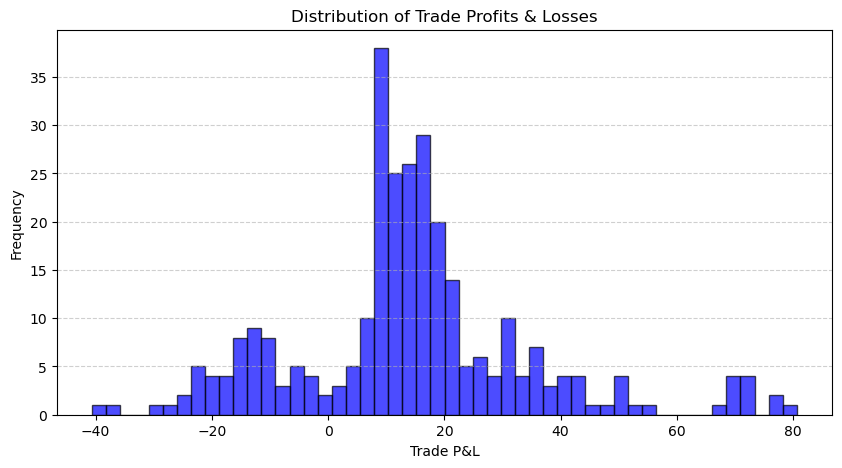

In [49]:
# plot distribution of profits per trades

closed_trades = [trade for trade in e.strategy.trades if trade.role in ['exit', 'cover']]

pnl_list = [trade.pnl for trade in closed_trades]

plt.figure(figsize=(10, 5))
plt.hist(pnl_list, bins=50, color='blue', alpha=0.7, edgecolor='black')
plt.xlabel("Trade P&L")
plt.ylabel("Frequency")
plt.title("Distribution of Trade Profits & Losses")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()

In [50]:
closed_trades

[<Trade: 2025-03-01 02:00:00 btc sell 0.01192322@84656.93 Role:exit PnL:8.517388811285338>,
 <Trade: 2025-03-01 03:00:00 btc sell 0.0001136100000000001@85240.46 Role:exit PnL:0.14738620073940106>,
 <Trade: 2025-03-01 05:00:00 btc buy 0.01171114@86190.01 Role:cover PnL:-11.090566070028672>,
 <Trade: 2025-03-01 22:00:00 btc buy 0.01172653@86076.86 Role:cover PnL:-11.6134504232708>,
 <Trade: 2025-03-01 23:00:00 btc buy 0.01172116@86116.35 Role:cover PnL:-12.071463683485977>,
 <Trade: 2025-03-02 00:00:00 btc buy 0.01172821@86064.53 Role:cover PnL:-11.470360784808653>,
 <Trade: 2025-03-02 01:00:00 btc buy 0.01173338@86026.62 Role:cover PnL:-11.030159872131048>,
 <Trade: 2025-03-02 04:00:00 btc buy 0.01175436@85873.07 Role:cover PnL:-8.672392918525084>,
 <Trade: 2025-03-02 06:00:00 btc buy 0.01174282@85957.51 Role:cover PnL:-9.144029269283013>,
 <Trade: 2025-03-02 07:00:00 btc buy 0.01169924@86277.65 Role:cover PnL:-12.859234000008719>,
 <Trade: 2025-03-02 08:00:00 btc buy 0.01170538@86232.4

In [51]:
time_label = [trade.idx for trade in closed_trades]
time_label

[Timestamp('2025-03-01 02:00:00'),
 Timestamp('2025-03-01 03:00:00'),
 Timestamp('2025-03-01 05:00:00'),
 Timestamp('2025-03-01 22:00:00'),
 Timestamp('2025-03-01 23:00:00'),
 Timestamp('2025-03-02 00:00:00'),
 Timestamp('2025-03-02 01:00:00'),
 Timestamp('2025-03-02 04:00:00'),
 Timestamp('2025-03-02 06:00:00'),
 Timestamp('2025-03-02 07:00:00'),
 Timestamp('2025-03-02 08:00:00'),
 Timestamp('2025-03-02 10:00:00'),
 Timestamp('2025-03-02 11:00:00'),
 Timestamp('2025-03-02 12:00:00'),
 Timestamp('2025-03-02 13:00:00'),
 Timestamp('2025-03-03 07:00:00'),
 Timestamp('2025-03-03 09:00:00'),
 Timestamp('2025-03-03 13:00:00'),
 Timestamp('2025-03-03 15:00:00'),
 Timestamp('2025-03-03 16:00:00'),
 Timestamp('2025-03-03 17:00:00'),
 Timestamp('2025-03-03 18:00:00'),
 Timestamp('2025-03-03 19:00:00'),
 Timestamp('2025-03-03 20:00:00'),
 Timestamp('2025-03-03 21:00:00'),
 Timestamp('2025-03-03 23:00:00'),
 Timestamp('2025-03-04 00:00:00'),
 Timestamp('2025-03-04 01:00:00'),
 Timestamp('2025-03-

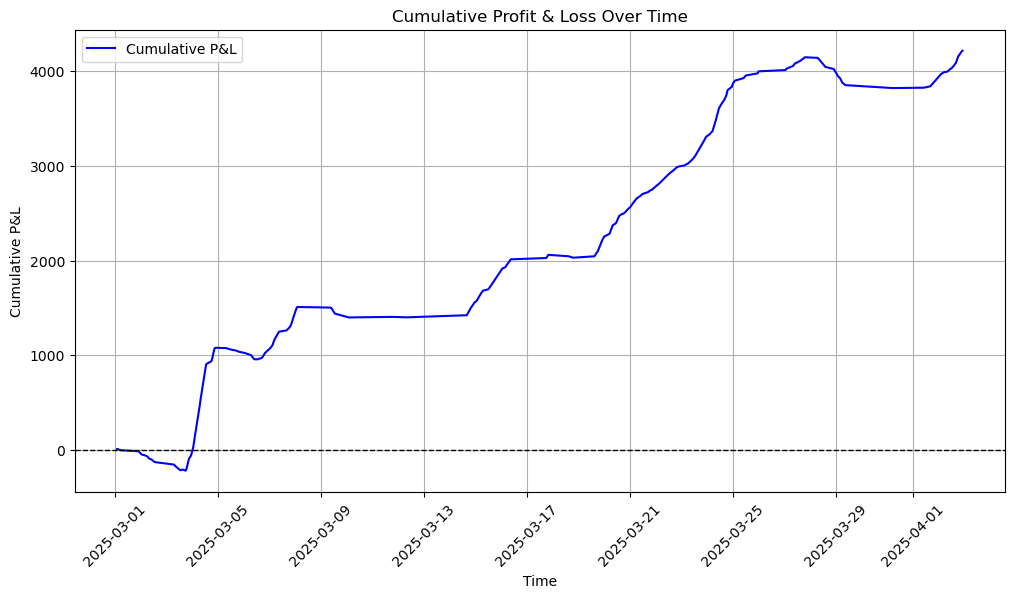

In [52]:
time_label_series = pd.Series(time_label)

# Compute cumulative P&L
cumulative_pnl = np.cumsum(pnl_list)

# Create a DataFrame to align P&L with time labels
pnl_df = pd.DataFrame({'time': time_label_series, 'cumulative_pnl': cumulative_pnl})
pnl_df.set_index('time', inplace=True)  # Set time as index

# Sort by time in case it's out of order
pnl_df.sort_index(inplace=True)

# Plot cumulative P&L over time
plt.figure(figsize=(12, 6))
plt.plot(pnl_df.index, pnl_df['cumulative_pnl'], label="Cumulative P&L", color="blue")
plt.axhline(0, color='black', linestyle='--', linewidth=1)  # Baseline at 0
plt.xlabel("Time")
plt.ylabel("Cumulative P&L")
plt.title("Cumulative Profit & Loss Over Time")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()
plt.grid()
plt.show()

In [42]:
# Define the parameter ranges
initial_cash_values = range(100_000, 750_000, 50_000)  # 100k to 700k in 50k steps
transaction_cost_values = [i/10000 for i in range(10, 101,10)]  # 0.001 to 0.01 (0.1% to 1%)

# Initialize results storage
results = []

# Run backtests for all combinations
for initial_cash in tqdm(initial_cash_values, desc="Initial Cash"):
    row = {}
    for transaction_cost in tqdm(transaction_cost_values, desc=f"Transaction Costs for ${initial_cash:,}", leave=False):
        # Create and run engine
        e = Engine(
            initial_cash=initial_cash,
            risk_free_rate=0.043,
            transaction_cost=transaction_cost,
            asset_type='cryptocurrencies'
        )
        e.add_data(test_frame)
        e.add_strategy(XGBoostStrategy(
            model=loaded_final_model,
            bet_size=best_params["bet_size"],
            initial_data=initial_test_frame,  # Pass initial data for sequencing
        ))

        stats = e.run()
        
        # Store results
        key = f"{transaction_cost*100:.2f}%"
        row[key] = (
            round(stats['Strategy Sharpe Ratio'], 2),
            round(stats['Buy & Hold Sharpe Ratio'], 2)
        )
    results.append(row)

# Convert results to DataFrame
df_results = pd.DataFrame(
    results,
    index=[f"${x:,}" for x in initial_cash_values]
)

# Display the results table
print("Sharpe Ratios (Strategy, Buy & Hold) for different parameters:")
print(df_results)


Initial Cash:   0%|          | 0/13 [00:00<?, ?it/s]
















100%|██████████| 798/798 [00:01<00:00, 452.99it/s]


Initial Portfolio Value: 100000
Holding Cash Value: 20597.885664698653
Final Positions Value: 82867.83885187497 , Final Size: 0.9942897799999996, Final Avg Cost: 83946.78138282688
Final Portfolio Value: 103465.72451657362
Buy & Hold Final Value: 98609.60878425048
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       3.47
Buy-and-Hold Total Return (%)            |      -1.39
Average Exposure to Asset (%)            |      50.78
Strategy CAGR (%)                        |      45.77
Buy & Hold CAGR (%)                      |      -6.58
Strategy Volatility (%)                  |       6.37
Buy & Hold Volatility (%)                |      12.80
Strategy Sharpe Ratio                    |       7.18
Buy & Hold Sharpe Ratio                  |      -0.52
Strategy Max Drawdown (%)                |      -5.21
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                


















100%|██████████| 798/798 [00:01<00:00, 465.33it/s]


Initial Portfolio Value: 100000
Holding Cash Value: 20939.05746008156
Final Positions Value: 81848.74981499994 , Final Size: 0.9820622399999994, Final Avg Cost: 84042.25843788018
Final Portfolio Value: 102787.8072750815
Buy & Hold Final Value: 98412.29095717198
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       2.79
Buy-and-Hold Total Return (%)            |      -1.59
Average Exposure to Asset (%)            |      50.93
Strategy CAGR (%)                        |      35.54
Buy & Hold CAGR (%)                      |      -6.58
Strategy Volatility (%)                  |       6.38
Buy & Hold Volatility (%)                |      12.80
Strategy Sharpe Ratio                    |       5.56
Buy & Hold Sharpe Ratio                  |      -0.52
Strategy Max Drawdown (%)                |      -5.46
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                  

















100%|██████████| 798/798 [00:01<00:00, 480.44it/s]


Initial Portfolio Value: 100000
Holding Cash Value: 20269.836322640214
Final Positions Value: 81848.74981499994 , Final Size: 0.9820622399999994, Final Avg Cost: 84126.11858613884
Final Portfolio Value: 102118.58613764016
Buy & Hold Final Value: 98215.17074434196
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       2.12
Buy-and-Hold Total Return (%)            |      -1.78
Average Exposure to Asset (%)            |      51.14
Strategy CAGR (%)                        |      26.10
Buy & Hold CAGR (%)                      |      -6.58
Strategy Volatility (%)                  |       6.41
Buy & Hold Volatility (%)                |      12.80
Strategy Sharpe Ratio                    |       4.07
Buy & Hold Sharpe Ratio                  |      -0.52
Strategy Max Drawdown (%)                |      -5.72
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                

















100%|██████████| 798/798 [00:01<00:00, 481.47it/s]


Initial Portfolio Value: 100000
Holding Cash Value: 20614.03611222195
Final Positions Value: 80846.29369031246 , Final Size: 0.9700342699999995, Final Avg Cost: 84202.57652166332
Final Portfolio Value: 101460.32980253441
Buy & Hold Final Value: 98018.2481457604
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       1.46
Buy-and-Hold Total Return (%)            |      -1.98
Average Exposure to Asset (%)            |      50.72
Strategy CAGR (%)                        |      17.39
Buy & Hold CAGR (%)                      |      -6.58
Strategy Volatility (%)                  |       6.38
Buy & Hold Volatility (%)                |      12.80
Strategy Sharpe Ratio                    |       2.72
Buy & Hold Sharpe Ratio                  |      -0.52
Strategy Max Drawdown (%)                |      -5.92
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                  


















100%|██████████| 798/798 [00:01<00:00, 466.26it/s]


Initial Portfolio Value: 100000
Holding Cash Value: 20960.25437831381
Final Positions Value: 79825.47360374997 , Final Size: 0.9577859599999996, Final Avg Cost: 84299.61623754099
Final Portfolio Value: 100785.72798206378
Buy & Hold Final Value: 97821.52316142725
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       0.79
Buy-and-Hold Total Return (%)            |      -2.18
Average Exposure to Asset (%)            |      50.87
Strategy CAGR (%)                        |       9.04
Buy & Hold CAGR (%)                      |      -6.58
Strategy Volatility (%)                  |       6.39
Buy & Hold Volatility (%)                |      12.80
Strategy Sharpe Ratio                    |       1.41
Buy & Hold Sharpe Ratio                  |      -0.52
Strategy Max Drawdown (%)                |      -6.18
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                 

















100%|██████████| 798/798 [00:01<00:00, 468.03it/s]


Initial Portfolio Value: 100000
Holding Cash Value: 20293.05193306119
Final Positions Value: 79844.91603374996 , Final Size: 0.9580192399999996, Final Avg Cost: 84362.0680142511
Final Portfolio Value: 100137.96796681115
Buy & Hold Final Value: 97624.99579134259
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       0.14
Buy-and-Hold Total Return (%)            |      -2.38
Average Exposure to Asset (%)            |      50.66
Strategy CAGR (%)                        |       1.54
Buy & Hold CAGR (%)                      |      -6.58
Strategy Volatility (%)                  |       6.39
Buy & Hold Volatility (%)                |      12.80
Strategy Sharpe Ratio                    |       0.23
Buy & Hold Sharpe Ratio                  |      -0.52
Strategy Max Drawdown (%)                |      -6.38
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                  


















100%|██████████| 798/798 [00:01<00:00, 469.46it/s]


Initial Portfolio Value: 100000
Holding Cash Value: 20642.29859813822
Final Positions Value: 78812.54450343747 , Final Size: 0.9456323299999996, Final Avg Cost: 84459.66579173612
Final Portfolio Value: 99454.8431015757
Buy & Hold Final Value: 97428.66603550638
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      -0.55
Buy-and-Hold Total Return (%)            |      -2.57
Average Exposure to Asset (%)            |      50.79
Strategy CAGR (%)                        |      -5.87
Buy & Hold CAGR (%)                      |      -6.58
Strategy Volatility (%)                  |       6.40
Buy & Hold Volatility (%)                |      12.80
Strategy Sharpe Ratio                    |      -0.92
Buy & Hold Sharpe Ratio                  |      -0.52
Strategy Max Drawdown (%)                |      -6.64
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                   



















100%|██████████| 798/798 [00:01<00:00, 429.84it/s]


Initial Portfolio Value: 100000
Holding Cash Value: 19976.10581421125
Final Positions Value: 78817.31343281246 , Final Size: 0.9456895499999995, Final Avg Cost: 84543.47433793412
Final Portfolio Value: 98793.4192470237
Buy & Hold Final Value: 97232.53389391859
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      -1.21
Buy-and-Hold Total Return (%)            |      -2.77
Average Exposure to Asset (%)            |      50.86
Strategy CAGR (%)                        |     -12.56
Buy & Hold CAGR (%)                      |      -6.58
Strategy Volatility (%)                  |       6.41
Buy & Hold Volatility (%)                |      12.80
Strategy Sharpe Ratio                    |      -1.97
Buy & Hold Sharpe Ratio                  |      -0.52
Strategy Max Drawdown (%)                |      -6.90
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                   


















100%|██████████| 798/798 [00:01<00:00, 448.84it/s]


Initial Portfolio Value: 100000
Holding Cash Value: 20328.380304776216
Final Positions Value: 77815.93577624996 , Final Size: 0.9336745199999995, Final Avg Cost: 84618.60305405225
Final Portfolio Value: 98144.31608102618
Buy & Hold Final Value: 97036.59936657928
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      -1.86
Buy-and-Hold Total Return (%)            |      -2.96
Average Exposure to Asset (%)            |      50.58
Strategy CAGR (%)                        |     -18.71
Buy & Hold CAGR (%)                      |      -6.58
Strategy Volatility (%)                  |       6.40
Buy & Hold Volatility (%)                |      12.80
Strategy Sharpe Ratio                    |      -2.93
Buy & Hold Sharpe Ratio                  |      -0.52
Strategy Max Drawdown (%)                |      -7.11
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                 



















Initial Cash:   8%|▊         | 1/13 [00:17<03:30, 17.50s/it]

Initial Portfolio Value: 100000
Holding Cash Value: 20682.674369487147
Final Positions Value: 76785.46781718745 , Final Size: 0.9213104499999994, Final Avg Cost: 84715.02385722866
Final Portfolio Value: 97468.14218667461
Buy & Hold Final Value: 96840.86245348841
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      -2.53
Buy-and-Hold Total Return (%)            |      -3.16
Average Exposure to Asset (%)            |      50.71
Strategy CAGR (%)                        |     -24.70
Buy & Hold CAGR (%)                      |      -6.58
Strategy Volatility (%)                  |       6.41
Buy & Hold Volatility (%)                |      12.80
Strategy Sharpe Ratio                    |      -3.86
Buy & Hold Sharpe Ratio                  |      -0.52
Strategy Max Drawdown (%)                |      -7.38
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                 



















100%|██████████| 798/798 [00:01<00:00, 423.09it/s]


Initial Portfolio Value: 150000
Holding Cash Value: 30896.81138001199
Final Positions Value: 124301.77494656244 , Final Size: 1.4914348699999993, Final Avg Cost: 83946.78150657812
Final Portfolio Value: 155198.58632657444
Buy & Hold Final Value: 147914.4131763757
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       3.47
Buy-and-Hold Total Return (%)            |      -1.39
Average Exposure to Asset (%)            |      50.78
Strategy CAGR (%)                        |      45.77
Buy & Hold CAGR (%)                      |      -6.58
Strategy Volatility (%)                  |       6.37
Buy & Hold Volatility (%)                |      12.80
Strategy Sharpe Ratio                    |       7.18
Buy & Hold Sharpe Ratio                  |      -0.52
Strategy Max Drawdown (%)                |      -5.21
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                



















100%|██████████| 798/798 [00:01<00:00, 434.04it/s]


Initial Portfolio Value: 150000
Holding Cash Value: 31408.569071545895
Final Positions Value: 122773.14139124991 , Final Size: 1.473093559999999, Final Avg Cost: 84042.25860415377
Final Portfolio Value: 154181.7104627958
Buy & Hold Final Value: 147618.436435758
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       2.79
Buy-and-Hold Total Return (%)            |      -1.59
Average Exposure to Asset (%)            |      50.93
Strategy CAGR (%)                        |      35.54
Buy & Hold CAGR (%)                      |      -6.58
Strategy Volatility (%)                  |       6.38
Buy & Hold Volatility (%)                |      12.80
Strategy Sharpe Ratio                    |       5.56
Buy & Hold Sharpe Ratio                  |      -0.52
Strategy Max Drawdown (%)                |      -5.46
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                  



















100%|██████████| 798/798 [00:01<00:00, 420.95it/s]


Initial Portfolio Value: 150000
Holding Cash Value: 30404.73736384249
Final Positions Value: 122773.14139124991 , Final Size: 1.473093559999999, Final Avg Cost: 84126.11879502128
Final Portfolio Value: 153177.8787550924
Buy & Hold Final Value: 147322.75611651293
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       2.12
Buy-and-Hold Total Return (%)            |      -1.78
Average Exposure to Asset (%)            |      51.14
Strategy CAGR (%)                        |      26.10
Buy & Hold CAGR (%)                      |      -6.58
Strategy Volatility (%)                  |       6.41
Buy & Hold Volatility (%)                |      12.80
Strategy Sharpe Ratio                    |       4.07
Buy & Hold Sharpe Ratio                  |      -0.52
Strategy Max Drawdown (%)                |      -5.72
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                 





















100%|██████████| 798/798 [00:02<00:00, 391.84it/s]


Initial Portfolio Value: 150000
Holding Cash Value: 30921.03662539759
Final Positions Value: 121269.45762093736 , Final Size: 1.4550516099999984, Final Avg Cost: 84202.57677166257
Final Portfolio Value: 152190.49424633494
Buy & Hold Final Value: 147027.37221864058
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       1.46
Buy-and-Hold Total Return (%)            |      -1.98
Average Exposure to Asset (%)            |      50.72
Strategy CAGR (%)                        |      17.39
Buy & Hold CAGR (%)                      |      -6.58
Strategy Volatility (%)                  |       6.38
Buy & Hold Volatility (%)                |      12.80
Strategy Sharpe Ratio                    |       2.72
Buy & Hold Sharpe Ratio                  |      -0.52
Strategy Max Drawdown (%)                |      -5.92
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades               





















100%|██████████| 798/798 [00:02<00:00, 386.12it/s]


Initial Portfolio Value: 150000
Holding Cash Value: 31440.364436684915
Final Positions Value: 119738.22707437485 , Final Size: 1.4366791399999983, Final Avg Cost: 84299.61653272962
Final Portfolio Value: 151178.59151105976
Buy & Hold Final Value: 146732.28474214088
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       0.79
Buy-and-Hold Total Return (%)            |      -2.18
Average Exposure to Asset (%)            |      50.87
Strategy CAGR (%)                        |       9.04
Buy & Hold CAGR (%)                      |      -6.58
Strategy Volatility (%)                  |       6.39
Buy & Hold Volatility (%)                |      12.80
Strategy Sharpe Ratio                    |       1.41
Buy & Hold Sharpe Ratio                  |      -0.52
Strategy Max Drawdown (%)                |      -6.18
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades              




















100%|██████████| 798/798 [00:01<00:00, 401.14it/s]


Initial Portfolio Value: 150000
Holding Cash Value: 30439.560775305483
Final Positions Value: 119767.39071937487 , Final Size: 1.4370290599999984, Final Avg Cost: 84362.06833628974
Final Portfolio Value: 150206.95149468037
Buy & Hold Final Value: 146437.4936870139
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       0.14
Buy-and-Hold Total Return (%)            |      -2.38
Average Exposure to Asset (%)            |      50.66
Strategy CAGR (%)                        |       1.54
Buy & Hold CAGR (%)                      |      -6.58
Strategy Volatility (%)                  |       6.39
Buy & Hold Volatility (%)                |      12.80
Strategy Sharpe Ratio                    |       0.23
Buy & Hold Sharpe Ratio                  |      -0.52
Strategy Max Drawdown (%)                |      -6.38
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades               





















100%|██████████| 798/798 [00:02<00:00, 379.33it/s]


Initial Portfolio Value: 150000
Holding Cash Value: 30963.43118149119
Final Positions Value: 118218.83300718736 , Final Size: 1.4184486899999984, Final Avg Cost: 84459.66615796777
Final Portfolio Value: 149182.26418867856
Buy & Hold Final Value: 146142.99905325955
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      -0.55
Buy-and-Hold Total Return (%)            |      -2.57
Average Exposure to Asset (%)            |      50.79
Strategy CAGR (%)                        |      -5.87
Buy & Hold CAGR (%)                      |      -6.58
Strategy Volatility (%)                  |       6.40
Buy & Hold Volatility (%)                |      12.80
Strategy Sharpe Ratio                    |      -0.92
Buy & Hold Sharpe Ratio                  |      -0.52
Strategy Max Drawdown (%)                |      -6.64
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades               





















100%|██████████| 798/798 [00:02<00:00, 383.73it/s]


Initial Portfolio Value: 150000
Holding Cash Value: 29964.14116532287
Final Positions Value: 118225.98723468737 , Final Size: 1.4185345299999985, Final Avg Cost: 84543.47474566643
Final Portfolio Value: 148190.12840001023
Buy & Hold Final Value: 145848.8008408779
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      -1.21
Buy-and-Hold Total Return (%)            |      -2.77
Average Exposure to Asset (%)            |      50.86
Strategy CAGR (%)                        |     -12.56
Buy & Hold CAGR (%)                      |      -6.58
Strategy Volatility (%)                  |       6.41
Buy & Hold Volatility (%)                |      12.80
Strategy Sharpe Ratio                    |      -1.97
Buy & Hold Sharpe Ratio                  |      -0.52
Strategy Max Drawdown (%)                |      -6.90
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                





















100%|██████████| 798/798 [00:02<00:00, 386.07it/s]


Initial Portfolio Value: 150000
Holding Cash Value: 30492.553323035612
Final Positions Value: 116723.92033312484 , Final Size: 1.400511979999998, Final Avg Cost: 84618.60348582185
Final Portfolio Value: 147216.47365616047
Buy & Hold Final Value: 145554.8990498689
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      -1.86
Buy-and-Hold Total Return (%)            |      -2.96
Average Exposure to Asset (%)            |      50.58
Strategy CAGR (%)                        |     -18.71
Buy & Hold CAGR (%)                      |      -6.58
Strategy Volatility (%)                  |       6.40
Buy & Hold Volatility (%)                |      12.80
Strategy Sharpe Ratio                    |      -2.93
Buy & Hold Sharpe Ratio                  |      -0.52
Strategy Max Drawdown (%)                |      -7.11
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                





















Initial Cash:  15%|█▌        | 2/13 [00:37<03:29, 19.08s/it]

Initial Portfolio Value: 150000
Holding Cash Value: 31023.993996769746
Final Positions Value: 115178.21881124984 , Final Size: 1.381965879999998, Final Avg Cost: 84715.024325313
Final Portfolio Value: 146202.2128080196
Buy & Hold Final Value: 145261.2936802326
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      -2.53
Buy-and-Hold Total Return (%)            |      -3.16
Average Exposure to Asset (%)            |      50.71
Strategy CAGR (%)                        |     -24.70
Buy & Hold CAGR (%)                      |      -6.58
Strategy Volatility (%)                  |       6.41
Buy & Hold Volatility (%)                |      12.80
Strategy Sharpe Ratio                    |      -3.86
Buy & Hold Sharpe Ratio                  |      -0.52
Strategy Max Drawdown (%)                |      -7.38
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                   






















100%|██████████| 798/798 [00:02<00:00, 386.73it/s]


Initial Portfolio Value: 200000
Holding Cash Value: 41195.73957220991
Final Positions Value: 165735.70854093748 , Final Size: 1.9885799299999998, Final Avg Cost: 83946.7816098098
Final Portfolio Value: 206931.4481131474
Buy & Hold Final Value: 197219.21756850096
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       3.47
Buy-and-Hold Total Return (%)            |      -1.39
Average Exposure to Asset (%)            |      50.78
Strategy CAGR (%)                        |      45.77
Buy & Hold CAGR (%)                      |      -6.58
Strategy Volatility (%)                  |       6.37
Buy & Hold Volatility (%)                |      12.80
Strategy Sharpe Ratio                    |       7.18
Buy & Hold Sharpe Ratio                  |      -0.52
Strategy Max Drawdown (%)                |      -5.21
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                 





















100%|██████████| 798/798 [00:01<00:00, 399.89it/s]


Initial Portfolio Value: 200000
Holding Cash Value: 41878.08234663012
Final Positions Value: 163697.53130062498 , Final Size: 1.9641248599999996, Final Avg Cost: 84042.25874571776
Final Portfolio Value: 205575.61364725512
Buy & Hold Final Value: 196824.58191434396
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       2.79
Buy-and-Hold Total Return (%)            |      -1.59
Average Exposure to Asset (%)            |      50.93
Strategy CAGR (%)                        |      35.54
Buy & Hold CAGR (%)                      |      -6.58
Strategy Volatility (%)                  |       6.38
Buy & Hold Volatility (%)                |      12.80
Strategy Sharpe Ratio                    |       5.56
Buy & Hold Sharpe Ratio                  |      -0.52
Strategy Max Drawdown (%)                |      -5.46
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades               




















100%|██████████| 798/798 [00:01<00:00, 423.72it/s]


Initial Portfolio Value: 200000
Holding Cash Value: 40539.64008172629
Final Positions Value: 163697.53130062498 , Final Size: 1.9641248599999996, Final Avg Cost: 84126.1189793869
Final Portfolio Value: 204237.17138235125
Buy & Hold Final Value: 196430.34148868392
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       2.12
Buy-and-Hold Total Return (%)            |      -1.78
Average Exposure to Asset (%)            |      51.14
Strategy CAGR (%)                        |      26.10
Buy & Hold CAGR (%)                      |      -6.58
Strategy Volatility (%)                  |       6.41
Buy & Hold Volatility (%)                |      12.80
Strategy Sharpe Ratio                    |       4.07
Buy & Hold Sharpe Ratio                  |      -0.52
Strategy Max Drawdown (%)                |      -5.72
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                




















100%|██████████| 798/798 [00:01<00:00, 412.28it/s]


Initial Portfolio Value: 200000
Holding Cash Value: 41228.03967086922
Final Positions Value: 161692.61905124996 , Final Size: 1.9400689199999994, Final Avg Cost: 84202.57699132954
Final Portfolio Value: 202920.65872211917
Buy & Hold Final Value: 196036.4962915208
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       1.46
Buy-and-Hold Total Return (%)            |      -1.98
Average Exposure to Asset (%)            |      50.72
Strategy CAGR (%)                        |      17.39
Buy & Hold CAGR (%)                      |      -6.58
Strategy Volatility (%)                  |       6.38
Buy & Hold Volatility (%)                |      12.80
Strategy Sharpe Ratio                    |       2.72
Buy & Hold Sharpe Ratio                  |      -0.52
Strategy Max Drawdown (%)                |      -5.92
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                




















100%|██████████| 798/798 [00:01<00:00, 413.45it/s]


Initial Portfolio Value: 200000
Holding Cash Value: 41920.47621303237
Final Positions Value: 159650.97887812497 , Final Size: 1.9155722999999996, Final Avg Cost: 84299.6167909394
Final Portfolio Value: 201571.45509115735
Buy & Hold Final Value: 195643.0463228545
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       0.79
Buy-and-Hold Total Return (%)            |      -2.18
Average Exposure to Asset (%)            |      50.87
Strategy CAGR (%)                        |       9.04
Buy & Hold CAGR (%)                      |      -6.58
Strategy Volatility (%)                  |       6.39
Buy & Hold Volatility (%)                |      12.80
Strategy Sharpe Ratio                    |       1.41
Buy & Hold Sharpe Ratio                  |      -0.52
Strategy Max Drawdown (%)                |      -6.18
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                 




















100%|██████████| 798/798 [00:01<00:00, 415.05it/s]


Initial Portfolio Value: 200000
Holding Cash Value: 40586.072177647526
Final Positions Value: 159689.8629046875 , Final Size: 1.91603885, Final Avg Cost: 84362.06862733001
Final Portfolio Value: 200275.93508233503
Buy & Hold Final Value: 195249.99158268518
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       0.14
Buy-and-Hold Total Return (%)            |      -2.38
Average Exposure to Asset (%)            |      50.66
Strategy CAGR (%)                        |       1.54
Buy & Hold CAGR (%)                      |      -6.58
Strategy Volatility (%)                  |       6.39
Buy & Hold Volatility (%)                |      12.80
Strategy Sharpe Ratio                    |       0.23
Buy & Hold Sharpe Ratio                  |      -0.52
Strategy Max Drawdown (%)                |      -6.38
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                       




















100%|██████████| 798/798 [00:02<00:00, 386.28it/s]


Initial Portfolio Value: 200000
Holding Cash Value: 41284.5646726397
Final Positions Value: 157625.1206775 , Final Size: 1.89126504, Final Avg Cost: 84459.66648949211
Final Portfolio Value: 198909.6853501397
Buy & Hold Final Value: 194857.33207101276
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      -0.55
Buy-and-Hold Total Return (%)            |      -2.57
Average Exposure to Asset (%)            |      50.79
Strategy CAGR (%)                        |      -5.87
Buy & Hold CAGR (%)                      |      -6.58
Strategy Volatility (%)                  |       6.40
Buy & Hold Volatility (%)                |      12.80
Strategy Sharpe Ratio                    |      -0.92
Buy & Hold Sharpe Ratio                  |      -0.52
Strategy Max Drawdown (%)                |      -6.64
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                         |   




















100%|██████████| 798/798 [00:01<00:00, 416.63it/s]


Initial Portfolio Value: 200000
Holding Cash Value: 39952.17911476499
Final Positions Value: 157634.65853625003 , Final Size: 1.8913794800000003, Final Avg Cost: 84543.47511015854
Final Portfolio Value: 197586.83765101503
Buy & Hold Final Value: 194465.06778783718
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      -1.21
Buy-and-Hold Total Return (%)            |      -2.77
Average Exposure to Asset (%)            |      50.86
Strategy CAGR (%)                        |     -12.56
Buy & Hold CAGR (%)                      |      -6.58
Strategy Volatility (%)                  |       6.41
Buy & Hold Volatility (%)                |      12.80
Strategy Sharpe Ratio                    |      -1.97
Buy & Hold Sharpe Ratio                  |      -0.52
Strategy Max Drawdown (%)                |      -6.90
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades               



















100%|██████████| 798/798 [00:01<00:00, 421.60it/s]


Initial Portfolio Value: 200000
Holding Cash Value: 40656.728953535734
Final Positions Value: 155631.90238968757 , Final Size: 1.8673494100000008, Final Avg Cost: 84618.60387301914
Final Portfolio Value: 196288.6313432233
Buy & Hold Final Value: 194073.19873315856
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      -1.86
Buy-and-Hold Total Return (%)            |      -2.96
Average Exposure to Asset (%)            |      50.58
Strategy CAGR (%)                        |     -18.71
Buy & Hold CAGR (%)                      |      -6.58
Strategy Volatility (%)                  |       6.40
Buy & Hold Volatility (%)                |      12.80
Strategy Sharpe Ratio                    |      -2.93
Buy & Hold Sharpe Ratio                  |      -0.52
Strategy Max Drawdown (%)                |      -7.11
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades               





















Initial Cash:  23%|██▎       | 3/13 [00:57<03:13, 19.39s/it]

Initial Portfolio Value: 200000
Holding Cash Value: 41365.315411379175
Final Positions Value: 153570.96813843754 , Final Size: 1.8426212900000005, Final Avg Cost: 84715.0247540882
Final Portfolio Value: 194936.28354981673
Buy & Hold Final Value: 193681.72490697683
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      -2.53
Buy-and-Hold Total Return (%)            |      -3.16
Average Exposure to Asset (%)            |      50.71
Strategy CAGR (%)                        |     -24.70
Buy & Hold CAGR (%)                      |      -6.58
Strategy Volatility (%)                  |       6.41
Buy & Hold Volatility (%)                |      12.80
Strategy Sharpe Ratio                    |      -3.86
Buy & Hold Sharpe Ratio                  |      -0.52
Strategy Max Drawdown (%)                |      -7.38
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades               




















100%|██████████| 798/798 [00:01<00:00, 408.71it/s]


Initial Portfolio Value: 250000
Holding Cash Value: 51494.67595575298
Final Positions Value: 207169.63380093747 , Final Size: 2.4857248899999997, Final Avg Cost: 83946.78163066306
Final Portfolio Value: 258664.30975669046
Buy & Hold Final Value: 246524.02196062615
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       3.47
Buy-and-Hold Total Return (%)            |      -1.39
Average Exposure to Asset (%)            |      50.78
Strategy CAGR (%)                        |      45.77
Buy & Hold CAGR (%)                      |      -6.58
Strategy Volatility (%)                  |       6.37
Buy & Hold Volatility (%)                |      12.80
Strategy Sharpe Ratio                    |       7.18
Buy & Hold Sharpe Ratio                  |      -0.52
Strategy Max Drawdown (%)                |      -5.21
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades               





















100%|██████████| 798/798 [00:02<00:00, 383.38it/s]


Initial Portfolio Value: 250000
Holding Cash Value: 52347.60463984181
Final Positions Value: 204621.9120421875 , Final Size: 2.45515605, Final Avg Cost: 84042.25881077717
Final Portfolio Value: 256969.5166820293
Buy & Hold Final Value: 246030.72739292996
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       2.79
Buy-and-Hold Total Return (%)            |      -1.59
Average Exposure to Asset (%)            |      50.93
Strategy CAGR (%)                        |      35.54
Buy & Hold CAGR (%)                      |      -6.58
Strategy Volatility (%)                  |       6.38
Buy & Hold Volatility (%)                |      12.80
Strategy Sharpe Ratio                    |       5.56
Buy & Hold Sharpe Ratio                  |      -0.52
Strategy Max Drawdown (%)                |      -5.46
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                         




















100%|██████████| 798/798 [00:01<00:00, 408.73it/s]


Initial Portfolio Value: 250000
Holding Cash Value: 50674.551818195294
Final Positions Value: 204621.9120421875 , Final Size: 2.45515605, Final Avg Cost: 84126.11908717976
Final Portfolio Value: 255296.4638603828
Buy & Hold Final Value: 245537.9268608549
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       2.12
Buy-and-Hold Total Return (%)            |      -1.78
Average Exposure to Asset (%)            |      51.14
Strategy CAGR (%)                        |      26.10
Buy & Hold CAGR (%)                      |      -6.58
Strategy Volatility (%)                  |       6.41
Buy & Hold Volatility (%)                |      12.80
Strategy Sharpe Ratio                    |       4.07
Buy & Hold Sharpe Ratio                  |      -0.52
Strategy Max Drawdown (%)                |      -5.72
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                         





















100%|██████████| 798/798 [00:02<00:00, 375.18it/s]


Initial Portfolio Value: 250000
Holding Cash Value: 51535.05089283033
Final Positions Value: 202115.7721471875 , Final Size: 2.42508613, Final Avg Cost: 84202.57713202464
Final Portfolio Value: 253650.82304001783
Buy & Hold Final Value: 245045.62036440097
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       1.46
Buy-and-Hold Total Return (%)            |      -1.98
Average Exposure to Asset (%)            |      50.72
Strategy CAGR (%)                        |      17.39
Buy & Hold CAGR (%)                      |      -6.58
Strategy Volatility (%)                  |       6.38
Buy & Hold Volatility (%)                |      12.80
Strategy Sharpe Ratio                    |       2.72
Buy & Hold Sharpe Ratio                  |      -0.52
Strategy Max Drawdown (%)                |      -5.92
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                        




















100%|██████████| 798/798 [00:01<00:00, 407.52it/s]


Initial Portfolio Value: 250000
Holding Cash Value: 52400.59699370793
Final Positions Value: 199563.7215140625 , Final Size: 2.39446535, Final Avg Cost: 84299.61697625661
Final Portfolio Value: 251964.31850777043
Buy & Hold Final Value: 244553.80790356817
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       0.79
Buy-and-Hold Total Return (%)            |      -2.18
Average Exposure to Asset (%)            |      50.87
Strategy CAGR (%)                        |       9.04
Buy & Hold CAGR (%)                      |      -6.58
Strategy Volatility (%)                  |       6.39
Buy & Hold Volatility (%)                |      12.80
Strategy Sharpe Ratio                    |       1.41
Buy & Hold Sharpe Ratio                  |      -0.52
Strategy Max Drawdown (%)                |      -6.18
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                        




















100%|██████████| 798/798 [00:01<00:00, 404.07it/s]


Initial Portfolio Value: 250000
Holding Cash Value: 50732.5909105736
Final Positions Value: 199612.32758906248 , Final Size: 2.39504855, Final Avg Cost: 84362.06883686257
Final Portfolio Value: 250344.9184996361
Buy & Hold Final Value: 244062.48947835647
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       0.14
Buy-and-Hold Total Return (%)            |      -2.38
Average Exposure to Asset (%)            |      50.66
Strategy CAGR (%)                        |       1.54
Buy & Hold CAGR (%)                      |      -6.58
Strategy Volatility (%)                  |       6.39
Buy & Hold Volatility (%)                |      12.80
Strategy Sharpe Ratio                    |       0.23
Buy & Hold Sharpe Ratio                  |      -0.52
Strategy Max Drawdown (%)                |      -6.38
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                         





















100%|██████████| 798/798 [00:02<00:00, 397.35it/s]


Initial Portfolio Value: 250000
Holding Cash Value: 51605.70800533518
Final Positions Value: 197031.3983465625 , Final Size: 2.36408127, Final Avg Cost: 84459.66673838161
Final Portfolio Value: 248637.10635189767
Buy & Hold Final Value: 243571.6650887659
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      -0.55
Buy-and-Hold Total Return (%)            |      -2.57
Average Exposure to Asset (%)            |      50.79
Strategy CAGR (%)                        |      -5.87
Buy & Hold CAGR (%)                      |      -6.58
Strategy Volatility (%)                  |       6.40
Buy & Hold Volatility (%)                |      12.80
Strategy Sharpe Ratio                    |      -0.92
Buy & Hold Sharpe Ratio                  |      -0.52
Strategy Max Drawdown (%)                |      -6.64
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                         





















100%|██████████| 798/798 [00:02<00:00, 398.64it/s]


Initial Portfolio Value: 250000
Holding Cash Value: 49940.22522873818
Final Positions Value: 197043.3215034375 , Final Size: 2.36422433, Final Avg Cost: 84543.47539906608
Final Portfolio Value: 246983.5467321757
Buy & Hold Final Value: 243081.3347347965
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      -1.21
Buy-and-Hold Total Return (%)            |      -2.77
Average Exposure to Asset (%)            |      50.86
Strategy CAGR (%)                        |     -12.56
Buy & Hold CAGR (%)                      |      -6.58
Strategy Volatility (%)                  |       6.41
Buy & Hold Volatility (%)                |      12.80
Strategy Sharpe Ratio                    |      -1.97
Buy & Hold Sharpe Ratio                  |      -0.52
Strategy Max Drawdown (%)                |      -6.90
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                         |




















100%|██████████| 798/798 [00:01<00:00, 412.18it/s]


Initial Portfolio Value: 250000
Holding Cash Value: 50820.911900513995
Final Positions Value: 194539.87694531246 , Final Size: 2.3341867499999993, Final Avg Cost: 84618.60418223504
Final Portfolio Value: 245360.78884582646
Buy & Hold Final Value: 242591.4984164482
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      -1.86
Buy-and-Hold Total Return (%)            |      -2.96
Average Exposure to Asset (%)            |      50.58
Strategy CAGR (%)                        |     -18.71
Buy & Hold CAGR (%)                      |      -6.58
Strategy Volatility (%)                  |       6.40
Buy & Hold Volatility (%)                |      12.80
Strategy Sharpe Ratio                    |      -2.93
Buy & Hold Sharpe Ratio                  |      -0.52
Strategy Max Drawdown (%)                |      -7.11
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades               




















Initial Cash:  31%|███       | 4/13 [01:17<02:57, 19.67s/it]

Initial Portfolio Value: 250000
Holding Cash Value: 51706.64666245713
Final Positions Value: 191963.70746437495 , Final Size: 2.3032765799999995, Final Avg Cost: 84715.02510208123
Final Portfolio Value: 243670.3541268321
Buy & Hold Final Value: 242102.156133721
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      -2.53
Buy-and-Hold Total Return (%)            |      -3.16
Average Exposure to Asset (%)            |      50.71
Strategy CAGR (%)                        |     -24.70
Buy & Hold CAGR (%)                      |      -6.58
Strategy Volatility (%)                  |       6.41
Buy & Hold Volatility (%)                |      12.80
Strategy Sharpe Ratio                    |      -3.86
Buy & Hold Sharpe Ratio                  |      -0.52
Strategy Max Drawdown (%)                |      -7.38
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                  





















100%|██████████| 798/798 [00:02<00:00, 398.04it/s]


Initial Portfolio Value: 300000
Holding Cash Value: 61793.62642237076
Final Positions Value: 248603.54572593738 , Final Size: 2.9828696899999985, Final Avg Cost: 83946.78163725637
Final Portfolio Value: 310397.17214830813
Buy & Hold Final Value: 295828.8263527514
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       3.47
Buy-and-Hold Total Return (%)            |      -1.39
Average Exposure to Asset (%)            |      50.78
Strategy CAGR (%)                        |      45.77
Buy & Hold CAGR (%)                      |      -6.58
Strategy Volatility (%)                  |       6.37
Buy & Hold Volatility (%)                |      12.80
Strategy Sharpe Ratio                    |       7.18
Buy & Hold Sharpe Ratio                  |      -0.52
Strategy Max Drawdown (%)                |      -5.21
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                





















100%|██████████| 798/798 [00:02<00:00, 387.25it/s]


Initial Portfolio Value: 300000
Holding Cash Value: 62817.14100540802
Final Positions Value: 245546.27944874982 , Final Size: 2.946187079999998, Final Avg Cost: 84042.25886132108
Final Portfolio Value: 308363.42045415787
Buy & Hold Final Value: 295236.872871516
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       2.79
Buy-and-Hold Total Return (%)            |      -1.59
Average Exposure to Asset (%)            |      50.93
Strategy CAGR (%)                        |      35.54
Buy & Hold CAGR (%)                      |      -6.58
Strategy Volatility (%)                  |       6.38
Buy & Hold Volatility (%)                |      12.80
Strategy Sharpe Ratio                    |       5.56
Buy & Hold Sharpe Ratio                  |      -0.52
Strategy Max Drawdown (%)                |      -5.46
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                  





















100%|██████████| 798/798 [00:01<00:00, 402.00it/s]


Initial Portfolio Value: 300000
Holding Cash Value: 60809.47761629605
Final Positions Value: 245546.27944874982 , Final Size: 2.946187079999998, Final Avg Cost: 84126.1191805425
Final Portfolio Value: 306355.7570650459
Buy & Hold Final Value: 294645.51223302586
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       2.12
Buy-and-Hold Total Return (%)            |      -1.78
Average Exposure to Asset (%)            |      51.14
Strategy CAGR (%)                        |      26.10
Buy & Hold CAGR (%)                      |      -6.58
Strategy Volatility (%)                  |       6.41
Buy & Hold Volatility (%)                |      12.80
Strategy Sharpe Ratio                    |       4.07
Buy & Hold Sharpe Ratio                  |      -0.52
Strategy Max Drawdown (%)                |      -5.72
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                  





















100%|██████████| 798/798 [00:02<00:00, 392.26it/s]


Initial Portfolio Value: 300000
Holding Cash Value: 61842.07700825446
Final Positions Value: 242538.91107468723 , Final Size: 2.9101031699999966, Final Avg Cost: 84202.5772562525
Final Portfolio Value: 304380.9880829417
Buy & Hold Final Value: 294054.74443728116
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       1.46
Buy-and-Hold Total Return (%)            |      -1.98
Average Exposure to Asset (%)            |      50.72
Strategy CAGR (%)                        |      17.39
Buy & Hold CAGR (%)                      |      -6.58
Strategy Volatility (%)                  |       6.38
Buy & Hold Volatility (%)                |      12.80
Strategy Sharpe Ratio                    |       2.72
Buy & Hold Sharpe Ratio                  |      -0.52
Strategy Max Drawdown (%)                |      -5.92
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                 




















100%|██████████| 798/798 [00:01<00:00, 405.80it/s]


Initial Portfolio Value: 300000
Holding Cash Value: 62880.73265796374
Final Positions Value: 239476.4499815622 , Final Size: 2.8733582299999965, Final Avg Cost: 84299.61714446472
Final Portfolio Value: 302357.18263952597
Buy & Hold Final Value: 293464.56948428176
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       0.79
Buy-and-Hold Total Return (%)            |      -2.18
Average Exposure to Asset (%)            |      50.87
Strategy CAGR (%)                        |       9.04
Buy & Hold CAGR (%)                      |      -6.58
Strategy Volatility (%)                  |       6.39
Buy & Hold Volatility (%)                |      12.80
Strategy Sharpe Ratio                    |       1.41
Buy & Hold Sharpe Ratio                  |      -0.52
Strategy Max Drawdown (%)                |      -6.18
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                





















100%|██████████| 798/798 [00:02<00:00, 393.03it/s]


Initial Portfolio Value: 300000
Holding Cash Value: 60879.12536233929
Final Positions Value: 239534.77727156223 , Final Size: 2.8740580699999967, Final Avg Cost: 84362.06902727863
Final Portfolio Value: 300413.9026339015
Buy & Hold Final Value: 292874.9873740278
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       0.14
Buy-and-Hold Total Return (%)            |      -2.38
Average Exposure to Asset (%)            |      50.66
Strategy CAGR (%)                        |       1.54
Buy & Hold CAGR (%)                      |      -6.58
Strategy Volatility (%)                  |       6.39
Buy & Hold Volatility (%)                |      12.80
Strategy Sharpe Ratio                    |       0.23
Buy & Hold Sharpe Ratio                  |      -0.52
Strategy Max Drawdown (%)                |      -6.38
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                 





















100%|██████████| 798/798 [00:01<00:00, 403.56it/s]


Initial Portfolio Value: 300000
Holding Cash Value: 61926.86536551115
Final Positions Value: 236437.66268062472 , Final Size: 2.8368973399999966, Final Avg Cost: 84459.66697321867
Final Portfolio Value: 298364.52804613585
Buy & Hold Final Value: 292285.9981065191
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      -0.55
Buy-and-Hold Total Return (%)            |      -2.57
Average Exposure to Asset (%)            |      50.79
Strategy CAGR (%)                        |      -5.87
Buy & Hold CAGR (%)                      |      -6.58
Strategy Volatility (%)                  |       6.40
Buy & Hold Volatility (%)                |      12.80
Strategy Sharpe Ratio                    |      -0.92
Buy & Hold Sharpe Ratio                  |      -0.52
Strategy Max Drawdown (%)                |      -6.64
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                




















100%|██████████| 798/798 [00:01<00:00, 404.22it/s]


Initial Portfolio Value: 300000
Holding Cash Value: 59928.28619664273
Final Positions Value: 236451.97030218726 , Final Size: 2.837069009999997, Final Avg Cost: 84543.47567093198
Final Portfolio Value: 296380.25649883
Buy & Hold Final Value: 291697.6016817558
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      -1.21
Buy-and-Hold Total Return (%)            |      -2.77
Average Exposure to Asset (%)            |      50.86
Strategy CAGR (%)                        |     -12.56
Buy & Hold CAGR (%)                      |      -6.58
Strategy Volatility (%)                  |       6.41
Buy & Hold Volatility (%)                |      12.80
Strategy Sharpe Ratio                    |      -1.97
Buy & Hold Sharpe Ratio                  |      -0.52
Strategy Max Drawdown (%)                |      -6.90
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                    




















100%|██████████| 798/798 [00:02<00:00, 391.85it/s]


Initial Portfolio Value: 300000
Holding Cash Value: 60985.11053920164
Final Positions Value: 233447.83649906225 , Final Size: 2.801023909999997, Final Avg Cost: 84618.60447145707
Final Portfolio Value: 294432.9470382639
Buy & Hold Final Value: 291109.7980997378
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      -1.86
Buy-and-Hold Total Return (%)            |      -2.96
Average Exposure to Asset (%)            |      50.58
Strategy CAGR (%)                        |     -18.71
Buy & Hold CAGR (%)                      |      -6.58
Strategy Volatility (%)                  |       6.40
Buy & Hold Volatility (%)                |      12.80
Strategy Sharpe Ratio                    |      -2.93
Buy & Hold Sharpe Ratio                  |      -0.52
Strategy Max Drawdown (%)                |      -7.11
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                  




















Initial Cash:  38%|███▊      | 5/13 [01:37<02:38, 19.87s/it]

Initial Portfolio Value: 300000
Holding Cash Value: 62047.99107497919
Final Positions Value: 230356.43428874973 , Final Size: 2.763931719999997, Final Avg Cost: 84715.02543189995
Final Portfolio Value: 292404.4253637289
Buy & Hold Final Value: 290522.5873604652
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      -2.53
Buy-and-Hold Total Return (%)            |      -3.16
Average Exposure to Asset (%)            |      50.71
Strategy CAGR (%)                        |     -24.70
Buy & Hold CAGR (%)                      |      -6.58
Strategy Volatility (%)                  |       6.41
Buy & Hold Volatility (%)                |      12.80
Strategy Sharpe Ratio                    |      -3.86
Buy & Hold Sharpe Ratio                  |      -0.52
Strategy Max Drawdown (%)                |      -7.38
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                  




















100%|██████████| 798/798 [00:01<00:00, 403.34it/s]


Initial Portfolio Value: 350000
Holding Cash Value: 72092.55983352684
Final Positions Value: 290037.47431968764 , Final Size: 3.4800146900000013, Final Avg Cost: 83946.78168171276
Final Portfolio Value: 362130.0341532145
Buy & Hold Final Value: 345133.63074487663
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       3.47
Buy-and-Hold Total Return (%)            |      -1.39
Average Exposure to Asset (%)            |      50.78
Strategy CAGR (%)                        |      45.77
Buy & Hold CAGR (%)                      |      -6.58
Strategy Volatility (%)                  |       6.37
Buy & Hold Volatility (%)                |      12.80
Strategy Sharpe Ratio                    |       7.18
Buy & Hold Sharpe Ratio                  |      -0.52
Strategy Max Drawdown (%)                |      -5.21
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                




















100%|██████████| 798/798 [00:01<00:00, 413.29it/s]


Initial Portfolio Value: 350000
Holding Cash Value: 73286.66031071801
Final Positions Value: 286470.66352406255 , Final Size: 3.437218310000001, Final Avg Cost: 84042.25894908048
Final Portfolio Value: 359757.32383478055
Buy & Hold Final Value: 344443.01835010195
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       2.79
Buy-and-Hold Total Return (%)            |      -1.59
Average Exposure to Asset (%)            |      50.93
Strategy CAGR (%)                        |      35.54
Buy & Hold CAGR (%)                      |      -6.58
Strategy Volatility (%)                  |       6.38
Buy & Hold Volatility (%)                |      12.80
Strategy Sharpe Ratio                    |       5.56
Buy & Hold Sharpe Ratio                  |      -0.52
Strategy Max Drawdown (%)                |      -5.46
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                





















100%|██████████| 798/798 [00:02<00:00, 385.69it/s]


Initial Portfolio Value: 350000
Holding Cash Value: 70944.38634934847
Final Positions Value: 286470.66352406255 , Final Size: 3.437218310000001, Final Avg Cost: 84126.11931100478
Final Portfolio Value: 357415.049873411
Buy & Hold Final Value: 343753.0976051968
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       2.12
Buy-and-Hold Total Return (%)            |      -1.78
Average Exposure to Asset (%)            |      51.14
Strategy CAGR (%)                        |      26.10
Buy & Hold CAGR (%)                      |      -6.58
Strategy Volatility (%)                  |       6.41
Buy & Hold Volatility (%)                |      12.80
Strategy Sharpe Ratio                    |       4.07
Buy & Hold Sharpe Ratio                  |      -0.52
Strategy Max Drawdown (%)                |      -5.72
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                   





















100%|██████████| 798/798 [00:02<00:00, 395.39it/s]


Initial Portfolio Value: 350000
Holding Cash Value: 72149.08521128405
Final Positions Value: 282962.0675043751 , Final Size: 3.395120420000002, Final Avg Cost: 84202.57742170802
Final Portfolio Value: 355111.1527156592
Buy & Hold Final Value: 343063.86851016135
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       1.46
Buy-and-Hold Total Return (%)            |      -1.98
Average Exposure to Asset (%)            |      50.72
Strategy CAGR (%)                        |      17.39
Buy & Hold CAGR (%)                      |      -6.58
Strategy Volatility (%)                  |       6.38
Buy & Hold Volatility (%)                |      12.80
Strategy Sharpe Ratio                    |       2.72
Buy & Hold Sharpe Ratio                  |      -0.52
Strategy Max Drawdown (%)                |      -5.92
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                  




















100%|██████████| 798/798 [00:01<00:00, 403.24it/s]


Initial Portfolio Value: 350000
Holding Cash Value: 73360.84957597218
Final Positions Value: 279389.1967846877 , Final Size: 3.3522513300000023, Final Avg Cost: 84299.61734983152
Final Portfolio Value: 352750.0463606599
Buy & Hold Final Value: 342375.3310649954
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       0.79
Buy-and-Hold Total Return (%)            |      -2.18
Average Exposure to Asset (%)            |      50.87
Strategy CAGR (%)                        |       9.04
Buy & Hold CAGR (%)                      |      -6.58
Strategy Volatility (%)                  |       6.39
Buy & Hold Volatility (%)                |      12.80
Strategy Sharpe Ratio                    |       1.41
Buy & Hold Sharpe Ratio                  |      -0.52
Strategy Max Drawdown (%)                |      -6.18
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                  




















100%|██████████| 798/798 [00:02<00:00, 389.73it/s]


Initial Portfolio Value: 350000
Holding Cash Value: 71025.64189044513
Final Positions Value: 279457.2444562501 , Final Size: 3.3530678000000016, Final Avg Cost: 84362.06926129546
Final Portfolio Value: 350482.88634669525
Buy & Hold Final Value: 341687.4852696991
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       0.14
Buy-and-Hold Total Return (%)            |      -2.38
Average Exposure to Asset (%)            |      50.66
Strategy CAGR (%)                        |       1.54
Buy & Hold CAGR (%)                      |      -6.58
Strategy Volatility (%)                  |       6.39
Buy & Hold Volatility (%)                |      12.80
Strategy Sharpe Ratio                    |       0.23
Buy & Hold Sharpe Ratio                  |      -0.52
Strategy Max Drawdown (%)                |      -6.38
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                 




















100%|██████████| 798/798 [00:01<00:00, 409.20it/s]


Initial Portfolio Value: 350000
Holding Cash Value: 72248.00480286099
Final Positions Value: 275843.94451687514 , Final Size: 3.3097136200000015, Final Avg Cost: 84459.6672452102
Final Portfolio Value: 348091.9493197361
Buy & Hold Final Value: 341000.3311242723
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      -0.55
Buy-and-Hold Total Return (%)            |      -2.57
Average Exposure to Asset (%)            |      50.79
Strategy CAGR (%)                        |      -5.87
Buy & Hold CAGR (%)                      |      -6.58
Strategy Volatility (%)                  |       6.40
Buy & Hold Volatility (%)                |      12.80
Strategy Sharpe Ratio                    |      -0.92
Buy & Hold Sharpe Ratio                  |      -0.52
Strategy Max Drawdown (%)                |      -6.64
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                  




















100%|██████████| 798/798 [00:01<00:00, 414.91it/s]


Initial Portfolio Value: 350000
Holding Cash Value: 69916.3292400559
Final Positions Value: 275860.63660312514 , Final Size: 3.309913900000002, Final Avg Cost: 84543.47597990936
Final Portfolio Value: 345776.965843181
Buy & Hold Final Value: 340313.8686287151
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      -1.21
Buy-and-Hold Total Return (%)            |      -2.77
Average Exposure to Asset (%)            |      50.86
Strategy CAGR (%)                        |     -12.56
Buy & Hold CAGR (%)                      |      -6.58
Strategy Volatility (%)                  |       6.41
Buy & Hold Volatility (%)                |      12.80
Strategy Sharpe Ratio                    |      -1.97
Buy & Hold Sharpe Ratio                  |      -0.52
Strategy Max Drawdown (%)                |      -6.90
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                    




















100%|██████████| 798/798 [00:01<00:00, 421.21it/s]


Initial Portfolio Value: 350000
Holding Cash Value: 71149.2912477765
Final Positions Value: 272355.8135550001 , Final Size: 3.2678612800000013, Final Avg Cost: 84618.60480031584
Final Portfolio Value: 343505.1048027766
Buy & Hold Final Value: 339628.09778302745
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      -1.86
Buy-and-Hold Total Return (%)            |      -2.96
Average Exposure to Asset (%)            |      50.58
Strategy CAGR (%)                        |     -18.71
Buy & Hold CAGR (%)                      |      -6.58
Strategy Volatility (%)                  |       6.40
Buy & Hold Volatility (%)                |      12.80
Strategy Sharpe Ratio                    |      -2.93
Buy & Hold Sharpe Ratio                  |      -0.52
Strategy Max Drawdown (%)                |      -7.11
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                  





















Initial Cash:  46%|████▌     | 6/13 [01:57<02:19, 19.89s/it]

Initial Portfolio Value: 350000
Holding Cash Value: 72389.31839059193
Final Positions Value: 268749.17778187507 , Final Size: 3.2245870600000006, Final Avg Cost: 84715.0257986679
Final Portfolio Value: 341138.496172467
Buy & Hold Final Value: 338943.0185872094
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      -2.53
Buy-and-Hold Total Return (%)            |      -3.16
Average Exposure to Asset (%)            |      50.71
Strategy CAGR (%)                        |     -24.70
Buy & Hold CAGR (%)                      |      -6.58
Strategy Volatility (%)                  |       6.41
Buy & Hold Volatility (%)                |      12.80
Strategy Sharpe Ratio                    |      -3.86
Buy & Hold Sharpe Ratio                  |      -0.52
Strategy Max Drawdown (%)                |      -7.38
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                   




















100%|██████████| 798/798 [00:02<00:00, 393.12it/s]


Initial Portfolio Value: 400000
Holding Cash Value: 82391.46952648618
Final Positions Value: 331471.4262496875 , Final Size: 3.9771599699999998, Final Avg Cost: 83946.78179438037
Final Portfolio Value: 413862.8957761737
Buy & Hold Final Value: 394438.4351370019
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       3.47
Buy-and-Hold Total Return (%)            |      -1.39
Average Exposure to Asset (%)            |      50.78
Strategy CAGR (%)                        |      45.77
Buy & Hold CAGR (%)                      |      -6.58
Strategy Volatility (%)                  |       6.37
Buy & Hold Volatility (%)                |      12.80
Strategy Sharpe Ratio                    |       7.18
Buy & Hold Sharpe Ratio                  |      -0.52
Strategy Max Drawdown (%)                |      -5.21
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                  





















100%|██████████| 798/798 [00:02<00:00, 380.87it/s]


Initial Portfolio Value: 400000
Holding Cash Value: 83756.1558942554
Final Positions Value: 327395.07093562494 , Final Size: 3.928249819999999, Final Avg Cost: 84042.25910525146
Final Portfolio Value: 411151.2268298803
Buy & Hold Final Value: 393649.1638286879
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       2.79
Buy-and-Hold Total Return (%)            |      -1.59
Average Exposure to Asset (%)            |      50.93
Strategy CAGR (%)                        |      35.54
Buy & Hold CAGR (%)                      |      -6.58
Strategy Volatility (%)                  |       6.38
Buy & Hold Volatility (%)                |      12.80
Strategy Sharpe Ratio                    |       5.56
Buy & Hold Sharpe Ratio                  |      -0.52
Strategy Max Drawdown (%)                |      -5.46
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                   





















100%|██████████| 798/798 [00:02<00:00, 370.10it/s]


Initial Portfolio Value: 400000
Holding Cash Value: 81079.271357051
Final Positions Value: 327395.07093562494 , Final Size: 3.928249819999999, Final Avg Cost: 84126.11951000795
Final Portfolio Value: 408474.3422926759
Buy & Hold Final Value: 392860.68297736783
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       2.12
Buy-and-Hold Total Return (%)            |      -1.78
Average Exposure to Asset (%)            |      51.14
Strategy CAGR (%)                        |      26.10
Buy & Hold CAGR (%)                      |      -6.58
Strategy Volatility (%)                  |       6.41
Buy & Hold Volatility (%)                |      12.80
Strategy Sharpe Ratio                    |       4.07
Buy & Hold Sharpe Ratio                  |      -0.52
Strategy Max Drawdown (%)                |      -5.72
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                   





















100%|██████████| 798/798 [00:02<00:00, 389.44it/s]


Initial Portfolio Value: 400000
Holding Cash Value: 82456.07052794022
Final Positions Value: 323385.24643687496 , Final Size: 3.8801379399999996, Final Avg Cost: 84202.57765656718
Final Portfolio Value: 405841.3169648152
Buy & Hold Final Value: 392072.9925830416
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       1.46
Buy-and-Hold Total Return (%)            |      -1.98
Average Exposure to Asset (%)            |      50.72
Strategy CAGR (%)                        |      17.39
Buy & Hold CAGR (%)                      |      -6.58
Strategy Volatility (%)                  |       6.38
Buy & Hold Volatility (%)                |      12.80
Strategy Sharpe Ratio                    |       2.72
Buy & Hold Sharpe Ratio                  |      -0.52
Strategy Max Drawdown (%)                |      -5.92
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                 






















100%|██████████| 798/798 [00:02<00:00, 372.24it/s]


Initial Portfolio Value: 400000
Holding Cash Value: 83840.9444330906
Final Positions Value: 319301.9652571875 , Final Size: 3.83114469, Final Avg Cost: 84299.61762813033
Final Portfolio Value: 403142.9096902781
Buy & Hold Final Value: 391286.092645709
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       0.79
Buy-and-Hold Total Return (%)            |      -2.18
Average Exposure to Asset (%)            |      50.87
Strategy CAGR (%)                        |       9.04
Buy & Hold CAGR (%)                      |      -6.58
Strategy Volatility (%)                  |       6.39
Buy & Hold Volatility (%)                |      12.80
Strategy Sharpe Ratio                    |       1.41
Buy & Hold Sharpe Ratio                  |      -0.52
Strategy Max Drawdown (%)                |      -6.18
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                         |  





















100%|██████████| 798/798 [00:02<00:00, 394.54it/s]


Initial Portfolio Value: 400000
Holding Cash Value: 81172.1346815629
Final Positions Value: 319379.7349771876 , Final Size: 3.832077810000001, Final Avg Cost: 84362.06956939973
Final Portfolio Value: 400551.8696587505
Buy & Hold Final Value: 390499.98316537036
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       0.14
Buy-and-Hold Total Return (%)            |      -2.38
Average Exposure to Asset (%)            |      50.66
Strategy CAGR (%)                        |       1.54
Buy & Hold CAGR (%)                      |      -6.58
Strategy Volatility (%)                  |       6.39
Buy & Hold Volatility (%)                |      12.80
Strategy Sharpe Ratio                    |       0.23
Buy & Hold Sharpe Ratio                  |      -0.52
Strategy Max Drawdown (%)                |      -6.38
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                   





















100%|██████████| 798/798 [00:02<00:00, 398.87it/s]


Initial Portfolio Value: 400000
Holding Cash Value: 82569.12133916047
Final Positions Value: 315250.24885593756 , Final Size: 3.7825301700000007, Final Avg Cost: 84459.66759497847
Final Portfolio Value: 397819.37019509805
Buy & Hold Final Value: 389714.6641420255
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      -0.55
Buy-and-Hold Total Return (%)            |      -2.57
Average Exposure to Asset (%)            |      50.79
Strategy CAGR (%)                        |      -5.87
Buy & Hold CAGR (%)                      |      -6.58
Strategy Volatility (%)                  |       6.40
Buy & Hold Volatility (%)                |      12.80
Strategy Sharpe Ratio                    |      -0.92
Buy & Hold Sharpe Ratio                  |      -0.52
Strategy Max Drawdown (%)                |      -6.64
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                





















100%|██████████| 798/798 [00:02<00:00, 397.00it/s]


Initial Portfolio Value: 400000
Holding Cash Value: 79904.34937571385
Final Positions Value: 315269.3254068751 , Final Size: 3.7827590600000014, Final Avg Cost: 84543.47636685295
Final Portfolio Value: 395173.67478258896
Buy & Hold Final Value: 388930.13557567436
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      -1.21
Buy-and-Hold Total Return (%)            |      -2.77
Average Exposure to Asset (%)            |      50.86
Strategy CAGR (%)                        |     -12.56
Buy & Hold CAGR (%)                      |      -6.58
Strategy Volatility (%)                  |       6.41
Buy & Hold Volatility (%)                |      12.80
Strategy Sharpe Ratio                    |      -1.97
Buy & Hold Sharpe Ratio                  |      -0.52
Strategy Max Drawdown (%)                |      -6.90
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                




















100%|██████████| 798/798 [00:01<00:00, 409.54it/s]


Initial Portfolio Value: 400000
Holding Cash Value: 81313.44819818756
Final Positions Value: 311263.8139471876 , Final Size: 3.7346989300000013, Final Avg Cost: 84618.60521213546
Final Portfolio Value: 392577.2621453752
Buy & Hold Final Value: 388146.3974663171
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      -1.86
Buy-and-Hold Total Return (%)            |      -2.96
Average Exposure to Asset (%)            |      50.58
Strategy CAGR (%)                        |     -18.71
Buy & Hold CAGR (%)                      |      -6.58
Strategy Volatility (%)                  |       6.40
Buy & Hold Volatility (%)                |      12.80
Strategy Sharpe Ratio                    |      -2.93
Buy & Hold Sharpe Ratio                  |      -0.52
Strategy Max Drawdown (%)                |      -7.11
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                  





















Initial Cash:  54%|█████▍    | 7/13 [02:18<02:00, 20.14s/it]

Initial Portfolio Value: 400000
Holding Cash Value: 82730.62278802498
Final Positions Value: 307141.9437778126 , Final Size: 3.685242670000001, Final Avg Cost: 84715.02625172795
Final Portfolio Value: 389872.5665658376
Buy & Hold Final Value: 387363.44981395366
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      -2.53
Buy-and-Hold Total Return (%)            |      -3.16
Average Exposure to Asset (%)            |      50.71
Strategy CAGR (%)                        |     -24.70
Buy & Hold CAGR (%)                      |      -6.58
Strategy Volatility (%)                  |       6.41
Buy & Hold Volatility (%)                |      12.80
Strategy Sharpe Ratio                    |      -3.86
Buy & Hold Sharpe Ratio                  |      -0.52
Strategy Max Drawdown (%)                |      -7.38
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                  




















100%|██████████| 798/798 [00:01<00:00, 404.33it/s]


Initial Portfolio Value: 450000
Holding Cash Value: 92690.427974608
Final Positions Value: 372905.3306737507 , Final Size: 4.474304680000008, Final Avg Cost: 83946.78177654257
Final Portfolio Value: 465595.75864835875
Buy & Hold Final Value: 443743.2395291271
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       3.47
Buy-and-Hold Total Return (%)            |      -1.39
Average Exposure to Asset (%)            |      50.78
Strategy CAGR (%)                        |      45.77
Buy & Hold CAGR (%)                      |      -6.58
Strategy Volatility (%)                  |       6.37
Buy & Hold Volatility (%)                |      12.80
Strategy Sharpe Ratio                    |       7.18
Buy & Hold Sharpe Ratio                  |      -0.52
Strategy Max Drawdown (%)                |      -5.21
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                    




















100%|██████████| 798/798 [00:01<00:00, 405.85it/s]


Initial Portfolio Value: 450000
Holding Cash Value: 94225.70025110117
Final Positions Value: 368319.4308412507 , Final Size: 4.419280760000008, Final Avg Cost: 84042.2591307595
Final Portfolio Value: 462545.13109235186
Buy & Hold Final Value: 442855.30930727394
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       2.79
Buy-and-Hold Total Return (%)            |      -1.59
Average Exposure to Asset (%)            |      50.93
Strategy CAGR (%)                        |      35.54
Buy & Hold CAGR (%)                      |      -6.58
Strategy Volatility (%)                  |       6.38
Buy & Hold Volatility (%)                |      12.80
Strategy Sharpe Ratio                    |       5.56
Buy & Hold Sharpe Ratio                  |      -0.52
Strategy Max Drawdown (%)                |      -5.46
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                  




















100%|██████████| 798/798 [00:02<00:00, 395.63it/s]


Initial Portfolio Value: 450000
Holding Cash Value: 91214.20515620842
Final Positions Value: 368319.4308412507 , Final Size: 4.419280760000008, Final Avg Cost: 84126.11957825665
Final Portfolio Value: 459533.6359974591
Buy & Hold Final Value: 441968.2683495388
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       2.12
Buy-and-Hold Total Return (%)            |      -1.78
Average Exposure to Asset (%)            |      51.14
Strategy CAGR (%)                        |      26.10
Buy & Hold CAGR (%)                      |      -6.58
Strategy Volatility (%)                  |       6.41
Buy & Hold Volatility (%)                |      12.80
Strategy Sharpe Ratio                    |       4.07
Buy & Hold Sharpe Ratio                  |      -0.52
Strategy Max Drawdown (%)                |      -5.72
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                   




















100%|██████████| 798/798 [00:01<00:00, 408.43it/s]


Initial Portfolio Value: 450000
Holding Cash Value: 92763.10381164469
Final Positions Value: 363808.3786968758 , Final Size: 4.36515490000001, Final Avg Cost: 84202.57775732134
Final Portfolio Value: 456571.4825085205
Buy & Hold Final Value: 441082.11665592174
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       1.46
Buy-and-Hold Total Return (%)            |      -1.98
Average Exposure to Asset (%)            |      50.72
Strategy CAGR (%)                        |      17.39
Buy & Hold CAGR (%)                      |      -6.58
Strategy Volatility (%)                  |       6.38
Buy & Hold Volatility (%)                |      12.80
Strategy Sharpe Ratio                    |       2.72
Buy & Hold Sharpe Ratio                  |      -0.52
Strategy Max Drawdown (%)                |      -5.92
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                   




















100%|██████████| 798/798 [00:01<00:00, 405.62it/s]


Initial Portfolio Value: 450000
Holding Cash Value: 94321.08727456283
Final Positions Value: 359214.68705718825 , Final Size: 4.310037490000009, Final Avg Cost: 84299.61777207511
Final Portfolio Value: 453535.77433175105
Buy & Hold Final Value: 440196.85422642267
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       0.79
Buy-and-Hold Total Return (%)            |      -2.18
Average Exposure to Asset (%)            |      50.87
Strategy CAGR (%)                        |       9.04
Buy & Hold CAGR (%)                      |      -6.58
Strategy Volatility (%)                  |       6.39
Buy & Hold Volatility (%)                |      12.80
Strategy Sharpe Ratio                    |       1.41
Buy & Hold Sharpe Ratio                  |      -0.52
Strategy Max Drawdown (%)                |      -6.18
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                





















100%|██████████| 798/798 [00:02<00:00, 387.86it/s]


Initial Portfolio Value: 450000
Holding Cash Value: 91318.67631948175
Final Positions Value: 359302.17799218826 , Final Size: 4.311087250000009, Final Avg Cost: 84362.06973641254
Final Portfolio Value: 450620.85431167
Buy & Hold Final Value: 439312.4810610416
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       0.14
Buy-and-Hold Total Return (%)            |      -2.38
Average Exposure to Asset (%)            |      50.66
Strategy CAGR (%)                        |       1.54
Buy & Hold CAGR (%)                      |      -6.58
Strategy Volatility (%)                  |       6.39
Buy & Hold Volatility (%)                |      12.80
Strategy Sharpe Ratio                    |       0.23
Buy & Hold Sharpe Ratio                  |      -0.52
Strategy Max Drawdown (%)                |      -6.38
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                    





















100%|██████████| 798/798 [00:02<00:00, 383.44it/s]


Initial Portfolio Value: 450000
Holding Cash Value: 92890.28673076081
Final Positions Value: 354656.50568906317 , Final Size: 4.255346150000008, Final Avg Cost: 84459.66780321955
Final Portfolio Value: 447546.792419824
Buy & Hold Final Value: 438428.99715977866
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      -0.55
Buy-and-Hold Total Return (%)            |      -2.57
Average Exposure to Asset (%)            |      50.79
Strategy CAGR (%)                        |      -5.87
Buy & Hold CAGR (%)                      |      -6.58
Strategy Volatility (%)                  |       6.40
Buy & Hold Volatility (%)                |      12.80
Strategy Sharpe Ratio                    |      -0.92
Buy & Hold Sharpe Ratio                  |      -0.52
Strategy Max Drawdown (%)                |      -6.64
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                  




















100%|██████████| 798/798 [00:01<00:00, 408.65it/s]


Initial Portfolio Value: 450000
Holding Cash Value: 89892.4183887716
Final Positions Value: 354677.9667046882 , Final Size: 4.255603650000008, Final Avg Cost: 84543.47661228573
Final Portfolio Value: 444570.3850934598
Buy & Hold Final Value: 437546.40252263367
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      -1.21
Buy-and-Hold Total Return (%)            |      -2.77
Average Exposure to Asset (%)            |      50.86
Strategy CAGR (%)                        |     -12.56
Buy & Hold CAGR (%)                      |      -6.58
Strategy Volatility (%)                  |       6.41
Buy & Hold Volatility (%)                |      12.80
Strategy Sharpe Ratio                    |      -1.97
Buy & Hold Sharpe Ratio                  |      -0.52
Strategy Max Drawdown (%)                |      -6.90
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                   





















100%|██████████| 798/798 [00:02<00:00, 390.80it/s]


Initial Portfolio Value: 450000
Holding Cash Value: 91477.65489180009
Final Positions Value: 350171.76600000064 , Final Size: 4.201536000000008, Final Avg Cost: 84618.60547496236
Final Portfolio Value: 441649.4208918007
Buy & Hold Final Value: 436664.6971496067
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      -1.86
Buy-and-Hold Total Return (%)            |      -2.96
Average Exposure to Asset (%)            |      50.58
Strategy CAGR (%)                        |     -18.71
Buy & Hold CAGR (%)                      |      -6.58
Strategy Volatility (%)                  |       6.40
Buy & Hold Volatility (%)                |      12.80
Strategy Sharpe Ratio                    |      -2.93
Buy & Hold Sharpe Ratio                  |      -0.52
Strategy Max Drawdown (%)                |      -7.11
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                  





















Initial Cash:  62%|██████▏   | 8/13 [02:38<01:40, 20.16s/it]

Initial Portfolio Value: 450000
Holding Cash Value: 93071.97610406911
Final Positions Value: 345534.6622678134 , Final Size: 4.1458977100000105, Final Avg Cost: 84715.02655281231
Final Portfolio Value: 438606.6383718825
Buy & Hold Final Value: 435783.8810406978
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      -2.53
Buy-and-Hold Total Return (%)            |      -3.16
Average Exposure to Asset (%)            |      50.71
Strategy CAGR (%)                        |     -24.70
Buy & Hold CAGR (%)                      |      -6.58
Strategy Volatility (%)                  |       6.41
Buy & Hold Volatility (%)                |      12.80
Strategy Sharpe Ratio                    |      -3.86
Buy & Hold Sharpe Ratio                  |      -0.52
Strategy Max Drawdown (%)                |      -7.38
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                  





















100%|██████████| 798/798 [00:02<00:00, 397.55it/s]


Initial Portfolio Value: 500000
Holding Cash Value: 102989.3612764954
Final Positions Value: 414339.25926749985 , Final Size: 4.971449679999998, Final Avg Cost: 83946.78182649639
Final Portfolio Value: 517328.62054399523
Buy & Hold Final Value: 493048.0439212523
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       3.47
Buy-and-Hold Total Return (%)            |      -1.39
Average Exposure to Asset (%)            |      50.78
Strategy CAGR (%)                        |      45.77
Buy & Hold CAGR (%)                      |      -6.58
Strategy Volatility (%)                  |       6.37
Buy & Hold Volatility (%)                |      12.80
Strategy Sharpe Ratio                    |       7.18
Buy & Hold Sharpe Ratio                  |      -0.52
Strategy Max Drawdown (%)                |      -5.21
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                 




















100%|██████████| 798/798 [00:01<00:00, 406.56it/s]


Initial Portfolio Value: 500000
Holding Cash Value: 104695.2194456665
Final Positions Value: 409243.8149165624 , Final Size: 4.9103119899999985, Final Avg Cost: 84042.25922407304
Final Portfolio Value: 513939.03436222894
Buy & Hold Final Value: 492061.4547858599
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       2.79
Buy-and-Hold Total Return (%)            |      -1.59
Average Exposure to Asset (%)            |      50.93
Strategy CAGR (%)                        |      35.54
Buy & Hold CAGR (%)                      |      -6.58
Strategy Volatility (%)                  |       6.38
Buy & Hold Volatility (%)                |      12.80
Strategy Sharpe Ratio                    |       5.56
Buy & Hold Sharpe Ratio                  |      -0.52
Strategy Max Drawdown (%)                |      -5.46
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                 




















100%|██████████| 798/798 [00:01<00:00, 406.24it/s]


Initial Portfolio Value: 500000
Holding Cash Value: 101349.11377704043
Final Positions Value: 409243.8149165624 , Final Size: 4.9103119899999985, Final Avg Cost: 84126.11971435581
Final Portfolio Value: 510592.92869360285
Buy & Hold Final Value: 491075.8537217098
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       2.12
Buy-and-Hold Total Return (%)            |      -1.78
Average Exposure to Asset (%)            |      51.14
Strategy CAGR (%)                        |      26.10
Buy & Hold CAGR (%)                      |      -6.58
Strategy Volatility (%)                  |       6.41
Buy & Hold Volatility (%)                |      12.80
Strategy Sharpe Ratio                    |       4.07
Buy & Hold Sharpe Ratio                  |      -0.52
Strategy Max Drawdown (%)                |      -5.72
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                





















100%|██████████| 798/798 [00:02<00:00, 369.17it/s]


Initial Portfolio Value: 500000
Holding Cash Value: 103070.11190097645
Final Positions Value: 404231.53512656223 , Final Size: 4.850172149999997, Final Avg Cost: 84202.57792837692
Final Portfolio Value: 507301.6470275387
Buy & Hold Final Value: 490091.24072880193
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       1.46
Buy-and-Hold Total Return (%)            |      -1.98
Average Exposure to Asset (%)            |      50.72
Strategy CAGR (%)                        |      17.39
Buy & Hold CAGR (%)                      |      -6.58
Strategy Volatility (%)                  |       6.38
Buy & Hold Volatility (%)                |      12.80
Strategy Sharpe Ratio                    |       2.72
Buy & Hold Sharpe Ratio                  |      -0.52
Strategy Max Drawdown (%)                |      -5.92
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                




















100%|██████████| 798/798 [00:01<00:00, 418.97it/s]


Initial Portfolio Value: 500000
Holding Cash Value: 104801.20407739864
Final Positions Value: 399127.4338603123 , Final Size: 4.788930589999997, Final Avg Cost: 84299.61798398668
Final Portfolio Value: 503928.6379377109
Buy & Hold Final Value: 489107.61580713635
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       0.79
Buy-and-Hold Total Return (%)            |      -2.18
Average Exposure to Asset (%)            |      50.87
Strategy CAGR (%)                        |       9.04
Buy & Hold CAGR (%)                      |      -6.58
Strategy Volatility (%)                  |       6.39
Buy & Hold Volatility (%)                |      12.80
Strategy Sharpe Ratio                    |       1.41
Buy & Hold Sharpe Ratio                  |      -0.52
Strategy Max Drawdown (%)                |      -6.18
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                 





















100%|██████████| 798/798 [00:02<00:00, 397.87it/s]


Initial Portfolio Value: 500000
Holding Cash Value: 101465.19273093707
Final Positions Value: 399224.64517687476 , Final Size: 4.790096979999997, Final Avg Cost: 84362.06997656889
Final Portfolio Value: 500689.83790781186
Buy & Hold Final Value: 488124.97895671293
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       0.14
Buy-and-Hold Total Return (%)            |      -2.38
Average Exposure to Asset (%)            |      50.66
Strategy CAGR (%)                        |       1.54
Buy & Hold CAGR (%)                      |      -6.58
Strategy Volatility (%)                  |       6.39
Buy & Hold Volatility (%)                |      12.80
Strategy Sharpe Ratio                    |       0.23
Buy & Hold Sharpe Ratio                  |      -0.52
Strategy Max Drawdown (%)                |      -6.38
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades               




















100%|██████████| 798/798 [00:01<00:00, 411.25it/s]


Initial Portfolio Value: 500000
Holding Cash Value: 103211.42521365132
Final Positions Value: 394062.7883587497 , Final Size: 4.728162439999997, Final Avg Cost: 84459.66808379078
Final Portfolio Value: 497274.21357240103
Buy & Hold Final Value: 487143.3301775318
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      -0.55
Buy-and-Hold Total Return (%)            |      -2.57
Average Exposure to Asset (%)            |      50.79
Strategy CAGR (%)                        |      -5.87
Buy & Hold CAGR (%)                      |      -6.58
Strategy Volatility (%)                  |       6.40
Buy & Hold Volatility (%)                |      12.80
Strategy Sharpe Ratio                    |      -0.92
Buy & Hold Sharpe Ratio                  |      -0.52
Strategy Max Drawdown (%)                |      -6.64
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                 




















100%|██████████| 798/798 [00:01<00:00, 404.39it/s]


Initial Portfolio Value: 500000
Holding Cash Value: 99880.46047145798
Final Positions Value: 394086.63383906224 , Final Size: 4.728448549999997, Final Avg Cost: 84543.47693011063
Final Portfolio Value: 493967.0943105202
Buy & Hold Final Value: 486162.669469593
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      -1.21
Buy-and-Hold Total Return (%)            |      -2.77
Average Exposure to Asset (%)            |      50.86
Strategy CAGR (%)                        |     -12.56
Buy & Hold CAGR (%)                      |      -6.58
Strategy Volatility (%)                  |       6.41
Buy & Hold Volatility (%)                |      12.80
Strategy Sharpe Ratio                    |      -1.97
Buy & Hold Sharpe Ratio                  |      -0.52
Strategy Max Drawdown (%)                |      -6.90
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                   




















100%|██████████| 798/798 [00:02<00:00, 396.72it/s]


Initial Portfolio Value: 500000
Holding Cash Value: 101641.8346373363
Final Positions Value: 389079.7438893747 , Final Size: 4.668373379999997, Final Avg Cost: 84618.60581327205
Final Portfolio Value: 490721.57852671103
Buy & Hold Final Value: 485182.9968328964
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      -1.86
Buy-and-Hold Total Return (%)            |      -2.96
Average Exposure to Asset (%)            |      50.58
Strategy CAGR (%)                        |     -18.71
Buy & Hold CAGR (%)                      |      -6.58
Strategy Volatility (%)                  |       6.40
Buy & Hold Volatility (%)                |      12.80
Strategy Sharpe Ratio                    |      -2.93
Buy & Hold Sharpe Ratio                  |      -0.52
Strategy Max Drawdown (%)                |      -7.11
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                  





















Initial Cash:  69%|██████▉   | 9/13 [02:58<01:20, 20.14s/it]

Initial Portfolio Value: 500000
Holding Cash Value: 103413.3016155074
Final Positions Value: 383927.4074278122 , Final Size: 4.606553069999997, Final Avg Cost: 84715.02693125271
Final Portfolio Value: 487340.7090433196
Buy & Hold Final Value: 484204.312267442
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      -2.53
Buy-and-Hold Total Return (%)            |      -3.16
Average Exposure to Asset (%)            |      50.71
Strategy CAGR (%)                        |     -24.70
Buy & Hold CAGR (%)                      |      -6.58
Strategy Volatility (%)                  |       6.41
Buy & Hold Volatility (%)                |      12.80
Strategy Sharpe Ratio                    |      -3.86
Buy & Hold Sharpe Ratio                  |      -0.52
Strategy Max Drawdown (%)                |      -7.38
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                    






















100%|██████████| 798/798 [00:02<00:00, 365.95it/s]


Initial Portfolio Value: 550000
Holding Cash Value: 113288.29699353281
Final Positions Value: 455773.1853609378 , Final Size: 5.4685946500000036, Final Avg Cost: 83946.78186666773
Final Portfolio Value: 569061.4823544706
Buy & Hold Final Value: 542352.8483133775
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       3.47
Buy-and-Hold Total Return (%)            |      -1.39
Average Exposure to Asset (%)            |      50.78
Strategy CAGR (%)                        |      45.77
Buy & Hold CAGR (%)                      |      -6.58
Strategy Volatility (%)                  |       6.37
Buy & Hold Volatility (%)                |      12.80
Strategy Sharpe Ratio                    |       7.18
Buy & Hold Sharpe Ratio                  |      -0.52
Strategy Max Drawdown (%)                |      -5.21
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                 





















100%|██████████| 798/798 [00:02<00:00, 395.58it/s]


Initial Portfolio Value: 550000
Holding Cash Value: 115164.74024625504
Final Positions Value: 450168.1973250003 , Final Size: 5.401343200000004, Final Avg Cost: 84042.25930577739
Final Portfolio Value: 565332.9375712554
Buy & Hold Final Value: 541267.6002644459
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       2.79
Buy-and-Hold Total Return (%)            |      -1.59
Average Exposure to Asset (%)            |      50.93
Strategy CAGR (%)                        |      35.54
Buy & Hold CAGR (%)                      |      -6.58
Strategy Volatility (%)                  |       6.38
Buy & Hold Volatility (%)                |      12.80
Strategy Sharpe Ratio                    |       5.56
Buy & Hold Sharpe Ratio                  |      -0.52
Strategy Max Drawdown (%)                |      -5.46
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                  




















100%|██████████| 798/798 [00:01<00:00, 402.74it/s]


Initial Portfolio Value: 550000
Holding Cash Value: 111484.02402109493
Final Positions Value: 450168.1973250003 , Final Size: 5.401343200000004, Final Avg Cost: 84126.11983880828
Final Portfolio Value: 561652.2213460952
Buy & Hold Final Value: 540183.4390938808
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       2.12
Buy-and-Hold Total Return (%)            |      -1.78
Average Exposure to Asset (%)            |      51.14
Strategy CAGR (%)                        |      26.10
Buy & Hold CAGR (%)                      |      -6.58
Strategy Volatility (%)                  |       6.41
Buy & Hold Volatility (%)                |      12.80
Strategy Sharpe Ratio                    |       4.07
Buy & Hold Sharpe Ratio                  |      -0.52
Strategy Max Drawdown (%)                |      -5.72
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                  





















100%|██████████| 798/798 [00:02<00:00, 391.17it/s]


Initial Portfolio Value: 550000
Holding Cash Value: 113377.1224732845
Final Positions Value: 444654.68905593775 , Final Size: 5.335189370000003, Final Avg Cost: 84202.57808592939
Final Portfolio Value: 558031.8115292223
Buy & Hold Final Value: 539100.3648016822
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       1.46
Buy-and-Hold Total Return (%)            |      -1.98
Average Exposure to Asset (%)            |      50.72
Strategy CAGR (%)                        |      17.39
Buy & Hold CAGR (%)                      |      -6.58
Strategy Volatility (%)                  |       6.38
Buy & Hold Volatility (%)                |      12.80
Strategy Sharpe Ratio                    |       2.72
Buy & Hold Sharpe Ratio                  |      -0.52
Strategy Max Drawdown (%)                |      -5.92
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                  





















100%|██████████| 798/798 [00:02<00:00, 383.07it/s]


Initial Portfolio Value: 550000
Holding Cash Value: 115281.32420946808
Final Positions Value: 439040.17732968775 , Final Size: 5.267823650000003, Final Avg Cost: 84299.61818456724
Final Portfolio Value: 554321.5015391558
Buy & Hold Final Value: 538018.37738785
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       0.79
Buy-and-Hold Total Return (%)            |      -2.18
Average Exposure to Asset (%)            |      50.87
Strategy CAGR (%)                        |       9.04
Buy & Hold CAGR (%)                      |      -6.58
Strategy Volatility (%)                  |       6.39
Buy & Hold Volatility (%)                |      12.80
Strategy Sharpe Ratio                    |       1.41
Buy & Hold Sharpe Ratio                  |      -0.52
Strategy Max Drawdown (%)                |      -6.18
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                   






















100%|██████████| 798/798 [00:02<00:00, 379.38it/s]


Initial Portfolio Value: 550000
Holding Cash Value: 111611.71081630755
Final Positions Value: 439147.1106946878 , Final Size: 5.269106690000004, Final Avg Cost: 84362.07020385868
Final Portfolio Value: 550758.8215109954
Buy & Hold Final Value: 536937.4768523842
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       0.14
Buy-and-Hold Total Return (%)            |      -2.38
Average Exposure to Asset (%)            |      50.66
Strategy CAGR (%)                        |       1.54
Buy & Hold CAGR (%)                      |      -6.58
Strategy Volatility (%)                  |       6.39
Buy & Hold Volatility (%)                |      12.80
Strategy Sharpe Ratio                    |       0.23
Buy & Hold Sharpe Ratio                  |      -0.52
Strategy Max Drawdown (%)                |      -6.38
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                  





















100%|██████████| 798/798 [00:02<00:00, 392.74it/s]


Initial Portfolio Value: 550000
Holding Cash Value: 113532.5678998377
Final Positions Value: 433469.06686125026 , Final Size: 5.200978680000003, Final Avg Cost: 84459.6683509476
Final Portfolio Value: 547001.634761088
Buy & Hold Final Value: 535857.6631952849
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      -0.55
Buy-and-Hold Total Return (%)            |      -2.57
Average Exposure to Asset (%)            |      50.79
Strategy CAGR (%)                        |      -5.87
Buy & Hold CAGR (%)                      |      -6.58
Strategy Volatility (%)                  |       6.40
Buy & Hold Volatility (%)                |      12.80
Strategy Sharpe Ratio                    |      -0.92
Buy & Hold Sharpe Ratio                  |      -0.52
Strategy Max Drawdown (%)                |      -6.64
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                    





















100%|██████████| 798/798 [00:02<00:00, 385.76it/s]


Initial Portfolio Value: 550000
Holding Cash Value: 109868.50593996984
Final Positions Value: 433495.29763968784 , Final Size: 5.201293410000004, Final Avg Cost: 84543.4772357064
Final Portfolio Value: 543363.8035796577
Buy & Hold Final Value: 534778.9364165523
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      -1.21
Buy-and-Hold Total Return (%)            |      -2.77
Average Exposure to Asset (%)            |      50.86
Strategy CAGR (%)                        |     -12.56
Buy & Hold CAGR (%)                      |      -6.58
Strategy Volatility (%)                  |       6.41
Buy & Hold Volatility (%)                |      12.80
Strategy Sharpe Ratio                    |      -1.97
Buy & Hold Sharpe Ratio                  |      -0.52
Strategy Max Drawdown (%)                |      -6.90
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                  





















100%|██████████| 798/798 [00:02<00:00, 383.14it/s]


Initial Portfolio Value: 550000
Holding Cash Value: 111806.01693990087
Final Positions Value: 427987.7192784378 , Final Size: 5.135210730000003, Final Avg Cost: 84618.60614007492
Final Portfolio Value: 539793.7362183386
Buy & Hold Final Value: 533701.296516186
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      -1.86
Buy-and-Hold Total Return (%)            |      -2.96
Average Exposure to Asset (%)            |      50.58
Strategy CAGR (%)                        |     -18.71
Buy & Hold CAGR (%)                      |      -6.58
Strategy Volatility (%)                  |       6.40
Buy & Hold Volatility (%)                |      12.80
Strategy Sharpe Ratio                    |      -2.93
Buy & Hold Sharpe Ratio                  |      -0.52
Strategy Max Drawdown (%)                |      -7.11
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                   






















Initial Cash:  77%|███████▋  | 10/13 [03:19<01:01, 20.36s/it]

Initial Portfolio Value: 550000
Holding Cash Value: 113754.6322232184
Final Positions Value: 422320.1475871878 , Final Size: 5.067208370000004, Final Avg Cost: 84715.027297162
Final Portfolio Value: 536074.7798104063
Buy & Hold Final Value: 532624.7434941862
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      -2.53
Buy-and-Hold Total Return (%)            |      -3.16
Average Exposure to Asset (%)            |      50.71
Strategy CAGR (%)                        |     -24.70
Buy & Hold CAGR (%)                      |      -6.58
Strategy Volatility (%)                  |       6.41
Buy & Hold Volatility (%)                |      12.80
Strategy Sharpe Ratio                    |      -3.86
Buy & Hold Sharpe Ratio                  |      -0.52
Strategy Max Drawdown (%)                |      -7.38
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                     





















100%|██████████| 798/798 [00:02<00:00, 379.39it/s]


Initial Portfolio Value: 600000
Holding Cash Value: 123587.2276720961
Final Positions Value: 497207.1164549996 , Final Size: 5.965739679999995, Final Avg Cost: 83946.78191973583
Final Portfolio Value: 620794.3441270957
Buy & Hold Final Value: 591657.6527055028
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       3.47
Buy-and-Hold Total Return (%)            |      -1.39
Average Exposure to Asset (%)            |      50.78
Strategy CAGR (%)                        |      45.77
Buy & Hold CAGR (%)                      |      -6.58
Strategy Volatility (%)                  |       6.37
Buy & Hold Volatility (%)                |      12.80
Strategy Sharpe Ratio                    |       7.18
Buy & Hold Sharpe Ratio                  |      -0.52
Strategy Max Drawdown (%)                |      -5.21
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                   





















100%|██████████| 798/798 [00:02<00:00, 388.26it/s]


Initial Portfolio Value: 600000
Holding Cash Value: 125634.2568148034
Final Positions Value: 491092.58390062454 , Final Size: 5.892374459999995, Final Avg Cost: 84042.2594022336
Final Portfolio Value: 616726.8407154279
Buy & Hold Final Value: 590473.745743032
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       2.79
Buy-and-Hold Total Return (%)            |      -1.59
Average Exposure to Asset (%)            |      50.93
Strategy CAGR (%)                        |      35.54
Buy & Hold CAGR (%)                      |      -6.58
Strategy Volatility (%)                  |       6.38
Buy & Hold Volatility (%)                |      12.80
Strategy Sharpe Ratio                    |       5.56
Buy & Hold Sharpe Ratio                  |      -0.52
Strategy Max Drawdown (%)                |      -5.46
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                    





















100%|██████████| 798/798 [00:02<00:00, 384.91it/s]


Initial Portfolio Value: 600000
Holding Cash Value: 121618.9300132131
Final Positions Value: 491092.58390062454 , Final Size: 5.892374459999995, Final Avg Cost: 84126.11997803849
Final Portfolio Value: 612711.5139138376
Buy & Hold Final Value: 589291.0244660517
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       2.12
Buy-and-Hold Total Return (%)            |      -1.78
Average Exposure to Asset (%)            |      51.14
Strategy CAGR (%)                        |      26.10
Buy & Hold CAGR (%)                      |      -6.58
Strategy Volatility (%)                  |       6.41
Buy & Hold Volatility (%)                |      12.80
Strategy Sharpe Ratio                    |       4.07
Buy & Hold Sharpe Ratio                  |      -0.52
Strategy Max Drawdown (%)                |      -5.72
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                  




















100%|██████████| 798/798 [00:01<00:00, 410.97it/s]


Initial Portfolio Value: 600000
Holding Cash Value: 123684.12793120978
Final Positions Value: 485077.8479859368 , Final Size: 5.820206649999991, Final Avg Cost: 84202.57825990849
Final Portfolio Value: 608761.9759171465
Buy & Hold Final Value: 588109.4888745623
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       1.46
Buy-and-Hold Total Return (%)            |      -1.98
Average Exposure to Asset (%)            |      50.72
Strategy CAGR (%)                        |      17.39
Buy & Hold CAGR (%)                      |      -6.58
Strategy Volatility (%)                  |       6.38
Buy & Hold Volatility (%)                |      12.80
Strategy Sharpe Ratio                    |       2.72
Buy & Hold Sharpe Ratio                  |      -0.52
Strategy Max Drawdown (%)                |      -5.92
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                  





















100%|██████████| 798/798 [00:02<00:00, 368.26it/s]


Initial Portfolio Value: 600000
Holding Cash Value: 125761.4383782007
Final Positions Value: 478952.92663312424 , Final Size: 5.746716779999991, Final Avg Cost: 84299.61839964137
Final Portfolio Value: 604714.365011325
Buy & Hold Final Value: 586929.1389685635
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       0.79
Buy-and-Hold Total Return (%)            |      -2.18
Average Exposure to Asset (%)            |      50.87
Strategy CAGR (%)                        |       9.04
Buy & Hold CAGR (%)                      |      -6.58
Strategy Volatility (%)                  |       6.39
Buy & Hold Volatility (%)                |      12.80
Strategy Sharpe Ratio                    |       1.41
Buy & Hold Sharpe Ratio                  |      -0.52
Strategy Max Drawdown (%)                |      -6.18
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                   




















100%|██████████| 798/798 [00:01<00:00, 404.00it/s]


Initial Portfolio Value: 600000
Holding Cash Value: 121758.22459096475
Final Positions Value: 479069.5803796868 , Final Size: 5.7481164499999915, Final Avg Cost: 84362.07044684698
Final Portfolio Value: 600827.8049706515
Buy & Hold Final Value: 585749.9747480556
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       0.14
Buy-and-Hold Total Return (%)            |      -2.38
Average Exposure to Asset (%)            |      50.66
Strategy CAGR (%)                        |       1.54
Buy & Hold CAGR (%)                      |      -6.58
Strategy Volatility (%)                  |       6.39
Buy & Hold Volatility (%)                |      12.80
Strategy Sharpe Ratio                    |       0.23
Buy & Hold Sharpe Ratio                  |      -0.52
Strategy Max Drawdown (%)                |      -6.38
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                 





















100%|██████████| 798/798 [00:02<00:00, 391.67it/s]


Initial Portfolio Value: 600000
Holding Cash Value: 123853.70374323458
Final Positions Value: 472875.35203124926 , Final Size: 5.673794999999991, Final Avg Cost: 84459.6686343946
Final Portfolio Value: 596729.0557744838
Buy & Hold Final Value: 584571.9962130382
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      -0.55
Buy-and-Hold Total Return (%)            |      -2.57
Average Exposure to Asset (%)            |      50.79
Strategy CAGR (%)                        |      -5.87
Buy & Hold CAGR (%)                      |      -6.58
Strategy Volatility (%)                  |       6.40
Buy & Hold Volatility (%)                |      12.80
Strategy Sharpe Ratio                    |      -0.92
Buy & Hold Sharpe Ratio                  |      -0.52
Strategy Max Drawdown (%)                |      -6.64
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                  




















100%|██████████| 798/798 [00:01<00:00, 408.21it/s]


Initial Portfolio Value: 600000
Holding Cash Value: 119856.54622159191
Final Positions Value: 472903.9664409367 , Final Size: 5.674138329999991, Final Avg Cost: 84543.47755523791
Final Portfolio Value: 592760.5126625287
Buy & Hold Final Value: 583395.2033635116
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      -1.21
Buy-and-Hold Total Return (%)            |      -2.77
Average Exposure to Asset (%)            |      50.86
Strategy CAGR (%)                        |     -12.56
Buy & Hold CAGR (%)                      |      -6.58
Strategy Volatility (%)                  |       6.41
Buy & Hold Volatility (%)                |      12.80
Strategy Sharpe Ratio                    |      -1.97
Buy & Hold Sharpe Ratio                  |      -0.52
Strategy Max Drawdown (%)                |      -6.90
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                  




















100%|██████████| 798/798 [00:01<00:00, 406.57it/s]


Initial Portfolio Value: 600000
Holding Cash Value: 121970.19488251382
Final Positions Value: 466895.6988346868 , Final Size: 5.602048129999991, Final Avg Cost: 84618.60647991637
Final Portfolio Value: 588865.8937172006
Buy & Hold Final Value: 582219.5961994756
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      -1.86
Buy-and-Hold Total Return (%)            |      -2.96
Average Exposure to Asset (%)            |      50.58
Strategy CAGR (%)                        |     -18.71
Buy & Hold CAGR (%)                      |      -6.58
Strategy Volatility (%)                  |       6.40
Buy & Hold Volatility (%)                |      12.80
Strategy Sharpe Ratio                    |      -2.93
Buy & Hold Sharpe Ratio                  |      -0.52
Strategy Max Drawdown (%)                |      -7.11
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                  





















Initial Cash:  85%|████████▍ | 11/13 [03:39<00:40, 20.38s/it]

Initial Portfolio Value: 600000
Holding Cash Value: 124095.95592987281
Final Positions Value: 460712.89441406174 , Final Size: 5.527863749999991, Final Avg Cost: 84715.02767693311
Final Portfolio Value: 584808.8503439345
Buy & Hold Final Value: 581045.1747209304
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      -2.53
Buy-and-Hold Total Return (%)            |      -3.16
Average Exposure to Asset (%)            |      50.71
Strategy CAGR (%)                        |     -24.70
Buy & Hold CAGR (%)                      |      -6.58
Strategy Volatility (%)                  |       6.41
Buy & Hold Volatility (%)                |      12.80
Strategy Sharpe Ratio                    |      -3.86
Buy & Hold Sharpe Ratio                  |      -0.52
Strategy Max Drawdown (%)                |      -7.38
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                 





















100%|██████████| 798/798 [00:02<00:00, 391.60it/s]


Initial Portfolio Value: 650000
Holding Cash Value: 133886.16536991298
Final Positions Value: 538641.0408815633 , Final Size: 6.462884630000009, Final Avg Cost: 83946.78196854914
Final Portfolio Value: 672527.2062514763
Buy & Hold Final Value: 640962.4570976279
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       3.47
Buy-and-Hold Total Return (%)            |      -1.39
Average Exposure to Asset (%)            |      50.78
Strategy CAGR (%)                        |      45.77
Buy & Hold CAGR (%)                      |      -6.58
Strategy Volatility (%)                  |       6.37
Buy & Hold Volatility (%)                |      12.80
Strategy Sharpe Ratio                    |       7.18
Buy & Hold Sharpe Ratio                  |      -0.52
Strategy Max Drawdown (%)                |      -5.21
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                  






















100%|██████████| 798/798 [00:02<00:00, 374.58it/s]


Initial Portfolio Value: 650000
Holding Cash Value: 136103.78040558155
Final Positions Value: 532016.9638087507 , Final Size: 6.383405640000009, Final Avg Cost: 84042.25949454699
Final Portfolio Value: 668120.7442143323
Buy & Hold Final Value: 639679.8912216179
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       2.79
Buy-and-Hold Total Return (%)            |      -1.59
Average Exposure to Asset (%)            |      50.93
Strategy CAGR (%)                        |      35.54
Buy & Hold CAGR (%)                      |      -6.58
Strategy Volatility (%)                  |       6.38
Buy & Hold Volatility (%)                |      12.80
Strategy Sharpe Ratio                    |       5.56
Buy & Hold Sharpe Ratio                  |      -0.52
Strategy Max Drawdown (%)                |      -5.46
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                  





















100%|██████████| 798/798 [00:02<00:00, 371.45it/s]


Initial Portfolio Value: 650000
Holding Cash Value: 131753.84303054045
Final Positions Value: 532016.9638087507 , Final Size: 6.383405640000009, Final Avg Cost: 84126.1201131376
Final Portfolio Value: 663770.8068392912
Buy & Hold Final Value: 638398.6098382229
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       2.12
Buy-and-Hold Total Return (%)            |      -1.78
Average Exposure to Asset (%)            |      51.14
Strategy CAGR (%)                        |      26.10
Buy & Hold CAGR (%)                      |      -6.58
Strategy Volatility (%)                  |       6.41
Buy & Hold Volatility (%)                |      12.80
Strategy Sharpe Ratio                    |       4.07
Buy & Hold Sharpe Ratio                  |      -0.52
Strategy Max Drawdown (%)                |      -5.72
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                   





















100%|██████████| 798/798 [00:02<00:00, 388.57it/s]


Initial Portfolio Value: 650000
Holding Cash Value: 133991.14125987623
Final Positions Value: 525500.9994150007 , Final Size: 6.305223840000008, Final Avg Cost: 84202.5784281163
Final Portfolio Value: 659492.1406748769
Buy & Hold Final Value: 637118.6129474426
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       1.46
Buy-and-Hold Total Return (%)            |      -1.98
Average Exposure to Asset (%)            |      50.72
Strategy CAGR (%)                        |      17.39
Buy & Hold CAGR (%)                      |      -6.58
Strategy Volatility (%)                  |       6.38
Buy & Hold Volatility (%)                |      12.80
Strategy Sharpe Ratio                    |       2.72
Buy & Hold Sharpe Ratio                  |      -0.52
Strategy Max Drawdown (%)                |      -5.92
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                   





















100%|██████████| 798/798 [00:02<00:00, 393.99it/s]


Initial Portfolio Value: 650000
Holding Cash Value: 136241.5612497136
Final Positions Value: 518865.6676021882 , Final Size: 6.225609810000008, Final Avg Cost: 84299.61861097695
Final Portfolio Value: 655107.2288519018
Buy & Hold Final Value: 635839.9005492772
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       0.79
Buy-and-Hold Total Return (%)            |      -2.18
Average Exposure to Asset (%)            |      50.87
Strategy CAGR (%)                        |       9.04
Buy & Hold CAGR (%)                      |      -6.58
Strategy Volatility (%)                  |       6.39
Buy & Hold Volatility (%)                |      12.80
Strategy Sharpe Ratio                    |       1.41
Buy & Hold Sharpe Ratio                  |      -0.52
Strategy Max Drawdown (%)                |      -6.18
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                   





















100%|██████████| 798/798 [00:02<00:00, 383.34it/s]


Initial Portfolio Value: 650000
Holding Cash Value: 131904.7462440026
Final Positions Value: 518992.04256375064 , Final Size: 6.227126120000007, Final Avg Cost: 84362.07068345274
Final Portfolio Value: 650896.7888077532
Buy & Hold Final Value: 634562.4726437267
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       0.14
Buy-and-Hold Total Return (%)            |      -2.38
Average Exposure to Asset (%)            |      50.66
Strategy CAGR (%)                        |       1.54
Buy & Hold CAGR (%)                      |      -6.58
Strategy Volatility (%)                  |       6.39
Buy & Hold Volatility (%)                |      12.80
Strategy Sharpe Ratio                    |       0.23
Buy & Hold Sharpe Ratio                  |      -0.52
Strategy Max Drawdown (%)                |      -6.38
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                  





















100%|██████████| 798/798 [00:02<00:00, 387.22it/s]


Initial Portfolio Value: 650000
Holding Cash Value: 134174.84913503155
Final Positions Value: 512281.628033438 , Final Size: 6.146611210000006, Final Avg Cost: 84459.66891228977
Final Portfolio Value: 646456.4771684696
Buy & Hold Final Value: 633286.3292307914
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      -0.55
Buy-and-Hold Total Return (%)            |      -2.57
Average Exposure to Asset (%)            |      50.79
Strategy CAGR (%)                        |      -5.87
Buy & Hold CAGR (%)                      |      -6.58
Strategy Volatility (%)                  |       6.40
Buy & Hold Volatility (%)                |      12.80
Strategy Sharpe Ratio                    |      -0.92
Buy & Hold Sharpe Ratio                  |      -0.52
Strategy Max Drawdown (%)                |      -6.64
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                   





















100%|██████████| 798/798 [00:02<00:00, 383.44it/s]


Initial Portfolio Value: 650000
Holding Cash Value: 129844.59437879836
Final Positions Value: 512312.6277412505 , Final Size: 6.146983160000006, Final Avg Cost: 84543.47787146544
Final Portfolio Value: 642157.2221200488
Buy & Hold Final Value: 632011.4703104709
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      -1.21
Buy-and-Hold Total Return (%)            |      -2.77
Average Exposure to Asset (%)            |      50.86
Strategy CAGR (%)                        |     -12.56
Buy & Hold CAGR (%)                      |      -6.58
Strategy Volatility (%)                  |       6.41
Buy & Hold Volatility (%)                |      12.80
Strategy Sharpe Ratio                    |      -1.97
Buy & Hold Sharpe Ratio                  |      -0.52
Strategy Max Drawdown (%)                |      -6.90
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                  





















100%|██████████| 798/798 [00:02<00:00, 386.64it/s]


Initial Portfolio Value: 650000
Holding Cash Value: 132134.38070451873
Final Positions Value: 505803.6708900004 , Final Size: 6.068885440000005, Final Avg Cost: 84618.60681586913
Final Portfolio Value: 637938.0515945192
Buy & Hold Final Value: 630737.8958827652
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      -1.86
Buy-and-Hold Total Return (%)            |      -2.96
Average Exposure to Asset (%)            |      50.58
Strategy CAGR (%)                        |     -18.71
Buy & Hold CAGR (%)                      |      -6.58
Strategy Volatility (%)                  |       6.40
Buy & Hold Volatility (%)                |      12.80
Strategy Sharpe Ratio                    |      -2.93
Buy & Hold Sharpe Ratio                  |      -0.52
Strategy Max Drawdown (%)                |      -7.11
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                  






















Initial Cash:  92%|█████████▏| 12/13 [04:00<00:20, 20.57s/it]

Initial Portfolio Value: 650000
Holding Cash Value: 134437.28835855259
Final Positions Value: 499105.63290656294 , Final Size: 5.988519030000005, Final Avg Cost: 84715.02805180449
Final Portfolio Value: 633542.9212651155
Buy & Hold Final Value: 629465.6059476747
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      -2.53
Buy-and-Hold Total Return (%)            |      -3.16
Average Exposure to Asset (%)            |      50.71
Strategy CAGR (%)                        |     -24.70
Buy & Hold CAGR (%)                      |      -6.58
Strategy Volatility (%)                  |       6.41
Buy & Hold Volatility (%)                |      12.80
Strategy Sharpe Ratio                    |      -3.86
Buy & Hold Sharpe Ratio                  |      -0.52
Strategy Max Drawdown (%)                |      -7.38
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                 




















100%|██████████| 798/798 [00:01<00:00, 410.96it/s]


Initial Portfolio Value: 700000
Holding Cash Value: 144185.10836462982
Final Positions Value: 580074.9603075 , Final Size: 6.96002952, Final Avg Cost: 83946.78199721544
Final Portfolio Value: 724260.0686721298
Buy & Hold Final Value: 690267.2614897533
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       3.47
Buy-and-Hold Total Return (%)            |      -1.39
Average Exposure to Asset (%)            |      50.78
Strategy CAGR (%)                        |      45.77
Buy & Hold CAGR (%)                      |      -6.58
Strategy Volatility (%)                  |       6.37
Buy & Hold Volatility (%)                |      12.80
Strategy Sharpe Ratio                    |       7.18
Buy & Hold Sharpe Ratio                  |      -0.52
Strategy Max Drawdown (%)                |      -5.21
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                         |  





















100%|██████████| 798/798 [00:02<00:00, 396.66it/s]


Initial Portfolio Value: 700000
Holding Cash Value: 146573.30930584026
Final Positions Value: 572941.3387162499 , Final Size: 6.874436759999998, Final Avg Cost: 84042.25956653708
Final Portfolio Value: 719514.6480220902
Buy & Hold Final Value: 688886.0367002039
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       2.79
Buy-and-Hold Total Return (%)            |      -1.59
Average Exposure to Asset (%)            |      50.93
Strategy CAGR (%)                        |      35.54
Buy & Hold CAGR (%)                      |      -6.58
Strategy Volatility (%)                  |       6.38
Buy & Hold Volatility (%)                |      12.80
Strategy Sharpe Ratio                    |       5.56
Buy & Hold Sharpe Ratio                  |      -0.52
Strategy Max Drawdown (%)                |      -5.46
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                  





















100%|██████████| 798/798 [00:02<00:00, 383.30it/s]


Initial Portfolio Value: 700000
Holding Cash Value: 141888.76136992962
Final Positions Value: 572941.3387162499 , Final Size: 6.874436759999998, Final Avg Cost: 84126.120227898
Final Portfolio Value: 714830.1000861796
Buy & Hold Final Value: 687506.1952103936
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       2.12
Buy-and-Hold Total Return (%)            |      -1.78
Average Exposure to Asset (%)            |      51.14
Strategy CAGR (%)                        |      26.10
Buy & Hold CAGR (%)                      |      -6.58
Strategy Volatility (%)                  |       6.41
Buy & Hold Volatility (%)                |      12.80
Strategy Sharpe Ratio                    |       4.07
Buy & Hold Sharpe Ratio                  |      -0.52
Strategy Max Drawdown (%)                |      -5.72
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                    




















100%|██████████| 798/798 [00:01<00:00, 411.12it/s]


Initial Portfolio Value: 700000
Holding Cash Value: 144298.15908062807
Final Positions Value: 565924.1466768752 , Final Size: 6.790240980000002, Final Avg Cost: 84202.57857697945
Final Portfolio Value: 710222.3057575033
Buy & Hold Final Value: 686127.7370203227
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       1.46
Buy-and-Hold Total Return (%)            |      -1.98
Average Exposure to Asset (%)            |      50.72
Strategy CAGR (%)                        |      17.39
Buy & Hold CAGR (%)                      |      -6.58
Strategy Volatility (%)                  |       6.38
Buy & Hold Volatility (%)                |      12.80
Strategy Sharpe Ratio                    |       2.72
Buy & Hold Sharpe Ratio                  |      -0.52
Strategy Max Drawdown (%)                |      -5.92
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                  




















100%|██████████| 798/798 [00:01<00:00, 418.11it/s]


Initial Portfolio Value: 700000
Holding Cash Value: 146721.68862505225
Final Positions Value: 558778.4044040625 , Final Size: 6.704502790000001, Final Avg Cost: 84299.61880272254
Final Portfolio Value: 705500.0930291148
Buy & Hold Final Value: 684750.6621299908
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       0.79
Buy-and-Hold Total Return (%)            |      -2.18
Average Exposure to Asset (%)            |      50.87
Strategy CAGR (%)                        |       9.04
Buy & Hold CAGR (%)                      |      -6.58
Strategy Volatility (%)                  |       6.39
Buy & Hold Volatility (%)                |      12.80
Strategy Sharpe Ratio                    |       1.41
Buy & Hold Sharpe Ratio                  |      -0.52
Strategy Max Drawdown (%)                |      -6.18
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                  





















100%|██████████| 798/798 [00:02<00:00, 397.00it/s]


Initial Portfolio Value: 700000
Holding Cash Value: 142051.27156746705
Final Positions Value: 558914.5014140628 , Final Size: 6.706135750000003, Final Avg Cost: 84362.07090182301
Final Portfolio Value: 700965.7729815298
Buy & Hold Final Value: 683374.9705393981
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       0.14
Buy-and-Hold Total Return (%)            |      -2.38
Average Exposure to Asset (%)            |      50.66
Strategy CAGR (%)                        |       1.54
Buy & Hold CAGR (%)                      |      -6.58
Strategy Volatility (%)                  |       6.39
Buy & Hold Volatility (%)                |      12.80
Strategy Sharpe Ratio                    |       0.23
Buy & Hold Sharpe Ratio                  |      -0.52
Strategy Max Drawdown (%)                |      -6.38
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                  




















100%|██████████| 798/798 [00:01<00:00, 404.36it/s]


Initial Portfolio Value: 700000
Holding Cash Value: 144495.99821780142
Final Positions Value: 551687.9007018753 , Final Size: 6.619427380000004, Final Avg Cost: 84459.66917167538
Final Portfolio Value: 696183.8989196768
Buy & Hold Final Value: 682000.6622485446
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      -0.55
Buy-and-Hold Total Return (%)            |      -2.57
Average Exposure to Asset (%)            |      50.79
Strategy CAGR (%)                        |      -5.87
Buy & Hold CAGR (%)                      |      -6.58
Strategy Volatility (%)                  |       6.40
Buy & Hold Volatility (%)                |      12.80
Strategy Sharpe Ratio                    |      -0.92
Buy & Hold Sharpe Ratio                  |      -0.52
Strategy Max Drawdown (%)                |      -6.64
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                  





















100%|██████████| 798/798 [00:02<00:00, 385.15it/s]


Initial Portfolio Value: 700000
Holding Cash Value: 139832.64791617694
Final Positions Value: 551721.2840409377 , Final Size: 6.619827930000002, Final Avg Cost: 84543.47816715049
Final Portfolio Value: 691553.9319571146
Buy & Hold Final Value: 680627.7372574302
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      -1.21
Buy-and-Hold Total Return (%)            |      -2.77
Average Exposure to Asset (%)            |      50.86
Strategy CAGR (%)                        |     -12.56
Buy & Hold CAGR (%)                      |      -6.58
Strategy Volatility (%)                  |       6.41
Buy & Hold Volatility (%)                |      12.80
Strategy Sharpe Ratio                    |      -1.97
Buy & Hold Sharpe Ratio                  |      -0.52
Strategy Max Drawdown (%)                |      -6.90
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                  




















100%|██████████| 798/798 [00:01<00:00, 406.19it/s]


Initial Portfolio Value: 700000
Holding Cash Value: 142298.5710716098
Final Positions Value: 544711.6387781254 , Final Size: 6.535722700000004, Final Avg Cost: 84618.6071324092
Final Portfolio Value: 687010.2098497353
Buy & Hold Final Value: 679256.1955660549
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      -1.86
Buy-and-Hold Total Return (%)            |      -2.96
Average Exposure to Asset (%)            |      50.58
Strategy CAGR (%)                        |     -18.71
Buy & Hold CAGR (%)                      |      -6.58
Strategy Volatility (%)                  |       6.40
Buy & Hold Volatility (%)                |      12.80
Strategy Sharpe Ratio                    |      -2.93
Buy & Hold Sharpe Ratio                  |      -0.52
Strategy Max Drawdown (%)                |      -7.11
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                    





















Initial Cash: 100%|██████████| 13/13 [04:21<00:00, 20.08s/it]

Initial Portfolio Value: 700000
Holding Cash Value: 144778.62618762592
Final Positions Value: 537498.3663984381 , Final Size: 6.449174250000007, Final Avg Cost: 84715.02840858989
Final Portfolio Value: 682276.992586064
Buy & Hold Final Value: 677886.0371744188
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      -2.53
Buy-and-Hold Total Return (%)            |      -3.16
Average Exposure to Asset (%)            |      50.71
Strategy CAGR (%)                        |     -24.70
Buy & Hold CAGR (%)                      |      -6.58
Strategy Volatility (%)                  |       6.41
Buy & Hold Volatility (%)                |      12.80
Strategy Sharpe Ratio                    |      -3.86
Buy & Hold Sharpe Ratio                  |      -0.52
Strategy Max Drawdown (%)                |      -7.38
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                   

In [43]:
transaction_cost_values

[0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01]

In [44]:
df_results

,0.10%,0.20%,0.30%,0.40%,0.50%,0.60%,0.70%,0.80%,0.90%,1.00%
"$100,000","(7.18, -0.52)","(5.56, -0.52)","(4.07, -0.52)","(2.72, -0.52)","(1.41, -0.52)","(0.23, -0.52)","(-0.92, -0.52)","(-1.97, -0.52)","(-2.93, -0.52)","(-3.86, -0.52)"
"$150,000","(7.18, -0.52)","(5.56, -0.52)","(4.07, -0.52)","(2.72, -0.52)","(1.41, -0.52)","(0.23, -0.52)","(-0.92, -0.52)","(-1.97, -0.52)","(-2.93, -0.52)","(-3.86, -0.52)"
"$200,000","(7.18, -0.52)","(5.56, -0.52)","(4.07, -0.52)","(2.72, -0.52)","(1.41, -0.52)","(0.23, -0.52)","(-0.92, -0.52)","(-1.97, -0.52)","(-2.93, -0.52)","(-3.86, -0.52)"
"$250,000","(7.18, -0.52)","(5.56, -0.52)","(4.07, -0.52)","(2.72, -0.52)","(1.41, -0.52)","(0.23, -0.52)","(-0.92, -0.52)","(-1.97, -0.52)","(-2.93, -0.52)","(-3.86, -0.52)"
"$300,000","(7.18, -0.52)","(5.56, -0.52)","(4.07, -0.52)","(2.72, -0.52)","(1.41, -0.52)","(0.23, -0.52)","(-0.92, -0.52)","(-1.97, -0.52)","(-2.93, -0.52)","(-3.86, -0.52)"
"$350,000","(7.18, -0.52)","(5.56, -0.52)","(4.07, -0.52)","(2.72, -0.52)","(1.41, -0.52)","(0.23, -0.52)","(-0.92, -0.52)","(-1.97, -0.52)","(-2.93, -0.52)","(-3.86, -0.52)"
"$400,000","(7.18, -0.52)","(5.56, -0.52)","(4.07, -0.52)","(2.72, -0.52)","(1.41, -0.52)","(0.23, -0.52)","(-0.92, -0.52)","(-1.97, -0.52)","(-2.93, -0.52)","(-3.86, -0.52)"
"$450,000","(7.18, -0.52)","(5.56, -0.52)","(4.07, -0.52)","(2.72, -0.52)","(1.41, -0.52)","(0.23, -0.52)","(-0.92, -0.52)","(-1.97, -0.52)","(-2.93, -0.52)","(-3.86, -0.52)"
"$500,000","(7.18, -0.52)","(5.56, -0.52)","(4.07, -0.52)","(2.72, -0.52)","(1.41, -0.52)","(0.23, -0.52)","(-0.92, -0.52)","(-1.97, -0.52)","(-2.93, -0.52)","(-3.86, -0.52)"
"$550,000","(7.18, -0.52)","(5.56, -0.52)","(4.07, -0.52)","(2.72, -0.52)","(1.41, -0.52)","(0.23, -0.52)","(-0.92, -0.52)","(-1.97, -0.52)","(-2.93, -0.52)","(-3.86, -0.52)"


In [45]:
df_results = df_results.map(lambda x: (float(x[0]), float(x[1])))
def color_cells(val):
    strategy, buy_hold = val
    if strategy > buy_hold:
        return 'background-color: green; color: white'
    else:
        return 'background-color: red; color: white'
    
styled_table = df_results.style.map(color_cells)
styled_table    

,0.10%,0.20%,0.30%,0.40%,0.50%,0.60%,0.70%,0.80%,0.90%,1.00%
"$100,000","(7.18, -0.52)","(5.56, -0.52)","(4.07, -0.52)","(2.72, -0.52)","(1.41, -0.52)","(0.23, -0.52)","(-0.92, -0.52)","(-1.97, -0.52)","(-2.93, -0.52)","(-3.86, -0.52)"
"$150,000","(7.18, -0.52)","(5.56, -0.52)","(4.07, -0.52)","(2.72, -0.52)","(1.41, -0.52)","(0.23, -0.52)","(-0.92, -0.52)","(-1.97, -0.52)","(-2.93, -0.52)","(-3.86, -0.52)"
"$200,000","(7.18, -0.52)","(5.56, -0.52)","(4.07, -0.52)","(2.72, -0.52)","(1.41, -0.52)","(0.23, -0.52)","(-0.92, -0.52)","(-1.97, -0.52)","(-2.93, -0.52)","(-3.86, -0.52)"
"$250,000","(7.18, -0.52)","(5.56, -0.52)","(4.07, -0.52)","(2.72, -0.52)","(1.41, -0.52)","(0.23, -0.52)","(-0.92, -0.52)","(-1.97, -0.52)","(-2.93, -0.52)","(-3.86, -0.52)"
"$300,000","(7.18, -0.52)","(5.56, -0.52)","(4.07, -0.52)","(2.72, -0.52)","(1.41, -0.52)","(0.23, -0.52)","(-0.92, -0.52)","(-1.97, -0.52)","(-2.93, -0.52)","(-3.86, -0.52)"
"$350,000","(7.18, -0.52)","(5.56, -0.52)","(4.07, -0.52)","(2.72, -0.52)","(1.41, -0.52)","(0.23, -0.52)","(-0.92, -0.52)","(-1.97, -0.52)","(-2.93, -0.52)","(-3.86, -0.52)"
"$400,000","(7.18, -0.52)","(5.56, -0.52)","(4.07, -0.52)","(2.72, -0.52)","(1.41, -0.52)","(0.23, -0.52)","(-0.92, -0.52)","(-1.97, -0.52)","(-2.93, -0.52)","(-3.86, -0.52)"
"$450,000","(7.18, -0.52)","(5.56, -0.52)","(4.07, -0.52)","(2.72, -0.52)","(1.41, -0.52)","(0.23, -0.52)","(-0.92, -0.52)","(-1.97, -0.52)","(-2.93, -0.52)","(-3.86, -0.52)"
"$500,000","(7.18, -0.52)","(5.56, -0.52)","(4.07, -0.52)","(2.72, -0.52)","(1.41, -0.52)","(0.23, -0.52)","(-0.92, -0.52)","(-1.97, -0.52)","(-2.93, -0.52)","(-3.86, -0.52)"
"$550,000","(7.18, -0.52)","(5.56, -0.52)","(4.07, -0.52)","(2.72, -0.52)","(1.41, -0.52)","(0.23, -0.52)","(-0.92, -0.52)","(-1.97, -0.52)","(-2.93, -0.52)","(-3.86, -0.52)"
